# Exploration of the indicators of the UN Food and Agriculture Organization <a name="start"></a>

# Table of contents <a name="table"></a>
* I [Imports and configurations](#import)
* II [First look at each Dataset](#first_look)
	* A [Products and population](#prod_pop)
		* 1 [Removing duplicate items](#duplicates)
		* 2 [Identifying shared values](#shared_values)
	* B [Food Security Indicators](#indicators)
	* C [Variables selection](#var_selection)
		* 1 [Population](#var_population)
		* 2 [Products](#products)
		* 3 [Indicators](#var_indicators)
		* 4 [Checking specificity of coding variables](#specificity)
		* 5 [Common variables ](#common)
		* 6 [Nymeric type of Value](#numeric)
* III [Designing the Database](#database)
	* A [Multiplicity](#multiplicity)
		* 1 [Nans in indicators' Flag](#nans)
		* 2 [Nans in indicators' Value](#nans_value)
	* B [Generating the physical model](#model)
		* 1 [Database Architecture](#architecture)
		* 2 [Setting the VarChar size for each string column](#var_size)
		* 3 [Setting the precise numeric type for each key variable](#numeric_type)
		* 4 [Primary keys](#keys)
		* 5 [Building the Schema](#schema)
		* 6 [Preparing data for tables](#preparing)
			* a [Easing the data insertion](#ease_insertion)
			* b [Inserting into most basic tables](#basic_insert)
			* c [Inserting into year and unit ](#insert_basics)
            * d [Inserting into supply_element and indicator_item](#insert_midlle)
			* e [Inserting into product, population and indicator ](#insert_top)
		* 7 [Commit !](#commit)
* IV [Answering some questions via SQL](#answer)
	* A [Top 10 countries with highest ratio of disponibility proteins/unhabitant ](#sql_question_1a)
	* B [Top 10 countries with highest ratio of kcal/unhabitant](#sql_question_1b)
	* C [Top 10 countries with lowest ratio of disponibility proteins/unhabitant](#sql_question_2)
	* D [Total loss in products by country in 2017 ](#sql_question_3)
	* E [Top 10 countries where undernourishment ratio is the highest in 2017 *](#sql_question_4)
	* F [Top 10 products with the highest Other-uses over intern disponibility ratio in 2017](#sql_question_5)
* V [Statistical analysis](#analysis)
	* A [Protein supply and Kcal availability per product and country](#stat_question_1)
		* 1 [Proteins](#stat_question_1)
		* 2 [Kilocalories](#stat_question_1b)
	* B [Energy / weight ratio  and protein/weight ratio of each product](#stat_question_2)
	* C [Top 5 most calorific aliments ](#stat_question_3)
	* D [Top 20 aliments with the highest protein ratio](#stat_question_4)
	* E [Availability of vegetal products in kcal](#stat_question_5)
	* F [How many people could be fed if all vegetal products were used to feed ?](stat_question_6)
	* G [How many people could be fed with all vegetal food for humans and animals, and all vegetal losses ?](stat_question_7)
	* H [How many people could be fed with all the food supplies ?](#stat_question_8)
	* I [What is the worlds's proportion of undernourished population ?](stat_question_9)
	* J [How much of the food from cereals (to human and animals) is intended to animal feeding, in weight?](#stat_question_10)
	* K [Under nutrition analysis](#stat_question_11)
		* 1 [Top 15 exported products](#stat_question_11a)
			* a [1* "Absolute" method](#stat_question_11a)
			* b [2* "Ranking" method](#stat_question_11b)
			* c [3* "Prioritizing" method](#stat_question_11c)
			* d [4* "Hard voting" method](#stat_question_11d)
		* 2 [Top importations](#stat_question_11e)
		* 3 [Other uses and feeding ratios](#stat_question_11f)
			* a [Other uses ratio](#stat_question_11g)
			* b [Feeding ratio](#stat_question_11h)
	* L [How much cereal could be saved if the US decreased their animal product production by 10% ?](#stat_question_12)
	* M [About Thailand](#stat_question_13)
		* 1 [Which proportion of the population is undernourished ?](#stat_question_12b)
		* 2 [Which proportion of cassava is exported ?](#stat_question_12a)
	* N [How many people die from hunger ?](#stat_question_13)
	* O [What is the population forcast for 2050 ?](#stat_question_14)
* VI [Cartographing our data](#carto)
    * A [Food insecurity](#insecurity)
    * B [Alcohol production](#booze)
        * 1 [Raw production](#booze_prod)
        * 2 [Consumption estimation](#booze_cons)
        * 3 [Better estimation of the consumption](#booze_better)
        * 4 [Top exporters](#export_alcool)
* VII [Subsidiary investigations](#subsidiary)
    * A [Multi-masking vs query](#versus)
        * 1 [Three conditions](#3conds)
        * 2 [Two conditions](#2conds)
        * 3 [One condition](#1conds)
        * 4 [Four conditions](#4conds)
        * 5 [Five conditions](#5conds)
        * 6 [Speed comparison](#comparison)


# Imports and configurations <a name="import"></a>

In [1]:
# Calculations
import os
import time
import math
import numpy as np
from collections import defaultdict
import re
import itertools
from sklearn.linear_model import LinearRegression as Linreg

#Data processing
import pandas as pd
import pymysql
import json
import AnalysisHelper as ah

# Visualization
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from  matplotlib.lines import Line2D
import folium
import branca

In [2]:
# Data location
data_folder = "compressed_data/"
images_folder = "images/"

In [3]:
# Configurations
matplotlib.rcParams['figure.figsize'] = (18, 8)
plt.style.use('seaborn-dark')

In [4]:
# Database (mysql) credentials
host = "localhost"
user = "root"
port = 3306
password = "123456"

[Go to the top](#start)

# First look at each Dataset <a name="first_look"></a>

To have a quick glimpse at each dataset, I'll be using a module I developed, called "AnalysisHelper".
You can get it here : https://github.com/WGribaa/data-science-utils

The datasets we will be using are not easy to gather with the details it has, therefore I would suggest you use the data joined with this notebook in the compressed file "data.zip".

We have 2 original Datasets.

The first comes from this page : http://www.fao.org/faostat/en/#data/FBS .
We splitted the data in 4 categories : animal, cereals, vegetal and population.

The second one is from this page : http://www.fao.org/faostat/en/#data/FS .
We kept it as a single dataset.

[Go to the top](#start)

## Products and population  <a name="prod_pop"></a>

In [5]:
df_animals = pd.read_csv(data_folder+"FAOSTAT_data_6-11-2020_animals.zip", encoding="utf-8")
df_cereals = pd.read_csv(data_folder+"FAOSTAT_data_6-11-2020_cereals.zip", encoding="utf-8")
df_population = pd.read_csv(data_folder+"FAOSTAT_data_6-11-2020_population.zip", encoding="utf-8")
df_vegetal = pd.read_csv(data_folder+"FAOSTAT_data_6-11-2020_vegetalProducts.zip", encoding="utf-8")


C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
ah.Helper(df_animals, show_corr_matrix=False, max_categorisable=23)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 171631 rows.
Indices : from 0 to 171630 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 175 uniques.
3:	"Area"..............of type object 	0 null values and 175 uniques.
4:	"Element Code"......of type int64 	0 null values and 17 uniques [5511, 5611, 5072, 5911, 5301, 5521, 5527, 5123, 5131, 5154, 5171, 5170, 5142, 645, 664, 674, 684].
5:	"Element"...........of type object 	0 null values and 17 uniques [Production, Import Quantity, Stock Variation, Export Quantity, Domestic supply quantity, Feed, Seed, Losses, Processing, Other uses (non-food), Tourist consumption, Residuals, Food, Food supply quantity (kg/capita/yr), Food supply (kcal/capita/day), Protein supply quantity (g/capita/day), Fat supply quantity (g/capita/day)].
6:	"Item Code".

In [7]:
ah.Helper(df_cereals, show_corr_matrix=False, max_categorisable=23)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 80554 rows.
Indices : from 0 to 80553 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 173 uniques.
3:	"Area"..............of type object 	0 null values and 173 uniques.
4:	"Element Code"......of type int64 	0 null values and 17 uniques [5511, 5611, 5072, 5911, 5301, 5521, 5527, 5123, 5131, 5154, 5171, 5170, 5142, 645, 664, 674, 684].
5:	"Element"...........of type object 	0 null values and 17 uniques [Production, Import Quantity, Stock Variation, Export Quantity, Domestic supply quantity, Feed, Seed, Losses, Processing, Other uses (non-food), Tourist consumption, Residuals, Food, Food supply quantity (kg/capita/yr), Food supply (kcal/capita/day), Protein supply quantity (g/capita/day), Fat supply quantity (g/capita/day)].
6:	"Item Code"...

In [8]:
ah.Helper(df_vegetal, show_corr_matrix=False, max_categorisable=23)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 599681 rows.
Indices : from 0 to 599680 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 173 uniques.
3:	"Area"..............of type object 	0 null values and 173 uniques.
4:	"Element Code"......of type int64 	0 null values and 17 uniques [5511, 5611, 5072, 5911, 5301, 5521, 5527, 5123, 5131, 5154, 5171, 5170, 5142, 645, 664, 674, 684].
5:	"Element"...........of type object 	0 null values and 17 uniques [Production, Import Quantity, Stock Variation, Export Quantity, Domestic supply quantity, Feed, Seed, Losses, Processing, Other uses (non-food), Tourist consumption, Residuals, Food, Food supply quantity (kg/capita/yr), Food supply (kcal/capita/day), Protein supply quantity (g/capita/day), Fat supply quantity (g/capita/day)].
6:	"Item Code".

In [9]:
ah.Helper(df_population, show_corr_matrix=False, max_categorisable=23)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 1368 rows.
Indices : from 0 to 1367 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 171 uniques.
3:	"Area"..............of type object 	0 null values and 171 uniques.
4:	"Element Code"......of type int64 	0 null values and 2 uniques [511, 5301].
5:	"Element"...........of type object 	0 null values and 2 uniques [Total Population - Both sexes, Domestic supply quantity].
6:	"Item Code".........of type int64 	0 null values and 1 uniques [2501].
7:	"Item"..............of type object 	0 null values and 1 uniques [Population].
8:	"Year Code".........of type int64 	0 null values and 4 uniques [2014, 2015, 2016, 2017].
9:	"Year"..............of type int64 	0 null values and 4 uniques [2014, 2015, 2016, 2017].
10:	"Unit"..............of type object

The values that should be specific to each dataframe are in the variable Item. We should verify that.

[Go to the top](#start)

### Removing duplicate items <a name="duplicates"></a>

We will first see if each Item value is specific to each dataframe.

The most efficient way to do that is by using the type "set".

In [10]:
names = ["animal","cereals", "vegetal", "population"]
dfs = [df_animals, df_cereals, df_vegetal, df_population]
items_set = set([])
for i, df in enumerate(dfs):
    uniques = set(df.Item.unique())
    intersection_set = set(uniques & items_set)
    if  len(intersection_set) != 0:
        print(names[i]+" has duplicate items : "+str(intersection_set))
    items_set.update(uniques)

vegetal has duplicate items : {'Rice and products', 'Barley and products', 'Maize and products', 'Wheat and products', 'Millet and products', 'Rye and products', 'Cereals, Other', 'Sorghum and products', 'Oats'}


We can see that the vegetal DataSet has duplicates items which are all cereals. Let's now see if those duplicate items represent duplicate rows.

In [11]:
dup_check = pd.concat([df_cereals,df_vegetal])
dup_check[dup_check.duplicated()==True]

Domain Code             Domain  Area Code         Area  Element Code  \
0              FBS  New Food Balances          2  Afghanistan          5511   
1              FBS  New Food Balances          2  Afghanistan          5611   
2              FBS  New Food Balances          2  Afghanistan          5072   
3              FBS  New Food Balances          2  Afghanistan          5911   
4              FBS  New Food Balances          2  Afghanistan          5301   
...            ...                ...        ...          ...           ...   
599003         FBS  New Food Balances        181     Zimbabwe          5142   
599004         FBS  New Food Balances        181     Zimbabwe           645   
599005         FBS  New Food Balances        181     Zimbabwe           664   
599006         FBS  New Food Balances        181     Zimbabwe           674   
599007         FBS  New Food Balances        181     Zimbabwe           684   

                                       Element  Item Code                Item  \
0                                   Production       2511  Wheat and products   
1                              Import Quantity       2511  Wheat and products   
2                              Stock Variation       2511  Wheat and products   
3                              Export Quantity       2511  Wheat and products   
4                     Domestic supply quantity       2511  Wheat and products   
...                                        ...        ...                 ...   
599003                                    Food       2520      Cereals, Other   
599004     Food supply quantity (kg/capita/yr)       2520      Cereals, Other   
599005           Food supply (kcal/capita/day)       2520      Cereals, Other   
599006  Protein supply quantity (g/capita/day)       2520      Cereals, Other   
599007      Fat supply quantity (g/capita/day)       2520      Cereals, Other   

        Year Code  Year             Unit    Value Flag   Flag Description Note  
0            2014  2014      1000 tonnes  5370.00    S  Standardized data  NaN  
1            2014  2014      1000 tonnes  1365.00    S  Standardized data  NaN  
2            2014  2014      1000 tonnes    38.00    S  Standardized data  NaN  
3            2014  2014      1000 tonnes     0.00    S  Standardized data  NaN  
4            2014  2014      1000 tonnes  6697.00    S  Standardized data  NaN  
...           ...   ...              ...      ...  ...                ...  ...  
599003       2017  2017      1000 tonnes     3.00    S  Standardized data  NaN  
599004       2017  2017               kg     0.21   Fc    Calculated data  NaN  
599005       2017  2017  kcal/capita/day     2.00   Fc    Calculated data  NaN  
599006       2017  2017     g/capita/day     0.06   Fc    Calculated data  NaN  
599007       2017  2017     g/capita/day     0.01   Fc    Calculated data  NaN  

[80554 rows x 15 columns]

Since there already is a specific dataframe for cereals, we can drop those observations from the vegetal products dataframe and keep only the remaining ones.

In [12]:
merging = df_vegetal.merge(df_cereals, indicator=True, how="outer")
df_vegetal = merging[merging["_merge"]=="left_only"].drop(["_merge"], axis=1)

Here is the list of the item specific to the vegetal dataframe that won't appear in other dataframes.

In [13]:
df_vegetal.Item.unique()

array(['Cassava and products', 'Potatoes and products', 'Sweet potatoes',
       'Yams', 'Roots, Other', 'Sugar cane', 'Sugar beet',
       'Sugar non-centrifugal', 'Sugar (Raw Equivalent)',
       'Sweeteners, Other', 'Honey', 'Beans', 'Peas',
       'Pulses, Other and products', 'Nuts and products', 'Soyabeans',
       'Groundnuts (Shelled Eq)', 'Sunflower seed',
       'Rape and Mustardseed', 'Cottonseed', 'Coconuts - Incl Copra',
       'Sesame seed', 'Palm kernels', 'Olives (including preserved)',
       'Oilcrops, Other', 'Soyabean Oil', 'Groundnut Oil',
       'Sunflowerseed Oil', 'Rape and Mustard Oil', 'Cottonseed Oil',
       'Palmkernel Oil', 'Palm Oil', 'Coconut Oil', 'Sesameseed Oil',
       'Olive Oil', 'Ricebran Oil', 'Maize Germ Oil',
       'Oilcrops Oil, Other', 'Tomatoes and products', 'Onions',
       'Vegetables, Other', 'Oranges, Mandarines',
       'Lemons, Limes and products', 'Grapefruit and products',
       'Citrus, Other', 'Bananas', 'Plantains', 'Apples and

[Go to the top](#start)

### Identifying shared values  <a name="shared_values"></a>

We will now identify which columns have several shared values among those 4 tables.
Here again, we will use the type set.

In [14]:
columns_to_check = ["Element","Item","Flag"]

In [15]:
for col in columns_to_check:
    for i, df in enumerate(dfs):
        for j in range(i+1, 4):
            intersection_set = set(df[col].unique()) & set(dfs[j][col].unique())
            union_set = set(df[col].unique()) | set(dfs[j][col].unique())
            if len(intersection_set)>0:
                print("\n%s and %s share %i / %i values in %s : %s"
                      %(names[i], names[j], len(intersection_set), len(union_set), col, intersection_set))


animal and cereals share 17 / 17 values in Element : {'Production', 'Stock Variation', 'Food supply quantity (kg/capita/yr)', 'Domestic supply quantity', 'Protein supply quantity (g/capita/day)', 'Residuals', 'Tourist consumption', 'Food', 'Fat supply quantity (g/capita/day)', 'Feed', 'Import Quantity', 'Losses', 'Seed', 'Other uses (non-food)', 'Export Quantity', 'Processing', 'Food supply (kcal/capita/day)'}

animal and vegetal share 17 / 17 values in Element : {'Production', 'Stock Variation', 'Food supply quantity (kg/capita/yr)', 'Domestic supply quantity', 'Protein supply quantity (g/capita/day)', 'Residuals', 'Tourist consumption', 'Food', 'Fat supply quantity (g/capita/day)', 'Feed', 'Import Quantity', 'Losses', 'Seed', 'Other uses (non-food)', 'Export Quantity', 'Processing', 'Food supply (kcal/capita/day)'}

animal and population share 1 / 18 values in Element : {'Domestic supply quantity'}

cereals and vegetal share 17 / 17 values in Element : {'Production', 'Stock Variatio

Here is what we can understand from this test :
- Population shares only one Element value with the other datasets.
- All datasets broadly share the same Flag values.
- Each dataset has specific Item values.

Since animals, cereals and vegetals share almost all values in Flag and Element, we might consider merging them.
population, on the contrary, will be almost independant, therefore will have a specific table.

In [16]:
df_products = pd.concat([df_animals, df_cereals, df_vegetal])

[Go to the top](#start)

## Food Security Indicators  <a name="indicators"></a>

In [17]:
df_indicators = pd.read_csv(data_folder+"FAOSTAT_data_6-11-2020_Suite_of_Food_Security_Indicators.zip", engine="python", encoding="utf-8")
ah.Helper(df_indicators, show_corr_matrix=False, max_categorisable=37)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 65787 rows.
Indices : from 0 to 65786 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FS].
1:	"Domain"............of type object 	0 null values and 1 uniques [Suite of Food Security Indicators].
2:	"Area Code".........of type int64 	0 null values and 204 uniques.
3:	"Area"..............of type object 	0 null values and 204 uniques.
4:	"Element Code"......of type int64 	0 null values and 9 uniques [6121, 6122, 6123, 6126, 6132, 6125, 6127, 6128, 6124].
5:	"Element"...........of type object 	0 null values and 1 uniques [Value].
6:	"Item Code".........of type int64 	0 null values and 30 uniques [21010, 21011, 21012, 21013, 21014, 22013, 210041, 210011, 210401, 210091, 210071, 210081, 21035, 21034, 21033, 21032, 21030, 21031, 21047, 21048, 21026, 21025, 21041, 21042, 21043, 21044, 21016, 21045, 21046, 21049].
7:	"Item"..............of type object 	0 null values and 30 uniques [Average dieta

In [18]:
df_indicators.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag',
       'Flag Description', 'Note'],
      dtype='object')

We can see that the variable Year has two different types of value : single years and three year spans.

In [19]:
df_indicators.Year.unique()

array(['1999-2001', '2000-2002', '2001-2003', '2002-2004', '2003-2005',
       '2004-2006', '2005-2007', '2006-2008', '2007-2009', '2008-2010',
       '2009-2011', '2010-2012', '2011-2013', '2012-2014', '2013-2015',
       '2014-2016', '2015-2017', '2016-2018', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2000', '2001'],
      dtype=object)

In [20]:
print("Over %i observations showing three year spans, %i are mentioned as \"3-year average\" in the variable Item."%(
    len(df_indicators[df_indicators.Year.str.contains("-")]),
    df_indicators[df_indicators.Year.str.contains("-")].Item.str.contains("3-year average").sum()));

Over 30647 observations showing three year spans, 30647 are mentioned as "3-year average" in the variable Item.


The information of "three year span" is already in the variable Item. We can therefore cast the variable year to integer for the whole dataset, by keeping only the last year of each span.

In [21]:
df_indicators["Year"]=df_indicators.Year.apply(lambda x : x[x.index("-")+1:] if "-" in x else x).astype(int)

We can now get rid of the variable "Year Code", since it owns the same values as the variable "Year".

In [22]:
df_indicators.drop(columns=["Year Code"], inplace=True)

[Go to the top](#start)

## Variables selection <a name="var_selection"></a>

###  Population <a name="var_population"></a>

In [23]:
ah.Helper(df_population, show_corr_matrix=False, max_categorisable=37)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 1368 rows.
Indices : from 0 to 1367 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 171 uniques.
3:	"Area"..............of type object 	0 null values and 171 uniques.
4:	"Element Code"......of type int64 	0 null values and 2 uniques [511, 5301].
5:	"Element"...........of type object 	0 null values and 2 uniques [Total Population - Both sexes, Domestic supply quantity].
6:	"Item Code".........of type int64 	0 null values and 1 uniques [2501].
7:	"Item"..............of type object 	0 null values and 1 uniques [Population].
8:	"Year Code".........of type int64 	0 null values and 4 uniques [2014, 2015, 2016, 2017].
9:	"Year"..............of type int64 	0 null values and 4 uniques [2014, 2015, 2016, 2017].
10:	"Unit"..............of type object

In [24]:
df_population.pivot_table("Year","Year Code")

Year
Year Code      
2014       2014
2015       2015
2016       2016
2017       2017

The variable "Year Code" is useless here, because it is strictly equal to Year.

In [25]:
df_population.drop(columns=["Year Code"], inplace=True)

The variables "Item" and "Item Code" are useless because they have one unique value with no nan : "Population", which is already self-evident, and it coding value "2501".

In [26]:
df_population.drop(columns=["Item", "Item Code"], inplace=True)

We can also see that the variable "Note" has one unique non-nan value: "Kurdistan region is excluded". We shoudl check if Kurdistan is part of the Dataset.

In [27]:
print("Kurdistan is %spresent in the DataSet."% ("" if "Kurdistan" in df_population.Area.unique() else "not "))

Kurdistan is not present in the DataSet.


We can therefore get rid of this variable.

In [28]:
df_population.drop(columns=["Note"], inplace=True)

[Go to the top](#start)

### Products <a name="var_products"></a>

In [29]:
df_products

Domain Code             Domain  Area Code         Area  Element Code  \
0              FBS  New Food Balances          2  Afghanistan          5511   
1              FBS  New Food Balances          2  Afghanistan          5611   
2              FBS  New Food Balances          2  Afghanistan          5072   
3              FBS  New Food Balances          2  Afghanistan          5911   
4              FBS  New Food Balances          2  Afghanistan          5301   
...            ...                ...        ...          ...           ...   
599676         FBS  New Food Balances        181     Zimbabwe          5142   
599677         FBS  New Food Balances        181     Zimbabwe           645   
599678         FBS  New Food Balances        181     Zimbabwe           664   
599679         FBS  New Food Balances        181     Zimbabwe           674   
599680         FBS  New Food Balances        181     Zimbabwe           684   

                                       Element  Item Code           Item  \
0                                   Production       2731    Bovine Meat   
1                              Import Quantity       2731    Bovine Meat   
2                              Stock Variation       2731    Bovine Meat   
3                              Export Quantity       2731    Bovine Meat   
4                     Domestic supply quantity       2731    Bovine Meat   
...                                        ...        ...            ...   
599676                                    Food       2899  Miscellaneous   
599677     Food supply quantity (kg/capita/yr)       2899  Miscellaneous   
599678           Food supply (kcal/capita/day)       2899  Miscellaneous   
599679  Protein supply quantity (g/capita/day)       2899  Miscellaneous   
599680      Fat supply quantity (g/capita/day)       2899  Miscellaneous   

        Year Code  Year             Unit   Value Flag   Flag Description Note  
0            2014  2014      1000 tonnes  121.00    S  Standardized data  NaN  
1            2014  2014      1000 tonnes   16.00    S  Standardized data  NaN  
2            2014  2014      1000 tonnes   -0.00    S  Standardized data  NaN  
3            2014  2014      1000 tonnes    0.00    S  Standardized data  NaN  
4            2014  2014      1000 tonnes  138.00    S  Standardized data  NaN  
...           ...   ...              ...     ...  ...                ...  ...  
599676       2017  2017      1000 tonnes   19.00    S  Standardized data  NaN  
599677       2017  2017               kg    1.33   Fc    Calculated data  NaN  
599678       2017  2017  kcal/capita/day    1.00   Fc    Calculated data  NaN  
599679       2017  2017     g/capita/day    0.04   Fc    Calculated data  NaN  
599680       2017  2017     g/capita/day    0.02   Fc    Calculated data  NaN  

[771312 rows x 15 columns]

In [30]:
ah.Helper(df_products, show_corr_matrix=False, max_categorisable=37)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 15 columns and 771312 rows.
Indices are not a RangeIndex. <class 'pandas.core.indexes.numeric.Int64Index'> instead.
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FBS].
1:	"Domain"............of type object 	0 null values and 1 uniques [New Food Balances].
2:	"Area Code".........of type int64 	0 null values and 175 uniques.
3:	"Area"..............of type object 	0 null values and 175 uniques.
4:	"Element Code"......of type int64 	0 null values and 17 uniques [5511, 5611, 5072, 5911, 5301, 5521, 5527, 5123, 5131, 5154, 5171, 5170, 5142, 645, 664, 674, 684].
5:	"Element"...........of type object 	0 null values and 17 uniques [Production, Import Quantity, Stock Variation, Export Quantity, Domestic supply quantity, Feed, Seed, Losses, Processing, Other uses (non-food), Tourist consumption, Residuals, Food, Food supply quantity (kg/capita/yr), Food supply (kcal/capita/day), Protein supply quantity (g/capita/day), F

In [31]:
df_products.pivot_table("Year","Year Code")

Year
Year Code      
2014       2014
2015       2015
2016       2016
2017       2017

The variable "Year Code" is also useless here.

In [32]:
df_products.drop(columns=["Year Code"], inplace=True)

"Kurdistan region is excluded" is also present in this dataset. Let's check again if Kurdistan is part of the Dataset.

In [33]:
print("Kurdistan is %spresent in the DataSet."% ("" if "Kurdistan" in df_products.Area.unique() else "not "))

Kurdistan is not present in the DataSet.


We can get rid of this variable.

In [34]:
df_products.drop(columns=["Note"], inplace=True)

[Go to the top](#start)

### Indicators <a name="var_indicators"></a>

In [35]:
df_indicators

Domain Code                             Domain  Area Code         Area  \
0              FS  Suite of Food Security Indicators          2  Afghanistan   
1              FS  Suite of Food Security Indicators          2  Afghanistan   
2              FS  Suite of Food Security Indicators          2  Afghanistan   
3              FS  Suite of Food Security Indicators          2  Afghanistan   
4              FS  Suite of Food Security Indicators          2  Afghanistan   
...           ...                                ...        ...          ...   
65782          FS  Suite of Food Security Indicators        181     Zimbabwe   
65783          FS  Suite of Food Security Indicators        181     Zimbabwe   
65784          FS  Suite of Food Security Indicators        181     Zimbabwe   
65785          FS  Suite of Food Security Indicators        181     Zimbabwe   
65786          FS  Suite of Food Security Indicators        181     Zimbabwe   

       Element Code Element  Item Code  \
0              6121   Value      21010   
1              6121   Value      21010   
2              6121   Value      21010   
3              6121   Value      21010   
4              6121   Value      21010   
...             ...     ...        ...   
65782          6121   Value      21049   
65783          6121   Value      21049   
65784          6121   Value      21049   
65785          6121   Value      21049   
65786          6121   Value      21049   

                                                    Item  Year Unit Value  \
0      Average dietary energy supply adequacy (percen...  2001    %    89   
1      Average dietary energy supply adequacy (percen...  2002    %    88   
2      Average dietary energy supply adequacy (percen...  2003    %    90   
3      Average dietary energy supply adequacy (percen...  2004    %    93   
4      Average dietary energy supply adequacy (percen...  2005    %    95   
...                                                  ...   ...  ...   ...   
65782            Prevalence of low birthweight (percent)  2011    %  12.8   
65783            Prevalence of low birthweight (percent)  2012    %  12.8   
65784            Prevalence of low birthweight (percent)  2013    %  12.7   
65785            Prevalence of low birthweight (percent)  2014    %  12.7   
65786            Prevalence of low birthweight (percent)  2015    %  12.6   

      Flag                Flag Description  Note  
0        F                    FAO estimate   NaN  
1        F                    FAO estimate   NaN  
2        F                    FAO estimate   NaN  
3        F                    FAO estimate   NaN  
4        F                    FAO estimate   NaN  
...    ...                             ...   ...  
65782    X  International reliable sources   NaN  
65783    X  International reliable sources   NaN  
65784    X  International reliable sources   NaN  
65785    X  International reliable sources   NaN  
65786    X  International reliable sources   NaN  

[65787 rows x 14 columns]

In [36]:
ah.Helper(df_indicators, show_corr_matrix=False, max_categorisable=37)


##### GENERAL DATAFRAME INFOS #####

The dataframe has 14 columns and 65787 rows.
Indices : from 0 to 65786 (step= 1)
0:	"Domain Code".......of type object 	0 null values and 1 uniques [FS].
1:	"Domain"............of type object 	0 null values and 1 uniques [Suite of Food Security Indicators].
2:	"Area Code".........of type int64 	0 null values and 204 uniques.
3:	"Area"..............of type object 	0 null values and 204 uniques.
4:	"Element Code"......of type int64 	0 null values and 9 uniques [6121, 6122, 6123, 6126, 6132, 6125, 6127, 6128, 6124].
5:	"Element"...........of type object 	0 null values and 1 uniques [Value].
6:	"Item Code".........of type int64 	0 null values and 30 uniques [21010, 21011, 21012, 21013, 21014, 22013, 210041, 210011, 210401, 210091, 210071, 210081, 21035, 21034, 21033, 21032, 21030, 21031, 21047, 21048, 21026, 21025, 21041, 21042, 21043, 21044, 21016, 21045, 21046, 21049].
7:	"Item"..............of type object 	0 null values and 30 uniques [Average dieta

Here again, we don't need the variable "Note" because it only contains nan values.

In [37]:
df_indicators.drop(columns=["Note"], inplace=True)

Since we are keeping three different types of data (population, products and indicators), we can get rid of the domain related variables in those dataframes.

In [38]:
for df in [df_population, df_indicators, df_products]:
    df.drop(columns=["Domain Code","Domain"], inplace=True)

We can see that all Element values in this dataframe are "Value". The interesting fact about the variable Element is that it doesn't uniquely refers to an Element Code, but since those code are just codes, it doesn't add any information, we can get rid of this column as well.

Let's check the dataframe's original website to investigate on the interpretation of those codes.

In [39]:
df_indicators.drop(columns=["Element", "Element"], inplace=True)

In [40]:
df_indicators.pivot_table("Element Code","Unit")

Element Code
Unit                                        
%                                       6121
1000 I$                                 6127
I$                                      6126
I$ per person                           6122
g/capita/day                            6123
index                                   6125
kcal/capita/day                         6128
millions                                6132
per 100 square km of land area          6124

In [41]:
for un in df_indicators["Element Code"].unique():
    print("%s owns those values : %s"%(un, list(df_indicators[df_indicators["Element Code"]==un].Unit.unique())))

6121 owns those values : ['%']
6122 owns those values : ['I$ per person']
6123 owns those values : ['g/capita/day']
6126 owns those values : ['I$']
6132 owns those values : ['millions']
6125 owns those values : ['index']
6127 owns those values : ['1000 I$']
6128 owns those values : ['kcal/capita/day']
6124 owns those values : ['per 100 square km of land area']


Each Element Code uniquely refers to a specific type of Unit. Element Code therefore adds no information and we can get rid of it as well.

In [42]:
df_indicators.drop(columns=["Element Code"], inplace=True)

[Go to the top](#start)

### Checking specificity of coding variables  <a name="specificity"></a>

We can check if all values in the "coding" variables are uniquely specifying to one value in their "full" variable.  <a name="uniquity"></a>

In [43]:
def check_specificity(df, var1, var2):
    for value in df[var1].unique():
        if df[df[var1]==value][var2].nunique()>1:
            return False
    return True

def check_specificities(df, comb_list):
    for comb in comb_list:
        print("\"%s\" is %sspecifically coding \"%s\"."%(comb[0], "" if check_specificity(df, *comb) else "not ", comb[1]))

In [44]:
df_products.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')

In [45]:
combs_to_check = [('Area Code', 'Area'), ('Element Code', 'Element'), ('Item Code', 'Item'),
                 ('Flag', 'Flag Description')]
check_specificities(df_products, combs_to_check)

"Area Code" is specifically coding "Area".
"Element Code" is specifically coding "Element".
"Item Code" is specifically coding "Item".
"Flag" is specifically coding "Flag Description".


In [46]:
df_population.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')

In [47]:
combs_to_check = [('Area Code', 'Area'), ('Element Code', 'Element'),
                 ('Flag', 'Flag Description')]
check_specificities(df_population, combs_to_check)

"Area Code" is specifically coding "Area".
"Element Code" is specifically coding "Element".
"Flag" is specifically coding "Flag Description".


In [48]:
df_indicators.columns

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')

In [49]:
combs_to_check = [('Area Code', 'Area'), ('Item Code', 'Item'),
                 ('Flag', 'Flag Description')]
check_specificities(df_indicators, combs_to_check)

"Area Code" is specifically coding "Area".
"Item Code" is specifically coding "Item".
"Flag" is specifically coding "Flag Description".


We just confirmed that those coding variables are valid ones.

To improve future potential cross-checking, we will therefore keep those variables as foreign keys.

[Go to the top](#start)

### Common variables  <a name="common"></a>

For the final step before designing the Database, we need to have a clear idea of the common variables.

In [50]:
common_columns=set()
dfs = [df_population, df_products, df_indicators]
names = ["population","products",'indicators']
for combi in itertools.combinations(range(3), 2):
    intersection_set = set(dfs[combi[0]].columns) & set(dfs[combi[1]].columns)
    common_columns.update(intersection_set)
    print("%s and %s share those columns : %s"%(names[combi[0]], names[combi[1]], intersection_set))

population and products share those columns : {'Flag Description', 'Area Code', 'Flag', 'Element Code', 'Area', 'Unit', 'Year', 'Element', 'Value'}
population and indicators share those columns : {'Flag Description', 'Area Code', 'Flag', 'Area', 'Unit', 'Year', 'Value'}
products and indicators share those columns : {'Item', 'Flag Description', 'Area Code', 'Flag', 'Area', 'Unit', 'Year', 'Value', 'Item Code'}


We can see that all datasets share those same columns, except indicators that doesn't have Element, since we removed it.

From those common columns, we can check which ones share common values. Any columns that share at least one common value within two different datasets will be designed as a specific table in our relational database.

In [51]:
common_columns

{'Area',
 'Area Code',
 'Element',
 'Element Code',
 'Flag',
 'Flag Description',
 'Item',
 'Item Code',
 'Unit',
 'Value',
 'Year'}

In [52]:
shared_columns = defaultdict(set)
for combi in itertools.combinations(range(3), 2):
    for col in common_columns:
        if not col in dfs[combi[0]].columns or not col in dfs[combi[1]].columns:
            continue
        if len(set(dfs[combi[0]][col].unique()) & set(dfs[combi[1]][col].unique())) > 0:
            shared_columns[col].add(names[combi[0]])
            shared_columns[col].add(names[combi[1]])
for k,v in shared_columns.items():
    v=tuple(v)
    print("The column \"%s\" has common values in %s (%i datasets)."%(k, " and ".join([", ".join(v[:-1]), v[-1]]), len(v)))

The column "Flag Description" has common values in products and population (2 datasets).
The column "Area Code" has common values in products, indicators and population (3 datasets).
The column "Flag" has common values in products and population (2 datasets).
The column "Element Code" has common values in products and population (2 datasets).
The column "Area" has common values in products, indicators and population (3 datasets).
The column "Unit" has common values in products, indicators and population (3 datasets).
The column "Year" has common values in products, indicators and population (3 datasets).
The column "Element" has common values in products and population (2 datasets).
The column "Value" has common values in products and population (2 datasets).


Now we know that Unit, Area and Year columns should be shared between all three tables.

Also, the Element and Flag columns can benefit from a common table between Products and Population since they have common  alues.

Finally, Item values are specific to each table.

Tables nomenclature :
- Each basic table specific to one dataset will have a specific prefix.
- Basic tables shared between product and population will get the "supply" prefix.
- Tables shared between all three won't have any prefix.

In [53]:
common_columns-set(shared_columns)

{'Item', 'Item Code'}

[Go to the top](#start)

### Nymeric type of Value <a name="numeric"></a>

Until here, the basic types of each variable are straightforward (further precision will be set to improve performance in the section ########).

Nevertheless, we should investigate if Value variables from each table should have a decimal or an integer numeric type.

In [54]:
for i, df in enumerate(dfs):
    try:
        df["Value"]=df.Value.astype(int)
        print("Values from %s should be integers."%names[i])
    except:
        try:
            df["Value"]=df.Value.astype(float)
            print("Values from %s should be floats."%names[i])
        except:
            print("Values from %s are not numeric ! "%names[i])

Values from population should be integers.
Values from products should be integers.
Values from indicators are not numeric ! 


In [55]:
df_indicators.Value

0          89
1          88
2          90
3          93
4          95
         ... 
65782    12.8
65783    12.8
65784    12.7
65785    12.7
65786    12.6
Name: Value, Length: 65787, dtype: object

In [56]:
print(list(set((df_indicators[pd.to_numeric(df_indicators["Value"].fillna(0), errors='coerce').isnull()].Value))))

['<0.1', '<0.5', '<2.5']


Those values are problematic, but we should keep it this way. Value from Indicator will have the Type string.

[Go to the top](#start)

# Designing the Database <a name="database"></a>

Here is an overview of the tables we will come up with, and their related dataframe(s) :

## Multiplicity <a name="multiplicity"></a>

For each of our three base-most tables, we need to know if our products and indicators can have a minimal of 0 o 1 value. It simply means we have to check for nan values in each variable of interest.

In [57]:
names = ["population", "product", "indicator"]
for i, df in enumerate([df_population, df_products, df_indicators]):
    print(("\nFor the table %s"%names[i]).upper())
    for col in common_columns:
        if not col in df.columns:
            continue
        print(col+" has a minimality of "+ ("0" if df[col].isnull().any() else "1"))
    


FOR THE TABLE POPULATION
Flag Description has a minimality of 1
Area Code has a minimality of 1
Flag has a minimality of 1
Element Code has a minimality of 1
Area has a minimality of 1
Unit has a minimality of 1
Year has a minimality of 1
Element has a minimality of 1
Value has a minimality of 1

FOR THE TABLE PRODUCT
Flag Description has a minimality of 1
Item has a minimality of 1
Area Code has a minimality of 1
Flag has a minimality of 1
Element Code has a minimality of 1
Area has a minimality of 1
Unit has a minimality of 1
Year has a minimality of 1
Element has a minimality of 1
Value has a minimality of 1
Item Code has a minimality of 1

FOR THE TABLE INDICATOR
Flag Description has a minimality of 1
Item has a minimality of 1
Area Code has a minimality of 1
Flag has a minimality of 0
Area has a minimality of 1
Unit has a minimality of 1
Year has a minimality of 1
Value has a minimality of 0
Item Code has a minimality of 1


We spotted two variables with seemingly inconsistent zeros. Let's investigate.

[Go to the top](#start)

### Nans in indicators' Flag <a name="nans_flag"></a>

In [58]:
df_indicators[df_indicators["Flag"].isnull()]["Flag Description"].unique()

array(['Official data'], dtype=object)

All observations with nans in the column Flag have "Official Data" as a Flag Description.

In [59]:
df_indicators[df_indicators["Flag Description"]=="Official data"].Flag.unique()

array([nan], dtype=object)

We now have the confirmation that the Flag Description "Official data" lacks a proper Flag.

In [60]:
df.Flag.unique()

array(['F', 'X', 'NR', 'NV', nan], dtype=object)

Let's add the flag "O" for "Official data"

In [61]:
df_indicators["Flag"].fillna("O", inplace=True)

In [62]:
df_indicators.Flag.unique()

array(['F', 'X', 'NR', 'NV', 'O'], dtype=object)

[Go to the top](#start)

### Nans in indicators' Value <a name="nans_value"></a>

In [63]:
checked_df = df_indicators[df_indicators.Value.isnull()]
checked_df

Area Code      Area  Item Code  \
828            4   Algeria     210401   
829            4   Algeria     210401   
830            4   Algeria     210401   
831            4   Algeria     210091   
832            4   Algeria     210091   
...          ...       ...        ...   
65586        181  Zimbabwe     210071   
65587        181  Zimbabwe     210071   
65588        181  Zimbabwe     210081   
65589        181  Zimbabwe     210081   
65590        181  Zimbabwe     210081   

                                                    Item  Year      Unit  \
828    Prevalence of severe food insecurity in the to...  2016         %   
829    Prevalence of severe food insecurity in the to...  2017         %   
830    Prevalence of severe food insecurity in the to...  2018         %   
831    Prevalence of moderate or severe food insecuri...  2016         %   
832    Prevalence of moderate or severe food insecuri...  2017         %   
...                                                  ...   ...       ...   
65586  Number of severely food insecure people (milli...  2017  millions   
65587  Number of severely food insecure people (milli...  2018  millions   
65588  Number of moderately or severely food insecure...  2016  millions   
65589  Number of moderately or severely food insecure...  2017  millions   
65590  Number of moderately or severely food insecure...  2018  millions   

      Value Flag Flag Description  
828     NaN   NR     Not reported  
829     NaN   NR     Not reported  
830     NaN   NR     Not reported  
831     NaN   NR     Not reported  
832     NaN   NR     Not reported  
...     ...  ...              ...  
65586   NaN   NR     Not reported  
65587   NaN   NR     Not reported  
65588   NaN   NR     Not reported  
65589   NaN   NR     Not reported  
65590   NaN   NR     Not reported  

[3520 rows x 9 columns]

Let's design a function that will find the most probable cause of the nans in this variable.

In [64]:
cols = list(checked_df.columns)
cols.remove("Value")
results = {}
for col in cols:
    uniques = checked_df[col].unique()
    results[col]=uniques
    print("nans in Value have %i unique values in %s : %s"%(len(uniques), col, uniques if len(uniques)<10 else "many"))

nans in Value have 163 unique values in Area Code : many
nans in Value have 163 unique values in Area : many
nans in Value have 6 unique values in Item Code : [210401 210091 210071 210081 210041 210011]
nans in Value have 6 unique values in Item : ['Prevalence of severe food insecurity in the total population (percent) (3-year average)'
 'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)'
 'Number of severely food insecure people (million) (3-year average)'
 'Number of moderately or severely food insecure people (million) (3-year average)'
 'Prevalence of undernourishment (percent) (3-year average)'
 'Number of people undernourished (million) (3-year average)']
nans in Value have 18 unique values in Year : many
nans in Value have 2 unique values in Unit : ['%' 'millions']
nans in Value have 3 unique values in Flag : ['NR' 'NV' 'F']
nans in Value have 3 unique values in Flag Description : ['Not reported' 'Data not available' 'FAO estimat

Let's check if any of those values are a specific cause of nan values in the variable Value.

In [65]:
for col, values in results.items():
    for value in values:
        if len(df_indicators[df_indicators[col]==value].Value.unique())==1:
            print("The value \"%s\" in the column %s specifically causes a nan in the column Value."%(value, col))

The value "NR" in the column Flag specifically causes a nan in the column Value.
The value "NV" in the column Flag specifically causes a nan in the column Value.
The value "Not reported" in the column Flag Description specifically causes a nan in the column Value.
The value "Data not available" in the column Flag Description specifically causes a nan in the column Value.


We found the cause and it appears quite logical. For the moment at least, we will keep those values.

[Go to the top](#start)

## Related basic tables <a name="basic_relations"></a>

For each of those "basic tables", let's see if values from on induces specific values to another.

In [66]:
var_check = ["Area", "Item", "Element", "Flag", "Unit"] 

For each of those columns, we must check if any value induces a specific value in another column. This means we have to check all permutations of 2 two columns from this list.

In [67]:
df_products.Area

0         Afghanistan
1         Afghanistan
2         Afghanistan
3         Afghanistan
4         Afghanistan
             ...     
599676       Zimbabwe
599677       Zimbabwe
599678       Zimbabwe
599679       Zimbabwe
599680       Zimbabwe
Name: Area, Length: 771312, dtype: object

In [68]:
specific_values={}
for name, df in [("Products",df_products), ("Population", df_population), ("Indicators",df_indicators)]:
    print ("\n\nFor DataFrame %s"%name)
    for var1, var2 in list(itertools.permutations(var_check, 2)):
        if var1 not in df.columns or var2 not in df.columns:
            continue
        specifs = []
        for value in df[var1].unique():
            uniques=df[df[var1]==value][var2].unique()
            if len(uniques)==1:
                specifs.append("'%s' value in column %s induces '%s' value in column %s"%(value, var1, uniques[0], var2))
        if len(specifs) == len(df[var1].unique()):
            print("\n\n\t\tAll values in %s have specific values in  %s !\n\n"%(var1, var2))
        elif len(specifs)>0:
            print("\n".join(specifs))



For DataFrame Products
'Bermuda' value in column Area induces 'S' value in column Flag
'Brunei Darussalam' value in column Area induces 'S' value in column Flag
'Bermuda' value in column Area induces '1000 tonnes' value in column Unit
'Brunei Darussalam' value in column Area induces '1000 tonnes' value in column Unit
'Food supply quantity (kg/capita/yr)' value in column Element induces 'Fc' value in column Flag
'Food supply (kcal/capita/day)' value in column Element induces 'Fc' value in column Flag
'Protein supply quantity (g/capita/day)' value in column Element induces 'Fc' value in column Flag
'Fat supply quantity (g/capita/day)' value in column Element induces 'Fc' value in column Flag


		All values in Element have specific values in  Unit !


'A' value in column Flag induces 'China' value in column Area
'S' value in column Flag induces '1000 tonnes' value in column Unit
'A' value in column Flag induces '1000 tonnes' value in column Unit
'kg' value in column Unit induces 'Food s

We can see those results :
    - For the products Dataset, all values in Element have specific values in  Unit.
    - For the population Dataset, all values in Area have specific values in  Flag.
    - For the population Dataset, all values in Element have specific values in  Unit.
    - For the population Dataset, all values in Unit have specific values in  Element.
    - For the indicators Dataset, all values in Item have specific values in  Unit.

Therefore, we can securely bound supply_element to Unit, as each entry has a specific Unit.
We can also bound indicators_item to unit, for the same reaon.
Let's not focus on the specificity between Area and Flag for population, as area is bound to the other Datasets and this specificity isn't present for those.

[Go to the top](#start)

## Generating the physical model <a name="model"></a>

### Database Architecture <a name="architecture"></a>

Let's now resume each table architecture and index type :
    - area, supply_element, supply_flag, product_item, indicator_flag and indicator_item all have given indices.
    - unit and year will have index variables set to auto-incrementable.
    - product, population and indicator will have a value variable and a foreign constrained key for year, area and unit.
    - product and population will have foreign constrained keys for supply_element and supply_flag.
    - product will have a foreign constrained key for product_item.
    - population will have a foreign constrained keyn for population_item.
    - indicator will have foreign constrained keys for indicator_flag and indicator_item.

[Go to the top](#start)

### Setting the VarChar size for each string column <a name="var_size"></a>

By default, a VARCHAR column in our tables will have the max size of 45.
We need to check if it is enough for each of our string values.

In [69]:
"population" in shared_columns 

False

In [70]:
optimal_size ={}
for col in df_products.columns:
    # checks if the column type is str 
    if df_products[col].dtype!="O":
        continue
    if col in shared_columns:
        if len(shared_columns[col])==3:
            optimal_size[col] = max(df_indicators[col].str.len().max() if col in df_indicators.columns else 0,
                                    df_products[col].str.len().max(), df_population[col].str.len().max())
        else:
            optimal_size["supply_"+col] = max(df_products[col].str.len().max(), df_population[col].str.len().max())
            if col in df_indicators.columns:
                optimal_size["indicator_"+col]=df_indicators[col].str.len().max()
    else:
        optimal_size["product_"+col]=df_products[col].str.len().max()
        if col in df_indicators.columns :
            optimal_size["indicator_"+col]=df_indicators[col].str.len().max()
        if col in df_population.columns :
            optimal_size["population_"+col]=df_population[col].str.len().max()
            
            
optimal_size["element"]=max(df_products["Element"].str.len().max(), df_population["Element"].str.len().max())
optimal_size["indicator_Value"]=df_indicators["Value"].str.len().max()
print(optimal_size)

{'Area': 52, 'supply_Element': 38, 'product_Item': 31, 'indicator_Item': 101, 'Unit': 30, 'supply_Flag': 2, 'indicator_Flag': 2, 'supply_Flag Description': 76, 'indicator_Flag Description': 30, 'element': 38, 'indicator_Value': 7.0}


We are going to use this variable to set the varchar size. But we should keep in mind that we might want to give extra length, for future additions to the database.

[Go to the top](#start)

### Setting the precise numeric type for each key variable <a name="numeric_type"></a>

To allow to better optimize our databases, MySql gives access to several integer types. We are not constrained to the famous, but heavy, INT and BIGINT, but also to other smaller ones.

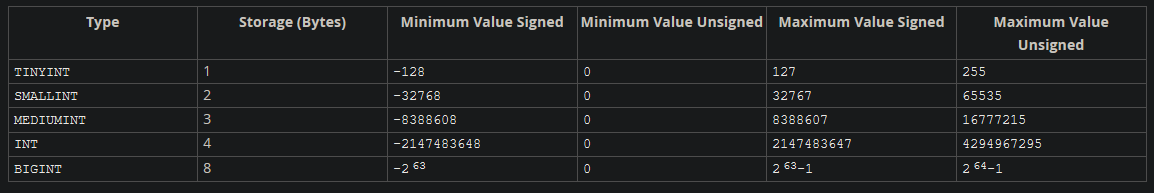

In [71]:
Image(images_folder+"mysql_numeric_type.PNG")

Every table, except population, product and indicator, have keys either generated, either retrieved from the original dataset.

To help improve space and performance we have to choose wisely the numeric type of those index variables. It will depends on the larger of these two factors :
- the max length we should let them, which itself depend on the modularity of the variable in our datasets.
- the maximum value if the variable is numeric, which will constrain the numeric type. For example, we cannot store 2501 inside a TINYINT.*Since we are working with integer, this factor is due to the fact that we chose to keep the original indices ; thus we might lose a space optimization because of this choice.*

supply_flag and indicator_flag already have their index type set, in the previous section.

In [72]:
types_sizes = (255, 65535, 16777215, 429467295)
types_names = ("TINYINT", "SMALLINT", "MEDIUMINT", "INT")

def get_type_index(x):
    i=0
    while x>types_sizes[i]:
        i+=1
    return i

def get_optimal_type(df, col):
    mod = len(df[col].unique())
    i = get_type_index(mod)
    print("%s has %i unique values => %s (%i)"%(col, mod, types_names[i], types_sizes[i]))
    if np.issubdtype(df[col], np.number):
        maxi = max(df[col].values)
        j = get_type_index(maxi)
        print("\tbut the variable is numeric and the max value is %i => %s (%i)"%(maxi, types_names[j], types_sizes[j]))

In [73]:
df_products.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')

In [74]:
check_dict = {("Product", "Item Code"):df_products, ("Indicator", "Item Code"):df_indicators, ("Product and Population","Element Code"):pd.concat([df_products, df_population]), ("Products, Population and Indicators", "Year", "Unit", "Area Code"):pd.concat([df_products, df_population, df_indicators])}

In [75]:
for k,v in check_dict.items():
    print("\n For tables %s"%k[0])
    for col in k[1:]:
        get_optimal_type(v,col)


 For tables Product
Item Code has 98 unique values => TINYINT (255)
	but the variable is numeric and the max value is 2899 => SMALLINT (65535)

 For tables Indicator
Item Code has 30 unique values => TINYINT (255)
	but the variable is numeric and the max value is 210401 => MEDIUMINT (16777215)

 For tables Product and Population
Element Code has 18 unique values => TINYINT (255)
	but the variable is numeric and the max value is 5911 => SMALLINT (65535)

 For tables Products, Population and Indicators
Year has 19 unique values => TINYINT (255)
	but the variable is numeric and the max value is 2018 => SMALLINT (65535)
Unit has 12 unique values => TINYINT (255)
Area Code has 204 unique values => TINYINT (255)
	but the variable is numeric and the max value is 351 => SMALLINT (65535)


**Nota bene** For the table Year, we will keep its data as SmallInt (with 65535 max value) but put our own indices as TinyInt (255 max unique values).

The key indexes of our three main tables have the prefix "id" and their type will strictly represent the maximum length of those tables.

In [76]:
i = get_type_index(len(df_products))
print("Product table length : %i => %s (%i)"%(len(df_products), types_names[i], types_sizes[i]))
i = get_type_index(len(df_population))
print("Population table length : %i => %s (%i)"%(len(df_population), types_names[i], types_sizes[i]))
i = get_type_index(len(df_indicators))
print("Indicator table length : %i => %s (%i)"%(len(df_indicators), types_names[i], types_sizes[i]))


Product table length : 771312 => MEDIUMINT (16777215)
Population table length : 1368 => SMALLINT (65535)
Indicator table length : 65787 => MEDIUMINT (16777215)


As for their Value type, it is constrained by the max values they convey.

In [77]:
i = get_type_index(max(df_products.Value.values))
print("Product max Value : %i => %s (%i)"%(max(df_products.Value.values), types_names[i], types_sizes[i]))
i = get_type_index(max(df_population.Value.values))
print("Population max Value : %i => %s (%i)"%(max(df_population.Value.values), types_names[i], types_sizes[i]))
print("Indicator Value are string and will remain as such for now.")

Product max Value : 768564 => MEDIUMINT (16777215)
Population max Value : 1452625 => MEDIUMINT (16777215)
Indicator Value are string and will remain as such for now.


[Go to the top](#start)

### Primary keys <a name="keys"></a>

Primary keys of all basic tables are very evident, since they are design for the uniqueness of each value this tables store.

Remain the primary keys of our three main tables : product, population and indicator.

In [78]:
print(df_products.columns)
print(df_population.columns)
print(df_indicators.columns)

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')
Index(['Area Code', 'Area', 'Element Code', 'Element', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')
Index(['Area Code', 'Area', 'Item Code', 'Item', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')


By logic, we could suggest that each combination of Area, Year, Unit and Item in the table product is unique, thus would make a valid primary key choice.

For the population table, there is only one Item value ("population") therefore the primary key would be composed of the three remaining variables. 

As for the indicators table, there is one Element value ("value") therefor the primary key would be (Area Year Item)

To check that, we can groupby the chosen list of variable and get the max count of the number of observations. If it is superior to one, then the combination isn't not uniquely present in the datasets and would not represent a valid primary key in the corresponding table.

In [79]:
def primarity_test(df, var_list):
    return df.groupby(var_list).size().max()==1

Instead of using full named variables like "Area", we can use their code like "Area Code". We already check for the validity of all coding variables in the section [Checking specificity of coding variables](#specificity).

In [80]:
primarity_test(df_products, ["Area Code","Year","Item Code", "Element Code"])

True

In [81]:
primarity_test(df_population,["Area Code","Year", "Element Code"])

True

In [82]:
primarity_test(df_indicators, ["Area Code","Year", "Item Code"])

True

Those combinations work, but there might be better ones. We can desgin a function that will try each combination of non-connected variable.

In [83]:
def list_primarities(df, all_vars):
    result={}
    combs = []
    for i in range(2, len(all_vars)+1):
        combs.extend(itertools.combinations(all_vars,i))
    for comb in combs:
        if primarity_test(df, list(comb)):
            result[", ".join(comb)]=len(comb)
    display(pd.DataFrame(result, index=["length"]).T.sort_values("length"))

We should note that it is also evident that the variables "Value" won't be checked here.

In [84]:
list_primarities(df_products, ("Area Code", "Element Code", "Item Code", "Year", "Unit", "Flag"))

length
Area Code, Element Code, Item Code, Year                 4
Area Code, Element Code, Item Code, Year, Unit           5
Area Code, Element Code, Item Code, Year, Flag           5
Area Code, Element Code, Item Code, Year, Unit,...       6

We have the confirmation for the primarity of the combination we chose : Area Code, Element Code, Item Code and Year.

In [85]:
list_primarities(df_population, ("Area Code", "Element Code","Year", "Unit", "Flag"))

length
Area Code, Element Code, Year                   3
Area Code, Year, Unit                           3
Area Code, Element Code, Year, Unit             4
Area Code, Element Code, Year, Flag             4
Area Code, Year, Unit, Flag                     4
Area Code, Element Code, Year, Unit, Flag       5

Here again, Area Code, Element Code and Year is effectively the best and most logical choice of primary key to make.

In [86]:
list_primarities(df_indicators, ("Area Code", "Item Code","Year", "Unit", "Flag"))

length
Area Code, Item Code, Year                   3
Area Code, Item Code, Year, Unit             4
Area Code, Item Code, Year, Flag             4
Area Code, Item Code, Year, Unit, Flag       5

Area Code, Item Code, Year is indeed the best primary key choice, here again.

The three table will have an "ID" column each, with a UNIQUE paramater. This way, the id will be uniquely linked to each new combination of primary entered in the table, during an insertion.

[Go to the top](#start)

### Building the Schema <a name="schema"></a>

We can now use all the insights we gathered until now to design our database's structure.

In [87]:
con = pymysql.connect(host=host, user=user, password=password, port=port)

In [88]:
cursor = con.cursor()

In [89]:
df_products.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')

In [90]:
optimal_size

{'Area': 52,
 'supply_Element': 38,
 'product_Item': 31,
 'indicator_Item': 101,
 'Unit': 30,
 'supply_Flag': 2,
 'indicator_Flag': 2,
 'supply_Flag Description': 76,
 'indicator_Flag Description': 30,
 'element': 38,
 'indicator_Value': 7.0}

In [91]:
cursor.execute("CREATE SCHEMA IF NOT EXISTS faodb DEFAULT CHARACTER SET utf8;")
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.area (area_code SMALLINT NOT NULL, area_name VARCHAR(%i) NOT NULL, PRIMARY KEY (area_code), UNIQUE INDEX area_code_UNIQUE (area_code ASC), UNIQUE INDEX area_name_UNIQUE (area_name ASC));"%optimal_size["Area"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.product_item (item_code SMALLINT NOT NULL, item_name VARCHAR(%i) NULL, PRIMARY KEY (item_code), UNIQUE INDEX item_code_UNIQUE (item_code ASC), UNIQUE INDEX item_name_UNIQUE (item_name ASC));"%optimal_size["product_Item"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.supply_flag (flag_code VARCHAR(%i) NOT NULL, flag_description VARCHAR(%i) NULL, PRIMARY KEY (flag_code), UNIQUE INDEX flag_code_UNIQUE (flag_code ASC), UNIQUE INDEX flag_description_UNIQUE (flag_description ASC));"%(optimal_size["supply_Flag"], optimal_size["supply_Flag Description"]))
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.unit (unit_code TINYINT NOT NULL AUTO_INCREMENT, unit_description VARCHAR(%i) NULL, PRIMARY KEY (unit_code), UNIQUE INDEX idunit_UNIQUE (unit_code ASC), UNIQUE INDEX unit_description_UNIQUE (unit_description ASC));"%optimal_size["Unit"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.indicator_flag (flag_code VARCHAR(%i) NOT NULL, flag_description VARCHAR(%i) NULL, PRIMARY KEY (flag_code), UNIQUE INDEX idindicator_flag_UNIQUE (flag_code ASC), UNIQUE INDEX flag_description_UNIQUE (flag_description ASC));"%(optimal_size["indicator_Flag"], optimal_size["indicator_Flag Description"]))
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.year (year_code TINYINT NOT NULL AUTO_INCREMENT, value SMALLINT NULL, PRIMARY KEY (year_code), UNIQUE INDEX year_code_UNIQUE (year_code ASC), UNIQUE INDEX value_UNIQUE (value ASC));")
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.indicator_item (item_code MEDIUMINT NOT NULL, item_name VARCHAR(%i) NULL, unit_unit_code TINYINT NOT NULL, PRIMARY KEY (item_code), UNIQUE INDEX item_code_UNIQUE (item_code ASC), UNIQUE INDEX item_name_UNIQUE (item_name ASC), INDEX fk_indicator_item_unit1_idx (unit_unit_code ASC), CONSTRAINT fk_indicator_item_unit1 FOREIGN KEY (unit_unit_code) REFERENCES faodb.unit (unit_code));"%optimal_size["indicator_Item"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.supply_element (element_code SMALLINT NOT NULL, element_name VARCHAR(%i) NULL, unit_unit_code TINYINT NOT NULL, PRIMARY KEY (element_code), UNIQUE INDEX element_code_UNIQUE (element_code ASC), UNIQUE INDEX element_name_UNIQUE (element_name ASC), CONSTRAINT fk_supply_element_unit1 FOREIGN KEY (unit_unit_code)  REFERENCES faodb.unit (unit_code));"%optimal_size["supply_Element"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.product (idproduct MEDIUMINT NOT NULL AUTO_INCREMENT, area_area_code SMALLINT NOT NULL, product_item_item_code SMALLINT NOT NULL, supply_element_element_code SMALLINT NOT NULL, year_year_code TINYINT NOT NULL, supply_flag_flag_code VARCHAR(%i) NOT NULL, value MEDIUMINT NULL, PRIMARY KEY (area_area_code, product_item_item_code, supply_element_element_code, year_year_code), UNIQUE INDEX idproduct_UNIQUE (idproduct ASC), INDEX fk_product_product_item_idx (product_item_item_code ASC), INDEX fk_product_product_flag1_idx (supply_flag_flag_code ASC), INDEX fk_product_product_element1_idx (supply_element_element_code ASC), INDEX fk_product_area1_idx (area_area_code ASC), INDEX fk_product_year1_idx (year_year_code ASC), CONSTRAINT fk_product_product_item FOREIGN KEY (product_item_item_code) REFERENCES faodb.product_item (item_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_product_product_flag1 FOREIGN KEY (supply_flag_flag_code) REFERENCES faodb.supply_flag (flag_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_product_product_element1 FOREIGN KEY (supply_element_element_code) REFERENCES faodb.supply_element (element_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_product_area1 FOREIGN KEY (area_area_code) REFERENCES faodb.area (area_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_product_year1 FOREIGN KEY (year_year_code) REFERENCES faodb.year (year_code) ON DELETE NO ACTION ON UPDATE NO ACTION);"%optimal_size["supply_Flag"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.population (idpopulation SMALLINT NOT NULL AUTO_INCREMENT, area_area_code SMALLINT NOT NULL, supply_element_element_code SMALLINT NOT NULL, year_year_code TINYINT NOT NULL, supply_flag_flag_code VARCHAR(%i) NOT NULL, value MEDIUMINT NULL, PRIMARY KEY (area_area_code, supply_element_element_code, year_year_code), INDEX fk_population_year1_idx (year_year_code ASC), INDEX fk_population_area1_idx (area_area_code ASC), INDEX fk_population_supply_element1_idx (supply_element_element_code ASC), INDEX fk_population_supply_flag1_idx (supply_flag_flag_code ASC), UNIQUE INDEX idpopulation_UNIQUE (idpopulation ASC), CONSTRAINT fk_population_year1 FOREIGN KEY (year_year_code) REFERENCES faodb.year (year_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_population_area1 FOREIGN KEY (area_area_code) REFERENCES faodb.area (area_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_population_supply_element1 FOREIGN KEY (supply_element_element_code) REFERENCES faodb.supply_element (element_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_population_supply_flag1 FOREIGN KEY (supply_flag_flag_code) REFERENCES faodb.supply_flag (flag_code) ON DELETE NO ACTION ON UPDATE NO ACTION);"%optimal_size["supply_Flag"])
cursor.execute("CREATE TABLE IF NOT EXISTS faodb.indicator (idindicator MEDIUMINT NOT NULL AUTO_INCREMENT, area_area_code SMALLINT NOT NULL, indicator_item_item_code MEDIUMINT NOT NULL, year_year_code TINYINT NOT NULL, indicator_flag_flag_code VARCHAR(%i) NOT NULL, value VARCHAR(%i) NULL, PRIMARY KEY (area_area_code, indicator_item_item_code, year_year_code), UNIQUE INDEX idindicator_UNIQUE (idindicator ASC), INDEX fk_indicator_indicator_item1_idx (indicator_item_item_code ASC), INDEX fk_indicator_indicator_flag1_idx (indicator_flag_flag_code ASC), INDEX fk_indicator_area1_idx (area_area_code ASC), INDEX fk_indicator_year1_idx (year_year_code ASC), CONSTRAINT fk_indicator_indicator_item1 FOREIGN KEY (indicator_item_item_code) REFERENCES faodb.indicator_item (item_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_indicator_indicator_flag1 FOREIGN KEY (indicator_flag_flag_code) REFERENCES faodb.indicator_flag (flag_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_indicator_area1 FOREIGN KEY (area_area_code) REFERENCES faodb.area (area_code) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT fk_indicator_year1 FOREIGN KEY (year_year_code) REFERENCES faodb.year (year_code) ON DELETE NO ACTION ON UPDATE NO ACTION);"%(optimal_size["indicator_Flag"], optimal_size["indicator_Value"]))

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1007, "Can't create database 'faodb'; database exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1050, "Table 'area' already exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1050, "Table 'product_item' already exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1050, "Table 'supply_flag' already exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1050, "Table 'unit' already exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1050, "Table 'indicator_flag' already exists")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_g

0

In [92]:
cursor.execute("USE faodb;")

0

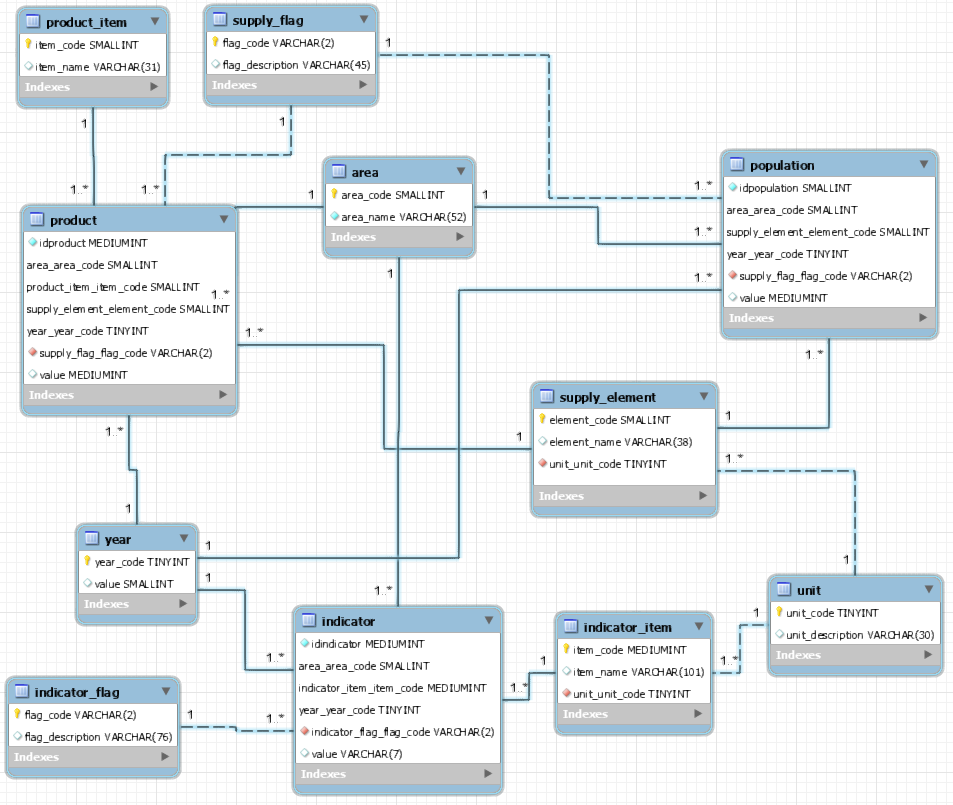

In [93]:
Image(images_folder+"mcd_final.PNG")

In [94]:
pd.read_sql("SHOW TABLES;", con=con)

Tables_in_faodb
0             area
1        indicator
2   indicator_flag
3   indicator_item
4       population
5          product
6     product_item
7   supply_element
8      supply_flag
9             unit
10            year

[Go to the top](#start)

### Preparing data for tables <a name="preparing"></a>

#### Easing the data insertion <a name="ease_insertion"></a>

"Basic" table only have two columns : the index and the desription. Let's design a function that will show and add all the values for each of those tables.

In [95]:
df_products.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')

In [96]:
def insert_basic_table(df, code_col, value_col, table):
    # getting the two columns names as a tuple
    cols = pd.read_sql("SHOW COLUMNS FROM %s;"%table, con=con).loc[:,"Field"].values
    print(cols)
    # getting each couples (code_ name) from the dataset
    df=df.groupby([code_col,value_col]).size().reset_index().drop(columns=(0))
    display(df)
    for row in df.itertuples(index=False):
        if np.issubdtype(df[code_col], np.number):
            query = "INSERT IGNORE INTO %s (%s, %s) VALUES (%i, \"%s\")"%(table, cols[0], cols[1], row[0], row[1])
        else:
            query = "INSERT IGNORE INTO %s (%s, %s) VALUES (\"%s\", \"%s\")"%(table, cols[0], cols[1], row[0], row[1] )
        print(query)
        cursor.execute(query)

**Nota Bene** : All the inserts here will be done with "INSERT IGNORE " to insure a further execution of this notebook won't block the thread.

[Go to the top](#start)

#### Inserting into most basic tables <a name="basic_insert"></a>

The above function was designed for those 6 tables.

In [97]:
df_supplies = pd.concat([df_products, df_population])
df_all = pd.concat([df_supplies,df_indicators])

In [98]:
df_supplies.columns

Index(['Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item',
       'Year', 'Unit', 'Value', 'Flag', 'Flag Description'],
      dtype='object')

In [99]:
insert_basic_table(df_products, "Item Code", "Item", "product_item")

['item_code' 'item_name']


Item Code                     Item
0        2511       Wheat and products
1        2513      Barley and products
2        2514       Maize and products
3        2515         Rye and products
4        2516                     Oats
..        ...                      ...
93       2781           Fish, Body Oil
94       2782          Fish, Liver Oil
95       2805        Rice and products
96       2848  Milk - Excluding Butter
97       2899            Miscellaneous

[98 rows x 2 columns]

INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2511, "Wheat and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2513, "Barley and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2514, "Maize and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2515, "Rye and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2516, "Oats")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2517, "Millet and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2518, "Sorghum and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2520, "Cereals, Other")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2531, "Potatoes and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2532, "Cassava and products")
INSERT IGNORE INTO product_item (item_code, item_name) VALUES (2533, "Sweet potatoes")
INSERT IGNORE 

In [100]:
insert_basic_table(df_supplies, "Flag","Flag Description", "supply_flag")

['flag_code' 'flag_description']


Flag                                   Flag Description
0    A  Aggregate, may include official, semi-official...
1   Fc                                    Calculated data
2    S                                  Standardized data

INSERT IGNORE INTO supply_flag (flag_code, flag_description) VALUES ("A", "Aggregate, may include official, semi-official, estimated or calculated data")
INSERT IGNORE INTO supply_flag (flag_code, flag_description) VALUES ("Fc", "Calculated data")
INSERT IGNORE INTO supply_flag (flag_code, flag_description) VALUES ("S", "Standardized data")


In [101]:
insert_basic_table(df_all, "Area Code","Area", "area")

['area_code' 'area_name']


Area Code            Area
0            1         Armenia
1            2     Afghanistan
2            3         Albania
3            4         Algeria
4            5  American Samoa
..         ...             ...
199        273      Montenegro
200        276           Sudan
201        277     South Sudan
202        299       Palestine
203        351           China

[204 rows x 2 columns]

INSERT IGNORE INTO area (area_code, area_name) VALUES (1, "Armenia")
INSERT IGNORE INTO area (area_code, area_name) VALUES (2, "Afghanistan")
INSERT IGNORE INTO area (area_code, area_name) VALUES (3, "Albania")
INSERT IGNORE INTO area (area_code, area_name) VALUES (4, "Algeria")
INSERT IGNORE INTO area (area_code, area_name) VALUES (5, "American Samoa")
INSERT IGNORE INTO area (area_code, area_name) VALUES (6, "Andorra")
INSERT IGNORE INTO area (area_code, area_name) VALUES (7, "Angola")
INSERT IGNORE INTO area (area_code, area_name) VALUES (8, "Antigua and Barbuda")
INSERT IGNORE INTO area (area_code, area_name) VALUES (9, "Argentina")
INSERT IGNORE INTO area (area_code, area_name) VALUES (10, "Australia")
INSERT IGNORE INTO area (area_code, area_name) VALUES (11, "Austria")
INSERT IGNORE INTO area (area_code, area_name) VALUES (12, "Bahamas")
INSERT IGNORE INTO area (area_code, area_name) VALUES (13, "Bahrain")
INSERT IGNORE INTO area (area_code, area_name) VALUES (14, "Barbados")
IN

In [102]:
insert_basic_table(df_indicators, "Flag", "Flag Description", "indicator_flag")

['flag_code' 'flag_description']


Flag                Flag Description
0    F                    FAO estimate
1   NR                    Not reported
2   NV              Data not available
3    O                   Official data
4    X  International reliable sources

INSERT IGNORE INTO indicator_flag (flag_code, flag_description) VALUES ("F", "FAO estimate")
INSERT IGNORE INTO indicator_flag (flag_code, flag_description) VALUES ("NR", "Not reported")
INSERT IGNORE INTO indicator_flag (flag_code, flag_description) VALUES ("NV", "Data not available")
INSERT IGNORE INTO indicator_flag (flag_code, flag_description) VALUES ("O", "Official data")
INSERT IGNORE INTO indicator_flag (flag_code, flag_description) VALUES ("X", "International reliable sources")


[Go to the top](#start)

#### Inserting into year and unit  <a name="insert_basics"></a>

Those two tables are special because they have auto-incrementing indices. Therefore, they only need one set of values, which are the unique ones in the original datasets.

Let's start with year. We should save coherence by inserting years values in increasing order.

In [103]:
for y in sorted(df_all.Year.unique()):
    query = "INSERT IGNORE INTO year (%s) VALUES (%i)"%("value", y)
    print(query)
    cursor.execute(query)

INSERT IGNORE INTO year (value) VALUES (2000)
INSERT IGNORE INTO year (value) VALUES (2001)
INSERT IGNORE INTO year (value) VALUES (2002)
INSERT IGNORE INTO year (value) VALUES (2003)
INSERT IGNORE INTO year (value) VALUES (2004)
INSERT IGNORE INTO year (value) VALUES (2005)
INSERT IGNORE INTO year (value) VALUES (2006)
INSERT IGNORE INTO year (value) VALUES (2007)
INSERT IGNORE INTO year (value) VALUES (2008)
INSERT IGNORE INTO year (value) VALUES (2009)
INSERT IGNORE INTO year (value) VALUES (2010)
INSERT IGNORE INTO year (value) VALUES (2011)
INSERT IGNORE INTO year (value) VALUES (2012)
INSERT IGNORE INTO year (value) VALUES (2013)
INSERT IGNORE INTO year (value) VALUES (2014)
INSERT IGNORE INTO year (value) VALUES (2015)
INSERT IGNORE INTO year (value) VALUES (2016)
INSERT IGNORE INTO year (value) VALUES (2017)
INSERT IGNORE INTO year (value) VALUES (2018)


We will now insert the different units values.

In [104]:
for u in df_all.Unit.unique():
    query="INSERT IGNORE INTO unit (%s) VALUES (\"%s\")"%("unit_description", u)
    print(query)
    cursor.execute(query)

INSERT IGNORE INTO unit (unit_description) VALUES ("1000 tonnes")
INSERT IGNORE INTO unit (unit_description) VALUES ("kg")
INSERT IGNORE INTO unit (unit_description) VALUES ("kcal/capita/day")
INSERT IGNORE INTO unit (unit_description) VALUES ("g/capita/day")
INSERT IGNORE INTO unit (unit_description) VALUES ("1000 persons")
INSERT IGNORE INTO unit (unit_description) VALUES ("%")
INSERT IGNORE INTO unit (unit_description) VALUES ("I$ per person")
INSERT IGNORE INTO unit (unit_description) VALUES ("I$")
INSERT IGNORE INTO unit (unit_description) VALUES ("millions")
INSERT IGNORE INTO unit (unit_description) VALUES ("index")
INSERT IGNORE INTO unit (unit_description) VALUES ("1000 I$")
INSERT IGNORE INTO unit (unit_description) VALUES ("per 100 square km of land area")


[Go to the top](#start)

#### Inserting supply_element and indicator_item  <a name="insert_middle"></a>

Those two tables are indexing into to the table unit and must be done after its insertion..

In [105]:
# insert_basic_table(df_supplies, "Element Code","Element", "supply_element")
df=df_supplies.groupby(["Element Code", "Element", "Unit"]).size().reset_index().drop(columns=(0))
for row in df.itertuples(index=False):
    query="INSERT IGNORE INTO supply_element (%s, %s, %s) VALUES (%i, \"%s\", (SELECT unit_code FROM unit WHERE unit_description = \"%s\"))"%("element_code", "element_name","unit_unit_code", row[0], row[1], row[2])
    print(query)
    cursor.execute(query)

INSERT IGNORE INTO supply_element (element_code, element_name, unit_unit_code) VALUES (511, "Total Population - Both sexes", (SELECT unit_code FROM unit WHERE unit_description = "1000 persons"))
INSERT IGNORE INTO supply_element (element_code, element_name, unit_unit_code) VALUES (645, "Food supply quantity (kg/capita/yr)", (SELECT unit_code FROM unit WHERE unit_description = "kg"))
INSERT IGNORE INTO supply_element (element_code, element_name, unit_unit_code) VALUES (664, "Food supply (kcal/capita/day)", (SELECT unit_code FROM unit WHERE unit_description = "kcal/capita/day"))
INSERT IGNORE INTO supply_element (element_code, element_name, unit_unit_code) VALUES (674, "Protein supply quantity (g/capita/day)", (SELECT unit_code FROM unit WHERE unit_description = "g/capita/day"))
INSERT IGNORE INTO supply_element (element_code, element_name, unit_unit_code) VALUES (684, "Fat supply quantity (g/capita/day)", (SELECT unit_code FROM unit WHERE unit_description = "g/capita/day"))
INSERT IGNOR

In [106]:
# insert_basic_table(df_indicators, "Item Code","Item", "indicator_item")
df=df_indicators.groupby(["Item Code", "Item", "Unit"]).size().reset_index().drop(columns=(0))
for row in df.itertuples(index=False):
    query="INSERT IGNORE INTO indicator_item (%s, %s, %s) VALUES (%i, \"%s\", (SELECT unit_code FROM unit WHERE unit_description = \"%s\"))"%("item_code", "item_name","unit_unit_code", row[0], row[1], row[2])
    print(query)
    cursor.execute(query)

INSERT IGNORE INTO indicator_item (item_code, item_name, unit_unit_code) VALUES (21010, "Average dietary energy supply adequacy (percent) (3-year average)", (SELECT unit_code FROM unit WHERE unit_description = "%"))
INSERT IGNORE INTO indicator_item (item_code, item_name, unit_unit_code) VALUES (21011, "Average value of food production (constant 2004-2006 I$/cap) (3-year average)", (SELECT unit_code FROM unit WHERE unit_description = "I$ per person"))
INSERT IGNORE INTO indicator_item (item_code, item_name, unit_unit_code) VALUES (21012, "Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)", (SELECT unit_code FROM unit WHERE unit_description = "%"))
INSERT IGNORE INTO indicator_item (item_code, item_name, unit_unit_code) VALUES (21013, "Average protein supply (g/cap/day) (3-year average)", (SELECT unit_code FROM unit WHERE unit_description = "g/capita/day"))
INSERT IGNORE INTO indicator_item (item_code, item_name, unit_unit_code) VALUES

[Go to the top](#start)

#### Inserting product, population and indicator  <a name="insert_top"></a>

Those are the biggest table to add, since we need to add each of their rows.
At the same time, it will confirm that our database was well designed before-hand.

In [107]:
pd.read_sql("DESCRIBE product", con=con)

Field          Type Null  Key Default           Extra
0                    idproduct  mediumint(9)   NO  UNI    None  auto_increment
1               area_area_code   smallint(6)   NO  PRI    None                
2       product_item_item_code   smallint(6)   NO  PRI    None                
3  supply_element_element_code   smallint(6)   NO  PRI    None                
4               year_year_code    tinyint(4)   NO  PRI    None                
5        supply_flag_flag_code    varchar(2)   NO  MUL    None                
6                        value  mediumint(9)  YES         None

In [108]:
df_products

Area Code         Area  Element Code  \
0               2  Afghanistan          5511   
1               2  Afghanistan          5611   
2               2  Afghanistan          5072   
3               2  Afghanistan          5911   
4               2  Afghanistan          5301   
...           ...          ...           ...   
599676        181     Zimbabwe          5142   
599677        181     Zimbabwe           645   
599678        181     Zimbabwe           664   
599679        181     Zimbabwe           674   
599680        181     Zimbabwe           684   

                                       Element  Item Code           Item  \
0                                   Production       2731    Bovine Meat   
1                              Import Quantity       2731    Bovine Meat   
2                              Stock Variation       2731    Bovine Meat   
3                              Export Quantity       2731    Bovine Meat   
4                     Domestic supply quantity       2731    Bovine Meat   
...                                        ...        ...            ...   
599676                                    Food       2899  Miscellaneous   
599677     Food supply quantity (kg/capita/yr)       2899  Miscellaneous   
599678           Food supply (kcal/capita/day)       2899  Miscellaneous   
599679  Protein supply quantity (g/capita/day)       2899  Miscellaneous   
599680      Fat supply quantity (g/capita/day)       2899  Miscellaneous   

        Year             Unit  Value Flag   Flag Description  
0       2014      1000 tonnes    121    S  Standardized data  
1       2014      1000 tonnes     16    S  Standardized data  
2       2014      1000 tonnes      0    S  Standardized data  
3       2014      1000 tonnes      0    S  Standardized data  
4       2014      1000 tonnes    138    S  Standardized data  
...      ...              ...    ...  ...                ...  
599676  2017      1000 tonnes     19    S  Standardized data  
599677  2017               kg      1   Fc    Calculated data  
599678  2017  kcal/capita/day      1   Fc    Calculated data  
599679  2017     g/capita/day      0   Fc    Calculated data  
599680  2017     g/capita/day      0   Fc    Calculated data  

[771312 rows x 11 columns]

In [109]:
l = len(df_products.index.values)
k=0
for _,row in df_products.iterrows():
    k+=1
    if k%(l//100)==0 or k==l:
        print("%i / %i insertions into product done. (%.2f%%)"%(k, l, k*100/l))
    cursor.execute("""INSERT IGNORE INTO product(product_item_item_code, supply_flag_flag_code, supply_element_element_code,
    area_area_code,  value, year_year_code) VALUES (%i, %s, %i, %i,%i,
    (SELECT year_code FROM year WHERE value=%i));"""%(row["Item Code"], "\"%s\""%row["Flag"], row["Element Code"], row["Area Code"], row["Value"], row["Year"]))

7713 / 771312 insertions into product done. (1.00%)
15426 / 771312 insertions into product done. (2.00%)
23139 / 771312 insertions into product done. (3.00%)
30852 / 771312 insertions into product done. (4.00%)
38565 / 771312 insertions into product done. (5.00%)
46278 / 771312 insertions into product done. (6.00%)
53991 / 771312 insertions into product done. (7.00%)
61704 / 771312 insertions into product done. (8.00%)
69417 / 771312 insertions into product done. (9.00%)
77130 / 771312 insertions into product done. (10.00%)
84843 / 771312 insertions into product done. (11.00%)
92556 / 771312 insertions into product done. (12.00%)
100269 / 771312 insertions into product done. (13.00%)
107982 / 771312 insertions into product done. (14.00%)
115695 / 771312 insertions into product done. (15.00%)
123408 / 771312 insertions into product done. (16.00%)
131121 / 771312 insertions into product done. (17.00%)
138834 / 771312 insertions into product done. (18.00%)
146547 / 771312 insertions into 

In [110]:
display(pd.read_sql("DESCRIBE population", con=con))
df_population

Field          Type Null  Key Default           Extra
0                 idpopulation   smallint(6)   NO  UNI    None  auto_increment
1               area_area_code   smallint(6)   NO  PRI    None                
2  supply_element_element_code   smallint(6)   NO  PRI    None                
3               year_year_code    tinyint(4)   NO  PRI    None                
4        supply_flag_flag_code    varchar(2)   NO  MUL    None                
5                        value  mediumint(9)  YES         None

Area Code         Area  Element Code                        Element  \
0             2  Afghanistan           511  Total Population - Both sexes   
1             2  Afghanistan          5301       Domestic supply quantity   
2             2  Afghanistan           511  Total Population - Both sexes   
3             2  Afghanistan          5301       Domestic supply quantity   
4             2  Afghanistan           511  Total Population - Both sexes   
...         ...          ...           ...                            ...   
1363        181     Zimbabwe          5301       Domestic supply quantity   
1364        181     Zimbabwe           511  Total Population - Both sexes   
1365        181     Zimbabwe          5301       Domestic supply quantity   
1366        181     Zimbabwe           511  Total Population - Both sexes   
1367        181     Zimbabwe          5301       Domestic supply quantity   

      Year          Unit  Value Flag   Flag Description  
0     2014  1000 persons  33370    S  Standardized data  
1     2014   1000 tonnes      0    S  Standardized data  
2     2015  1000 persons  34413    S  Standardized data  
3     2015   1000 tonnes      0    S  Standardized data  
4     2016  1000 persons  35383    S  Standardized data  
...    ...           ...    ...  ...                ...  
1363  2015   1000 tonnes      0    S  Standardized data  
1364  2016  1000 persons  14030    S  Standardized data  
1365  2016   1000 tonnes      0    S  Standardized data  
1366  2017  1000 persons  14236    S  Standardized data  
1367  2017   1000 tonnes      0    S  Standardized data  

[1368 rows x 9 columns]

In [111]:
l = len(df_population.index.values)
k=0
for _,row in df_population.iterrows():
    k+=1
    if k%(l//20)==0 or k==l:
        print("%i / %i insertions into population done. (%.2f%%)"%(k, l, k*100/l))
    cursor.execute("""INSERT IGNORE INTO population(value, year_year_code, area_area_code, supply_element_element_code, supply_flag_flag_code) VALUES (%i,
    (SELECT year_code FROM year WHERE value=%i), %i, %i, \"%s\");"""%(row["Value"], row["Year"], row["Area Code"], row["Element Code"], row["Flag"]))

68 / 1368 insertions into population done. (4.97%)
136 / 1368 insertions into population done. (9.94%)
204 / 1368 insertions into population done. (14.91%)
272 / 1368 insertions into population done. (19.88%)
340 / 1368 insertions into population done. (24.85%)
408 / 1368 insertions into population done. (29.82%)
476 / 1368 insertions into population done. (34.80%)
544 / 1368 insertions into population done. (39.77%)
612 / 1368 insertions into population done. (44.74%)
680 / 1368 insertions into population done. (49.71%)
748 / 1368 insertions into population done. (54.68%)
816 / 1368 insertions into population done. (59.65%)
884 / 1368 insertions into population done. (64.62%)
952 / 1368 insertions into population done. (69.59%)
1020 / 1368 insertions into population done. (74.56%)
1088 / 1368 insertions into population done. (79.53%)
1156 / 1368 insertions into population done. (84.50%)
1224 / 1368 insertions into population done. (89.47%)
1292 / 1368 insertions into population done. 

In [112]:
display(pd.read_sql("DESCRIBE indicator", con=con))
df_indicators

Field          Type Null  Key Default           Extra
0               idindicator  mediumint(9)   NO  UNI    None  auto_increment
1            area_area_code   smallint(6)   NO  PRI    None                
2  indicator_item_item_code  mediumint(9)   NO  PRI    None                
3            year_year_code    tinyint(4)   NO  PRI    None                
4  indicator_flag_flag_code    varchar(2)   NO  MUL    None                
5                     value    varchar(7)  YES         None

Area Code         Area  Item Code  \
0              2  Afghanistan      21010   
1              2  Afghanistan      21010   
2              2  Afghanistan      21010   
3              2  Afghanistan      21010   
4              2  Afghanistan      21010   
...          ...          ...        ...   
65782        181     Zimbabwe      21049   
65783        181     Zimbabwe      21049   
65784        181     Zimbabwe      21049   
65785        181     Zimbabwe      21049   
65786        181     Zimbabwe      21049   

                                                    Item  Year Unit Value  \
0      Average dietary energy supply adequacy (percen...  2001    %    89   
1      Average dietary energy supply adequacy (percen...  2002    %    88   
2      Average dietary energy supply adequacy (percen...  2003    %    90   
3      Average dietary energy supply adequacy (percen...  2004    %    93   
4      Average dietary energy supply adequacy (percen...  2005    %    95   
...                                                  ...   ...  ...   ...   
65782            Prevalence of low birthweight (percent)  2011    %  12.8   
65783            Prevalence of low birthweight (percent)  2012    %  12.8   
65784            Prevalence of low birthweight (percent)  2013    %  12.7   
65785            Prevalence of low birthweight (percent)  2014    %  12.7   
65786            Prevalence of low birthweight (percent)  2015    %  12.6   

      Flag                Flag Description  
0        F                    FAO estimate  
1        F                    FAO estimate  
2        F                    FAO estimate  
3        F                    FAO estimate  
4        F                    FAO estimate  
...    ...                             ...  
65782    X  International reliable sources  
65783    X  International reliable sources  
65784    X  International reliable sources  
65785    X  International reliable sources  
65786    X  International reliable sources  

[65787 rows x 9 columns]

In [113]:
l = len(df_indicators.index.values)
k=0
for _, row in df_indicators.iterrows():
    k+=1
    if k%(l//10)==0 or k==l:
        print("%i / %i insertions into indicator done. (%.2f%%)"%(k, l, k*100/l))
    cursor.execute("""INSERT IGNORE INTO indicator(indicator_item_item_code, indicator_flag_flag_code, area_area_code, value, year_year_code) VALUES (%i,
    \"%s\", %i,  \"%s\", (SELECT year_code FROM year WHERE value=%i));"""%(row["Item Code"], row["Flag"], row["Area Code"], row["Value"], row["Year"]))

6578 / 65787 insertions into indicator done. (10.00%)
13156 / 65787 insertions into indicator done. (20.00%)
19734 / 65787 insertions into indicator done. (30.00%)
26312 / 65787 insertions into indicator done. (40.00%)
32890 / 65787 insertions into indicator done. (49.99%)
39468 / 65787 insertions into indicator done. (59.99%)
46046 / 65787 insertions into indicator done. (69.99%)
52624 / 65787 insertions into indicator done. (79.99%)
59202 / 65787 insertions into indicator done. (89.99%)
65780 / 65787 insertions into indicator done. (99.99%)
65787 / 65787 insertions into indicator done. (100.00%)


Since we are dealing with lots of data here, we might want to use the fastern but less checked, "LOAD DATA INFILE", but with the extensive checks and preparation we have done here, it would be counter-productive.

[Go to the top](#start)

### Commit ! <a name="commit"></a>

Our data is ready, but we have to commit it our transaction.

Doing all insertions before committing is way faster that enabling the connexion "autocommit" parameter, because they will be done in one transaction instead of many (one per row).

In [114]:
con.commit()

[Go to the top](#start)

# Answering some questions via SQL <a name="answer"></a>

We will use ***SQL code only*** to answer those questions, here. By default, the last year available (2017) will be considered.

## Top 10 countries with highest ratio of disponibility proteins/unhabitant  <a name="sql_question_1a"></a>

We need a request that will give us the TOP 10 of countries which show the highest values resulting from the operation : protein quantity / total population.

Protein quantity is inside the table product and total population in the table population.

To get the total protein per country, we must group all "protein" product by country in the product table.

In [115]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, SUM(value) as "total proteins per capita per day (in g)"
FROM product 
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element WHERE element_name LIKE '%protein%')
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY  area_area_code
""", con=con)

country  total proteins per capita per day (in g)
0        Armenia                                      84.0
1    Afghanistan                                      46.0
2        Albania                                     108.0
3        Algeria                                      76.0
4         Angola                                      41.0
..           ...                                       ...
168   Luxembourg                                      90.0
169       Serbia                                      67.0
170   Montenegro                                      96.0
171        Sudan                                      58.0
172        China                                      87.0

[173 rows x 2 columns]

In [116]:
cursor.execute("SELECT year_code FROM year WHERE value = 2017")

1

We need to sort and keep the top 10 from this result.

In [117]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, 
SUM(value) as proteins_per_capita_per_day
FROM product 
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element WHERE element_name LIKE '%protein%')
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY area_area_code
ORDER BY proteins_per_capita_per_day DESC
LIMIT 10
""", con=con)

country  proteins_per_capita_per_day
0                   Iceland                        125.0
1      China, Hong Kong SAR                        121.0
2                 Lithuania                        110.0
3                    Israel                        109.0
4                   Albania                        108.0
5                   Finland                         99.0
6                   Denmark                         98.0
7  United States of America                         98.0
8                    France                         96.0
9                Montenegro                         96.0

[Go to the top](#start)

## Top 10 countries with highest ratio of kcal/unhabitant <a name="sql_question_1b"></a>

We are constrained to a unit here. Let's see where we do find the unit "kcal" in the product table.

In [118]:
pd.read_sql("""SELECT DISTINCT (SELECT element_name FROM supply_element WHERE element_code = product.supply_element_element_code) as element_in_kcal
FROM product
WHERE supply_element_element_code IN 
    (SELECT element_code FROM supply_element WHERE unit_unit_code IN
        (SELECT unit_code FROM unit WHERE unit_description LIKE '%kcal%'))
""", con=con)

element_in_kcal
0  Food supply (kcal/capita/day)

In [119]:
pd.read_sql("""SELECT DISTINCT (SELECT element_name FROM supply_element WHERE element_code = product.supply_element_element_code) as element_in_kcal
FROM product
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element 
    WHERE unit_unit_code IN (SELECT unit_code FROM unit WHERE unit_description LIKE '%kcal%'))
""", con=con)

element_in_kcal
0  Food supply (kcal/capita/day)

Only food supplies have the unit "kcal". Now let's do the total sum of kcal per habitant for each country.

In [120]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, SUM(value) as "total kcal per capita per day"
FROM product 
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element WHERE element_name ='Food supply (kcal/capita/day)')
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY area_area_code
""", con=con)

country  total kcal per capita per day
0        Armenia                         3072.0
1    Afghanistan                         1997.0
2        Albania                         3400.0
3        Algeria                         3345.0
4         Angola                         2266.0
..           ...                            ...
168   Luxembourg                         3334.0
169       Serbia                         2799.0
170   Montenegro                         3478.0
171        Sudan                         2431.0
172        China                         3191.0

[173 rows x 2 columns]

Finally, we can sort the result and keep the top 10.

In [121]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, SUM(value) as total_kcal_per_capita_per_day
FROM product 
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element WHERE element_name ='Food supply (kcal/capita/day)')
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY area_area_code
ORDER BY total_kcal_per_capita_per_day DESC
LIMIT 10
""", con=con)

country  total_kcal_per_capita_per_day
0                   Belgium                         3770.0
1  United States of America                         3762.0
2                   Ireland                         3714.0
3                   Austria                         3694.0
4                   Iceland                         3629.0
5                   Germany                         3559.0
6                    France                         3556.0
7                    Turkey                         3538.0
8                    Poland                         3526.0
9                   Romania                         3525.0

[Go to the top](#start)

## Top 10 countries with lowest ratio of disponibility proteins/unhabitant  <a name="sql_question_2"></a>

We can simply take the same request we made when answering [Top 10 countries with highest ratio of disponibility proteins/unhabitant](#sql_question_1a)

In [122]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, SUM(value) as proteins_per_capita_per_day
FROM product 
WHERE supply_element_element_code IN (SELECT element_code FROM supply_element WHERE element_name LIKE '%protein%')
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY area_area_code
ORDER BY proteins_per_capita_per_day ASC
LIMIT 10
""", con=con)

country  proteins_per_capita_per_day
0                   Liberia                         29.0
1                Madagascar                         30.0
2             Guinea-Bissau                         31.0
3  Central African Republic                         34.0
4                     Haiti                         37.0
5                  Zimbabwe                         38.0
6                   Nigeria                         39.0
7                    Uganda                         39.0
8                     Congo                         40.0
9                Mozambique                         40.0

[Go to the top](#start)

## Total loss in products by country in 2017  <a name="sql_question_3"></a>

In [123]:
pd.read_sql("SELECT * FROM supply_element", con)

element_code                            element_name  unit_unit_code
0            511           Total Population - Both sexes               5
1            645     Food supply quantity (kg/capita/yr)               2
2            664           Food supply (kcal/capita/day)               3
3            674  Protein supply quantity (g/capita/day)               4
4            684      Fat supply quantity (g/capita/day)               4
5           5072                         Stock Variation               1
6           5123                                  Losses               1
7           5131                              Processing               1
8           5142                                    Food               1
9           5154                   Other uses (non-food)               1
10          5170                               Residuals               1
11          5171                     Tourist consumption               1
12          5301                Domestic supply quantity               1
13          5511                              Production               1
14          5521                                    Feed               1
15          5527                                    Seed               1
16          5611                         Import Quantity               1
17          5911                         Export Quantity               1

Since all losses have the same unit, we simply need to group all "Losses" by country and year together

In [124]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, SUM(value) as "total loss (1000 tonnes)"
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name="Losses")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country
""", con)

country  total loss (1000 tonnes)
0                           Afghanistan                    1146.0
1                               Albania                     321.0
2                               Algeria                    3683.0
3                                Angola                    3795.0
4                   Antigua and Barbuda                       1.0
..                                  ...                       ...
166  Venezuela (Bolivarian Republic of)                    1103.0
167                            Viet Nam                    7797.0
168                               Yemen                     156.0
169                              Zambia                     581.0
170                            Zimbabwe                     370.0

[171 rows x 2 columns]

Since there are 171 countries and all can't be shown at once, we can design a funtion to look for a specific country, and a specific year.

In [125]:
def total_loss(country, year):
    return pd.read_sql("""SELECT SUM(value) as "total loss in %s in %i(1000 tonnes)"
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name="Losses")
AND area_area_code = (SELECT area_code FROM area WHERE area_name = '%s')
AND year_year_code = (SELECT year_code FROM year WHERE value = %i)
    """%(country, year, country, year), con)

In [126]:
total_loss("France",2016)

total loss in France in 2016(1000 tonnes)
0                                     4955.0

In [127]:
total_loss("France",2017)

total loss in France in 2017(1000 tonnes)
0                                     5682.0

In [128]:
total_loss("Germany", 2017)

total loss in Germany in 2017(1000 tonnes)
0                                      5756.0

[Go to the top](#start)

## Top 10 countries where undernourishment ratio is the highest in 2017  <a name="sql_question_4"></a>

In [129]:
pd.read_sql("SELECT * FROM indicator_item", con)

item_code                                          item_name  \
0       21010  Average dietary energy supply adequacy (percen...   
1       21011  Average value of food production (constant 200...   
2       21012  Share of dietary energy supply derived from ce...   
3       21013  Average protein supply (g/cap/day) (3-year ave...   
4       21014  Average supply of protein of animal origin (g/...   
5       21016  Rail lines density (total route in km per 100 ...   
6       21025  Percentage of children under 5 years of age wh...   
7       21026  Percentage of children under 5 years affected ...   
8       21030  Per capita food production variability (consta...   
9       21031  Per capita food supply variability (kcal/cap/day)   
10      21032  Political stability and absence of violence/te...   
11      21033  Value of food imports in total merchandise exp...   
12      21034  Percent of arable land equipped for irrigation...   
13      21035  Cereal import dependency ratio (percent) (3-ye...   
14      21041  Percentage of children under 5 years of age wh...   
15      21042  Prevalence of obesity in the adult population ...   
16      21043  Prevalence of anemia among women of reproducti...   
17      21044  Prevalence of exclusive breastfeeding among in...   
18      21045  Percentage of population using safely managed ...   
19      21046  Percentage of population using safely managed ...   
20      21047  Percentage of population using at least basic ...   
21      21048  Percentage of population using at least basic ...   
22      21049            Prevalence of low birthweight (percent)   
23      22013  Gross domestic product per capita, PPP, dissem...   
24     210011  Number of people undernourished (million) (3-y...   
25     210041  Prevalence of undernourishment (percent) (3-ye...   
26     210071  Number of severely food insecure people (milli...   
27     210081  Number of moderately or severely food insecure...   
28     210091  Prevalence of moderate or severe food insecuri...   
29     210401  Prevalence of severe food insecurity in the to...   

    unit_unit_code  
0                6  
1                7  
2                6  
3                4  
4                4  
5               12  
6                6  
7                6  
8               11  
9                3  
10              10  
11               6  
12               6  
13               6  
14               6  
15               6  
16               6  
17               6  
18               6  
19               6  
20               6  
21               6  
22               6  
23               8  
24               9  
25               6  
26               9  
27               9  
28               6  
29               6

The only way to get this information is in this table : the prevalence of undernourishment. We must take the most recent year ; we will do it programmatically.

But let's remind that not all values are numeric.

In [130]:
pd.read_sql("""SELECT DISTINCT value FROM indicator 
WHERE indicator_item_item_code = (SELECT item_code FROM indicator_item WHERE item_name LIKE "%Prevalence of undernourishment%")
ORDER BY value DESC""", con)

value
0     nan
1    <2.5
2     9.9
3     9.8
4     9.7
..    ...
443  10.4
444  10.3
445  10.2
446  10.1
447    10

[448 rows x 1 columns]

Our values are string which implies that :
    - "9.9" will be estimated as greater than "10"
    - we have nan values
    - we have non numeric values, such as "<2.5"

We can cast those results directly into float though, because nan and "<2.5" won't be in the top 10.
  

In [131]:
pd.read_sql("""SELECT DISTINCT CAST(value AS DECIMAL) as result FROM indicator 
WHERE indicator_item_item_code = (SELECT item_code FROM indicator_item WHERE item_name LIKE "%Prevalence of undernourishment%")
ORDER BY result DESC""", con)

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1366, "Incorrect decimal value: '' for column '' at row -1")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1292, "Truncated incorrect DECIMAL value: 'nan'")
  result = self._query(query)


result
0     72.0
1     69.0
2     65.0
3     61.0
4     60.0
..     ...
57     6.0
58     5.0
59     4.0
60     3.0
61     0.0

[62 rows x 1 columns]

In [132]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, CAST(value AS DECIMAL) AS undernourishment_ratio
FROM indicator
WHERE indicator_item_item_code = (SELECT item_code FROM indicator_item WHERE item_name LIKE "%Prevalence of undernourishment%")
AND year_year_code = (SELECT year_code FROM year WHERE value = (SELECT MAX(value) FROM year))
ORDER BY undernourishment_ratio DESC
LIMIT 10
""", con)

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1366, "Incorrect decimal value: '' for column '' at row -1")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1292, "Truncated incorrect DECIMAL value: 'nan'")
  result = self._query(query)
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pymysql\cursors.py:170: Warning: (1292, "Truncated incorrect DECIMAL value: '<2.5'")
  result = self._query(query)


country  undernourishment_ratio
0               Central African Republic                    60.0
1                               Zimbabwe                    51.0
2                                  Haiti                    49.0
3  Democratic People's Republic of Korea                    48.0
4                                 Zambia                    47.0
5                             Madagascar                    44.0
6                                 Uganda                    41.0
7                                  Congo                    40.0
8                                  Yemen                    39.0
9                                   Chad                    38.0

[Go to the top](#start)

## Top 10 products with the highest Other-uses over intern disponibility ratio in 2017  <a name="sql_question_5"></a>

First, let's find all the products that have "other usess".

In [133]:
 pd.read_sql("""SELECT DISTINCT (SELECT item_name FROM product_item WHERE item_code = product_item_item_code)as item
FROM product
""", con)

item
0      Wheat and products
1     Barley and products
2      Maize and products
3        Rye and products
4                    Oats
..                    ...
93  Sugar non-centrifugal
94             Cottonseed
95           Palm kernels
96           Ricebran Oil
97  Meat, Aquatic Mammals

[98 rows x 1 columns]

In [134]:
 pd.read_sql("""SELECT DISTINCT (SELECT item_name FROM product_item WHERE item_code = product_item_item_code)as item
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name LIKE "%other uses%")
""", con)

item
0        Wheat and products
1       Barley and products
2            Cereals, Other
3     Potatoes and products
4    Sugar (Raw Equivalent)
..                      ...
93  Milk - Excluding Butter
94            Miscellaneous
95               Cottonseed
96             Palm kernels
97    Meat, Aquatic Mammals

[98 rows x 1 columns]

Here, there are all the 98 products which have other uses. We won't have any intern informations from what those uses are, except that they are non intended for alimentation.
It might be for cosmetics, the chemistry industry or dyes.

To get our top 10 products, we first have to sum all the "other uses" by country in 2017.

In [135]:
pd.read_sql("""SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, sum(value) as "total other uses"
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name LIKE "%other uses%")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country
""", con)

country  total other uses
0                           Afghanistan              94.0
1                               Albania             177.0
2                               Algeria            2405.0
3                                Angola             548.0
4                   Antigua and Barbuda               4.0
..                                  ...               ...
170  Venezuela (Bolivarian Republic of)             110.0
171                            Viet Nam            4998.0
172                               Yemen             156.0
173                              Zambia             239.0
174                            Zimbabwe              16.0

[175 rows x 2 columns]

Next :

In [136]:
pd.read_sql("""SELECT DISTINCT (SELECT element_name FROM supply_element WHERE element_code=supply_element_element_code) as elements
FROM product
""",con)

elements
0      Food supply quantity (kg/capita/yr)
1            Food supply (kcal/capita/day)
2   Protein supply quantity (g/capita/day)
3       Fat supply quantity (g/capita/day)
4                          Stock Variation
5                                   Losses
6                               Processing
7                                     Food
8                    Other uses (non-food)
9                                Residuals
10                Domestic supply quantity
11                              Production
12                                    Feed
13                                    Seed
14                         Import Quantity
15                         Export Quantity
16                     Tourist consumption

We need to divide the values we got by the domestic supply quantity, for each country.

In [137]:
pd.read_sql("""SELECT x.total_other_uses*100/y.domestic_supply as "Other Uses Ratio in %" FROM
(SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, sum(value) as total_other_uses
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name LIKE "%other uses%")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country) as x
INNER JOIN
(SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, sum(value) as domestic_supply
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name = "Domestic supply quantity")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country) as y
ON x.country=y.country
""", con)

Other Uses Ratio in %
0                   0.6209
1                   3.6278
2                   5.3014
3                   1.7013
4                   4.7619
..                     ...
170                 0.5150
171                 4.1868
172                 1.7477
173                 1.9560
174                 0.1748

[175 rows x 1 columns]

Now we need to sort it and select the top 10.

In [138]:
pd.read_sql("""SELECT x.country, x.total_other_uses*100/y.domestic_supply as "other_uses_percentage" FROM
(SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, sum(value) as total_other_uses
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name LIKE "%other uses%")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country) as x
INNER JOIN
(SELECT (SELECT area_name FROM area WHERE area_code=area_area_code) as country, sum(value) as domestic_supply
FROM product
WHERE supply_element_element_code = (SELECT element_code FROM supply_element WHERE element_name = "Domestic supply quantity")
AND year_year_code = (SELECT year_code FROM year WHERE value = 2017)
GROUP BY country) as y
ON x.country=y.country
ORDER BY other_uses_percentage DESC
LIMIT 10
""", con)

country  other_uses_percentage
0                          Cambodia                47.7557
1             Saint Kitts and Nevis                34.0000
2                            Brazil                30.6747
3                          Kiribati                23.4694
4              United Arab Emirates                22.5604
5  Saint Vincent and the Grenadines                21.8447
6                          Djibouti                21.4551
7          United States of America                20.2353
8  Bolivia (Plurinational State of)                20.0796
9                           Ireland                19.4196

[Go to the top](#start)

# Statistical analysis <a name="analysis"></a>

In this section, we will use the wider spectrum of features offered by python functions and modules.

## Protein supply and Kcal availability per product and country  <a name="stat_question_1"></a>

### Proteins <a name="stat_question_1"></a>

**First important note** : Country are not mutually exclusive in term of population.
The best, and only example I found, is China :

In [139]:
df_products.Area[df_products.Area.str.contains("China")].unique()

array(['China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of'], dtype=object)

This means that populations are counted several times, leading to a total population exceeding the real global population :

In [140]:
df_population[(df_population.Element=="Total Population - Both sexes")& (df_population.Year==2017)].Value.sum()*1000

8782411000

Let's delete the overlapping records, as we don't need to get more precise than the international scope, except Taiwan.

In [141]:
df_products=df_products[(~df_products.Area.str.contains("China,"))|(df_products.Area.str.contains("Taiwan"))]
df_animals=df_animals[~df_animals.Area.str.contains("China,")|(df_animals.Area.str.contains("Taiwan"))]
df_cereals=df_cereals[~df_cereals.Area.str.contains("China,")|(df_cereals.Area.str.contains("Taiwan"))]
df_vegetal=df_vegetal[~df_vegetal.Area.str.contains("China,")|(df_vegetal.Area.str.contains("Taiwan"))]
df_population=df_population[~df_population.Area.str.contains("China,")|(df_population.Area.str.contains("Taiwan"))]
df_indicators=df_indicators[~df_indicators.Area.str.contains("China,")|(df_indicators.Area.str.contains("Taiwan"))]

In [142]:
df_population[(df_population.Element=="Total Population - Both sexes")& (df_population.Year==2017)].Value.sum()*1000

7353462000

The total global population in the dataset seems right now.

In [143]:
df_products[(df_products.Element == "Protein supply quantity (g/capita/day)")&(df_products.Year==2017)].Unit.unique()

array(['g/capita/day'], dtype=object)

Here, we checked there is only one unit involved, and which on it is.

In [144]:
df_products[(df_products.Element == "Protein supply quantity (g/capita/day)")&(df_products.Year==2017)]

Area Code         Area  Element Code  \
60              2  Afghanistan           674   
120             2  Afghanistan           674   
180             2  Afghanistan           674   
242             2  Afghanistan           674   
303             2  Afghanistan           674   
...           ...          ...           ...   
599631        181     Zimbabwe           674   
599641        181     Zimbabwe           674   
599653        181     Zimbabwe           674   
599669        181     Zimbabwe           674   
599679        181     Zimbabwe           674   

                                       Element  Item Code  \
60      Protein supply quantity (g/capita/day)       2731   
120     Protein supply quantity (g/capita/day)       2732   
180     Protein supply quantity (g/capita/day)       2733   
242     Protein supply quantity (g/capita/day)       2734   
303     Protein supply quantity (g/capita/day)       2735   
...                                        ...        ...   
599631  Protein supply quantity (g/capita/day)       2656   
599641  Protein supply quantity (g/capita/day)       2657   
599653  Protein supply quantity (g/capita/day)       2658   
599669  Protein supply quantity (g/capita/day)       2680   
599679  Protein supply quantity (g/capita/day)       2899   

                        Item  Year          Unit  Value Flag Flag Description  
60               Bovine Meat  2017  g/capita/day      1   Fc  Calculated data  
120       Mutton & Goat Meat  2017  g/capita/day      1   Fc  Calculated data  
180                  Pigmeat  2017  g/capita/day      0   Fc  Calculated data  
242             Poultry Meat  2017  g/capita/day      0   Fc  Calculated data  
303              Meat, Other  2017  g/capita/day      0   Fc  Calculated data  
...                      ...   ...           ...    ...  ...              ...  
599631                  Beer  2017  g/capita/day      0   Fc  Calculated data  
599641  Beverages, Fermented  2017  g/capita/day      0   Fc  Calculated data  
599653  Beverages, Alcoholic  2017  g/capita/day      0   Fc  Calculated data  
599669           Infant food  2017  g/capita/day      0   Fc  Calculated data  
599679         Miscellaneous  2017  g/capita/day      0   Fc  Calculated data  

[14334 rows x 11 columns]

There are way too many combinations country/product to visualize. 

We can analyse it by type of product (Animal, Cereal and Other vegetal products) and by continent, instead.

In [145]:
continent_dict = {"Africa":["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cabo Verde", "Central African Republic", "Chad", "Comoros", "Congo", "Democratic Republic of the Congo", "Côte d'Ivoire", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", "South Sudan", "Sudan", "Swaziland", "United Republic of Tanzania", "Togo", "Tunisia", "Uganda", "Western", "Sahara", "Zambia", "Zimbabwe"],
"Asia":["Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei Darussalam", "Cambodia", "China","China, Hong Kong SAR", "China, Macao SAR", "China, Taiwan Province of", "China, mainland", "Timor-Leste", "Georgia", "India", "Indonesia", "Iran (Islamic Republic of)", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait", "Kyrgyzstan", "Lao People's Democratic Republic", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Philippines", "Palestine", "Qatar", "Russian Federation", "Saudi Arabia", "Singapore", "Republic of Korea", "Democratic People's Republic of Korea", "Sri Lanka", "Syria", "Tajikistan", "Thailand", "Turkey", "Turkmenistan", "Taiwan", "United Arab Emirates", "Uzbekistan", "Viet Nam", "Yemen"],
"Europe":["Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "North Macedonia", "Malta", "Republic of Moldova", "Monaco", "Montenegro", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom of Great Britain and Northern Ireland", "Vatican City"],
"North America":["Antigua and Barbuda", "Anguilla", "Aruba", "Bahamas", "Barbados", "Belize", "Bermuda", "Bonaire", "British Virgin Islands", "Canada", "Cayman Islands", "ClippertonIsland", "Costa Rica", "Cuba", "Curaçao", "Dominica", "Dominican Republic", "El Salvador", "Greenland", "Grenada", "Guadeloupe", "Guatemala", "Haiti", "Honduras", "Jamaica", "Martinique", "Mexico", "Montserrat", "Navassa Island", "Nicaragua", "Panama", "Puerto", "Saba", "Saint Barthelemy", "Saint Kitts and Nevis", "Saint Lucia", "Saint Martin", "Saint Pierre and Miquelon", "Saint Vincent and the Grenadines", "Sint Eustatius", "Sint Maarten", "Trinidad and Tobago", "Turks and Caicos", "United States of America", "US Virgin Islands"],
"South America":["Argentina", "Bolivia (Plurinational State of)", "Brazil", "Chile", "Colombia", "Ecuador", "Falkland Islands", "French Guiana", "Guyana", "Paraguay", "Peru", "South Georgia and the South", "Sandwich Islands", "Suriname", "Uruguay", "Venezuela (Bolivarian Republic of)"],
"Oceania":["Australia", "Federated States of Micronesia", "Fiji", "French Polynesia", "Kiribati", "Marshall Islands", "Nauru", "New Caledonia", "New Zealand", "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"]}

We will use the inverse of this dictionary for convenient mapping.

In [146]:
continent_dict = {value: key for key, values in continent_dict.items() for value in values}

Let's first check if all countries are correctly included in this dictionary.

In [147]:
set(df_products.Area.unique())-set(continent_dict.keys())

set()

Each country has a different count of unhabitants, and the values we are looking at are per capita. Therefore we need to get the total of unhabitants per country and calculate the total protein (and kcal) per country in the year 2017.

In [148]:
animals_total_proteins = df_animals[(df_animals.Element == "Protein supply quantity (g/capita/day)") & (df_animals.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].merge(df_population[(df_population.Year == 2017) & (df_population.Element == "Total Population - Both sexes")].loc[:,["Area","Value"]], on="Area").rename(columns={"Value_x":"Animal proteins per capita per day in grams", "Value_y": "Total population in thousands"})
animals_total_proteins

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
163  Venezuela (Bolivarian Republic of)   
164                            Viet Nam   
165                               Yemen   
166                              Zambia   
167                            Zimbabwe   

     Animal proteins per capita per day in grams  \
0                                          10.56   
1                                          66.32   
2                                          25.70   
3                                          16.47   
4                                          54.05   
..                                           ...   
163                                        25.40   
164                                        36.80   
165                                        10.68   
166                                        11.68   
167                                        11.62   

     Total population in thousands  
0                            36296  
1                             2884  
2                            41389  
3                            29816  
4                               95  
..                             ...  
163                          29402  
164                          94600  
165                          27834  
166                          16853  
167                          14236  

[168 rows x 3 columns]

Now we can create another variable which will represent the total protein per day in Kg.

**Nota bene** : We have grams * thousands of people which effectively converts to a total in Kg.

In [149]:
animals_total_proteins["Animal proteins per day in kg"]=animals_total_proteins["Animal proteins per capita per day in grams"]*animals_total_proteins["Total population in thousands"]
animals_total_proteins

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
163  Venezuela (Bolivarian Republic of)   
164                            Viet Nam   
165                               Yemen   
166                              Zambia   
167                            Zimbabwe   

     Animal proteins per capita per day in grams  \
0                                          10.56   
1                                          66.32   
2                                          25.70   
3                                          16.47   
4                                          54.05   
..                                           ...   
163                                        25.40   
164                                        36.80   
165                                        10.68   
166                                        11.68   
167                                        11.62   

     Total population in thousands  Animal proteins per day in kg  
0                            36296                      383285.76  
1                             2884                      191266.88  
2                            41389                     1063697.30  
3                            29816                      491069.52  
4                               95                        5134.75  
..                             ...                            ...  
163                          29402                      746810.80  
164                          94600                     3481280.00  
165                          27834                      297267.12  
166                          16853                      196843.04  
167                          14236                      165422.32  

[168 rows x 4 columns]

Let's do exactly the same for cereals and other vegetal products.

In [150]:
cereals_total_proteins = df_cereals[(df_cereals.Element == "Protein supply quantity (g/capita/day)") & (df_cereals.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].merge(df_population[(df_population.Year == 2017) & (df_population.Element == "Total Population - Both sexes")].loc[:,["Area","Value"]], on="Area").rename(columns={"Value_x":"Cereal proteins per capita per day in grams", "Value_y": "Total population in thousands"})
cereals_total_proteins["Cereal proteins per day in kg"]=cereals_total_proteins["Cereal proteins per capita per day in grams"]*cereals_total_proteins["Total population in thousands"]
cereals_total_proteins

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
163  Venezuela (Bolivarian Republic of)   
164                            Viet Nam   
165                               Yemen   
166                              Zambia   
167                            Zimbabwe   

     Cereal proteins per capita per day in grams  \
0                                          38.92   
1                                          34.03   
2                                          49.36   
3                                          22.06   
4                                          17.12   
..                                           ...   
163                                        24.38   
164                                        33.36   
165                                        37.38   
166                                        33.70   
167                                        34.00   

     Total population in thousands  Cereal proteins per day in kg  
0                            36296                     1412640.32  
1                             2884                       98142.52  
2                            41389                     2042961.04  
3                            29816                      657740.96  
4                               95                        1626.40  
..                             ...                            ...  
163                          29402                      716820.76  
164                          94600                     3155856.00  
165                          27834                     1040434.92  
166                          16853                      567946.10  
167                          14236                      484024.00  

[168 rows x 4 columns]

In [151]:
vegetal_total_proteins = df_vegetal[(df_vegetal.Element == "Protein supply quantity (g/capita/day)") & (df_vegetal.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].merge(df_population[(df_population.Year == 2017) & (df_population.Element == "Total Population - Both sexes")].loc[:,["Area","Value"]], on="Area").rename(columns={"Value_x":"Other vegetal proteins per capita per day in grams", "Value_y": "Total population in thousands"})
vegetal_total_proteins["Other vegetal proteins per day in kg"]=vegetal_total_proteins["Other vegetal proteins per capita per day in grams"]*vegetal_total_proteins["Total population in thousands"]
vegetal_total_proteins

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
163  Venezuela (Bolivarian Republic of)   
164                            Viet Nam   
165                               Yemen   
166                              Zambia   
167                            Zimbabwe   

     Other vegetal proteins per capita per day in grams  \
0                                                 4.61    
1                                                19.15    
2                                                17.79    
3                                                15.56    
4                                                 9.98    
..                                                 ...    
163                                               6.52    
164                                              19.87    
165                                               5.18    
166                                              13.68    
167                                               5.58    

     Total population in thousands  Other vegetal proteins per day in kg  
0                            36296                             167324.56  
1                             2884                              55228.60  
2                            41389                             736310.31  
3                            29816                             463936.96  
4                               95                                948.10  
..                             ...                                   ...  
163                          29402                             191701.04  
164                          94600                            1879702.00  
165                          27834                             144180.12  
166                          16853                             230549.04  
167                          14236                              79436.88  

[168 rows x 4 columns]

Let's get the total proteins count, group by continent, plot and get interesting insights.

In [152]:
total_proteins = pd.concat([animals_total_proteins.loc[:,["Area", "Animal proteins per day in kg"]], cereals_total_proteins.loc[:,"Cereal proteins per day in kg"], vegetal_total_proteins.loc[:,"Other vegetal proteins per day in kg"]], axis=1)
total_proteins["Total proteins per day in kg"]=total_proteins["Animal proteins per day in kg"]+total_proteins["Cereal proteins per day in kg"]+total_proteins["Other vegetal proteins per day in kg"]
total_proteins

Area  Animal proteins per day in kg  \
0                           Afghanistan                      383285.76   
1                               Albania                      191266.88   
2                               Algeria                     1063697.30   
3                                Angola                      491069.52   
4                   Antigua and Barbuda                        5134.75   
..                                  ...                            ...   
163  Venezuela (Bolivarian Republic of)                      746810.80   
164                            Viet Nam                     3481280.00   
165                               Yemen                      297267.12   
166                              Zambia                      196843.04   
167                            Zimbabwe                      165422.32   

     Cereal proteins per day in kg  Other vegetal proteins per day in kg  \
0                       1412640.32                             167324.56   
1                         98142.52                              55228.60   
2                       2042961.04                             736310.31   
3                        657740.96                             463936.96   
4                          1626.40                                948.10   
..                             ...                                   ...   
163                      716820.76                             191701.04   
164                     3155856.00                            1879702.00   
165                     1040434.92                             144180.12   
166                      567946.10                             230549.04   
167                      484024.00                              79436.88   

     Total proteins per day in kg  
0                      1963250.64  
1                       344638.00  
2                      3842968.65  
3                      1612747.44  
4                         7709.25  
..                            ...  
163                    1655332.60  
164                    8516838.00  
165                    1481882.16  
166                     995338.18  
167                     728883.20  

[168 rows x 5 columns]

In [153]:
total_proteins_bycontinent= total_proteins.set_index("Area").groupby(continent_dict).sum().sort_index()
total_proteins_bycontinent

Animal proteins per day in kg  Cereal proteins per day in kg  \
Africa                          1.661588e+07                   3.800635e+07   
Asia                            1.342497e+08                   1.551057e+08   
Europe                          3.518266e+07                   1.773241e+07   
North America                   3.370613e+07                   1.558734e+07   
Oceania                         2.086955e+06                   7.566779e+05   
South America                   1.947266e+07                   1.018405e+07   

               Other vegetal proteins per day in kg  \
Africa                                  20815619.97   
Asia                                    85739692.85   
Europe                                   8613953.97   
North America                            9121709.22   
Oceania                                   430767.44   
South America                            5786616.65   

               Total proteins per day in kg  
Africa                         7.543785e+07  
Asia                           3.750951e+08  
Europe                         6.152903e+07  
North America                  5.841518e+07  
Oceania                        3.274401e+06  
South America                  3.544332e+07

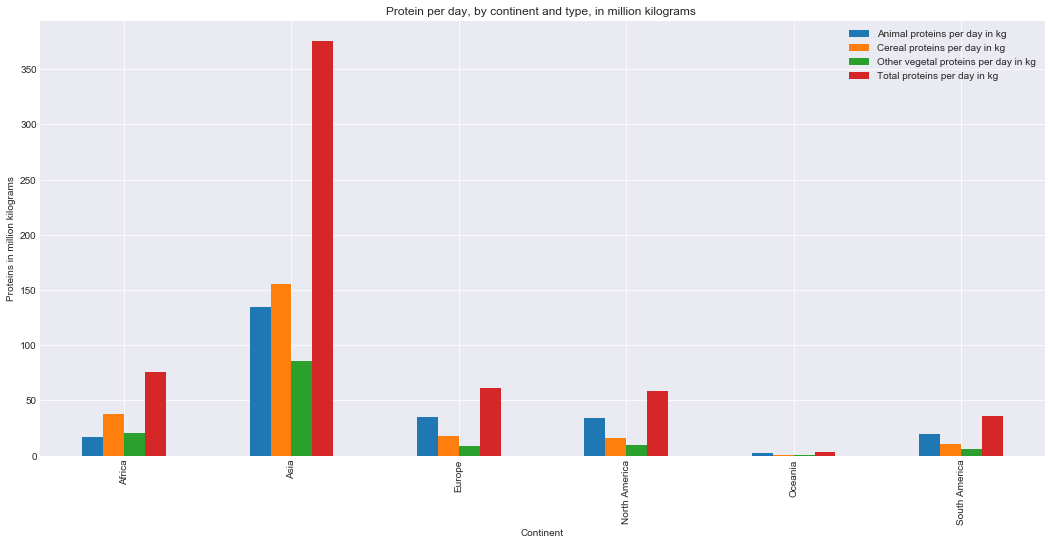

In [154]:
(total_proteins_bycontinent/1000000).plot(kind="bar")
plt.title("Protein per day, by continent and type, in million kilograms ")
plt.xlabel("Continent")
plt.ylabel("Proteins in million kilograms")
plt.grid()
plt.show()

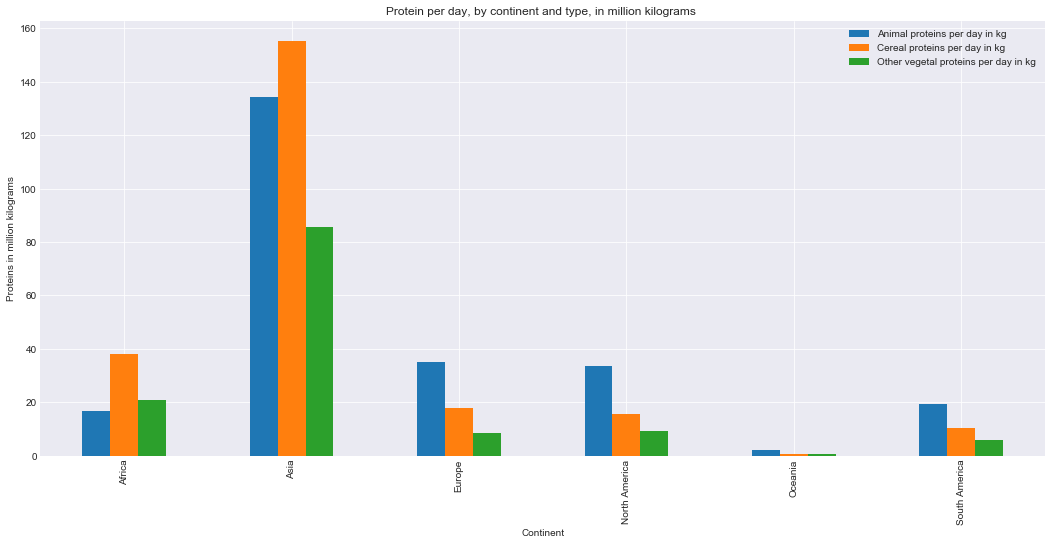

In [155]:
(total_proteins_bycontinent.iloc[:, :-1]/1000000).plot(kind="bar")
plt.title("Protein per day, by continent and type, in million kilograms ")
plt.xlabel("Continent")
plt.ylabel("Proteins in million kilograms")
plt.grid()
plt.show()

We might want to better understand the ratio between each type of food by drawing a proportion stacked bar chart.

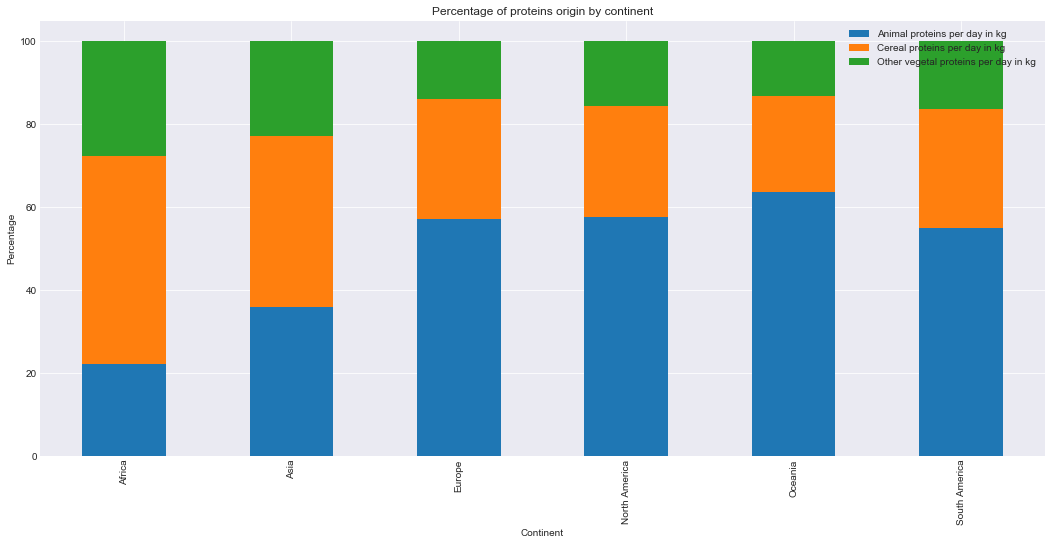

In [156]:
total_proteins_bycontinent.iloc[:, :-1].apply(lambda x: x*100/sum(x), axis=1).plot(kind="bar", stacked=True)
plt.title("Percentage of proteins origin by continent")
plt.xlabel("Continent")
plt.ylabel("Percentage")
plt.grid()
plt.show()

In [157]:
total_proteins_bycontinent

Animal proteins per day in kg  Cereal proteins per day in kg  \
Africa                          1.661588e+07                   3.800635e+07   
Asia                            1.342497e+08                   1.551057e+08   
Europe                          3.518266e+07                   1.773241e+07   
North America                   3.370613e+07                   1.558734e+07   
Oceania                         2.086955e+06                   7.566779e+05   
South America                   1.947266e+07                   1.018405e+07   

               Other vegetal proteins per day in kg  \
Africa                                  20815619.97   
Asia                                    85739692.85   
Europe                                   8613953.97   
North America                            9121709.22   
Oceania                                   430767.44   
South America                            5786616.65   

               Total proteins per day in kg  
Africa                         7.543785e+07  
Asia                           3.750951e+08  
Europe                         6.152903e+07  
North America                  5.841518e+07  
Oceania                        3.274401e+06  
South America                  3.544332e+07

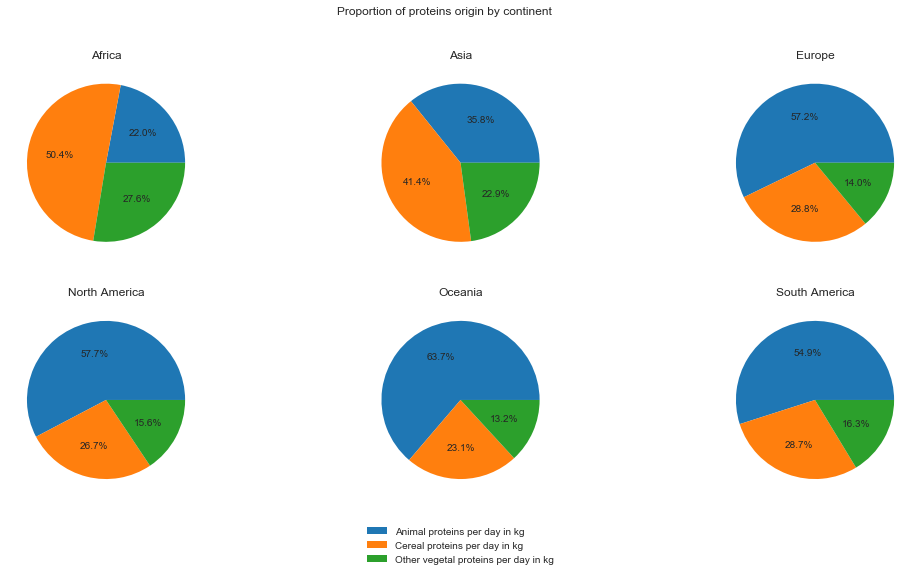

In [158]:
fig, ax = plt.subplots(2,3)

for i in range(6):
    current_ax = ax[i//3,i%3]
    current_ax.pie(data=total_proteins_bycontinent.iloc[:,:-1], 
                   x=total_proteins_bycontinent.iloc[i,:-1].values,
                  labels=None,
                  autopct='%1.1f%%')
    current_ax.set_title(total_proteins_bycontinent.index[i])
fig.suptitle("Proportion of proteins origin by continent")
fig.legend(total_proteins_bycontinent.columns[:-1], loc='lower center')
plt.show()

We can also show piecharts of each continent supply in proportion to the global supply

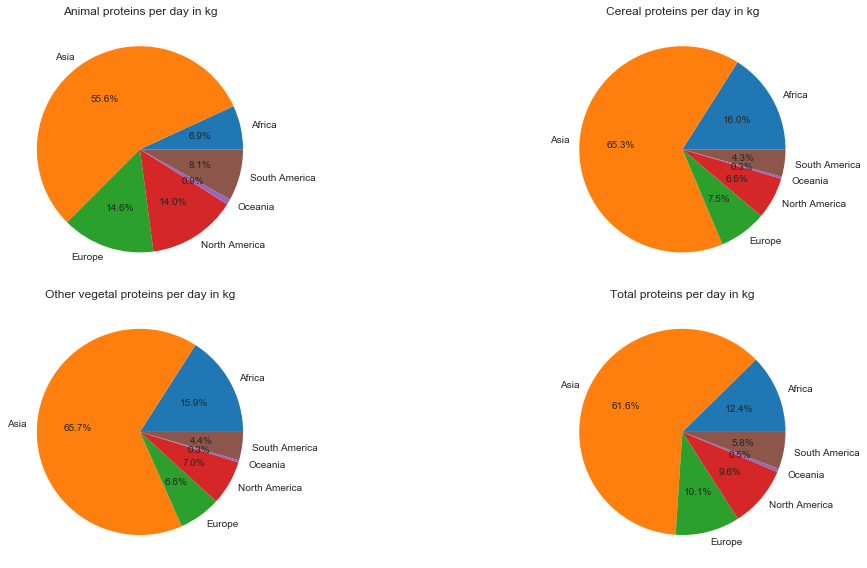

In [159]:
fig, ax = plt.subplots(2,2)

for i in range(4):
    current_ax = ax[i//2,i%2]
    current_ax.pie(data=total_proteins_bycontinent, 
                   x=total_proteins_bycontinent.columns[i],
                  labels=total_proteins_bycontinent.index,
                  autopct='%1.1f%%')
    current_ax.set_title(total_proteins_bycontinent.columns[i],)
plt.tight_layout()
plt.show()

[Go to the top](#start)

### Kilocalories <a name="stat_question_1b"></a>

We can simply mimic what we have done with proteins.

In [160]:
df_products.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

In [161]:
df_products[(df_products.Element == "Food supply (kcal/capita/day)")&(df_products.Year==2017)].Unit.unique()

array(['kcal/capita/day'], dtype=object)

Here again, one unique unit, which is most convenient.

We will do all the figures preparation in one cell. Here it is :

In [162]:
kcals_df = None
named_df = [("Animals", df_animals), ("Cereals", df_cereals), ("Other vegetal", df_vegetal)]
for name, df in named_df:
    if kcals_df is None :
        kcals_df = df[(df.Element == "Food supply (kcal/capita/day)") & (df.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].merge(df_population[(df_population.Year == 2017) & (df_population.Element == "Total Population - Both sexes")].loc[:,["Area","Value"]], on="Area").rename(columns={"Value_x":"%s kcals per capita per day"%name, "Value_y": "Total population in thousands"})
    else :
        kcals_df = df[(df.Element == "Food supply (kcal/capita/day)") & (df.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].rename(columns={"Value":"%s kcals per capita per day"%name}).merge(kcals_df, on="Area")
#         kcals_df["%s kcals per capita per day"%name] = df[(df.Element == "Food supply (kcal/capita/day)") & (df.Year == 2017)].groupby("Area").sum().reset_index().loc[:, ["Area","Value"]].merge(df_population[(df_population.Year == 2017) & (df_population.Element == "Total Population - Both sexes")].loc[:,["Area","Value"]], on="Area").rename(columns={"Value_x":"%s kcals per capita per day"%name, "Value_y": "Total population in thousands"})
    kcals_df["%s kcals per day"%name]=kcals_df["%s kcals per capita per day"%name]*kcals_df["Total population in thousands"]

kcals_df["Total kcals per day"]=kcals_df.loc[:, ["%s kcals per day"%name for name,_ in named_df]].sum(axis=1)
kcals_bycontinent = kcals_df.set_index("Area").groupby(continent_dict).sum().sort_index()
kcals_bycontinent

Other vegetal kcals per capita per day  \
Africa                                        48620.0   
Asia                                          38803.0   
Europe                                        52489.0   
North America                                 29055.0   
Oceania                                       12452.0   
South America                                 14264.0   

               Cereals kcals per capita per day  \
Africa                                  55449.0   
Asia                                    54147.0   
Europe                                  38017.0   
North America                           22028.0   
Oceania                                  7819.0   
South America                           12868.0   

               Animals kcals per capita per day  \
Africa                                  10178.0   
Asia                                    19007.0   
Europe                                  37852.0   
North America                           13440.0   
Oceania                                  5857.0   
South America                            6877.0   

               Total population in thousands  Animals kcals per day  \
Africa                               1112623           2.192160e+08   
Asia                                 4615191           2.215834e+09   
Europe                                600522           5.832338e+08   
North America                         573560           4.835475e+08   
Oceania                                31946           3.115826e+07   
South America                         419620           3.016994e+08   

               Cereals kcals per day  Other vegetal kcals per day  \
Africa                  1.447637e+09                 1.220163e+09   
Asia                    6.620001e+09                 4.295164e+09   
Europe                  5.901305e+08                 8.649775e+08   
North America           5.688375e+08                 9.418490e+08   
Oceania                 2.567336e+07                 4.664721e+07   
South America           4.216993e+08                 5.573619e+08   

               Total kcals per day  
Africa                2.887017e+09  
Asia                  1.313100e+10  
Europe                2.038342e+09  
North America         1.994234e+09  
Oceania               1.034788e+08  
South America         1.280761e+09

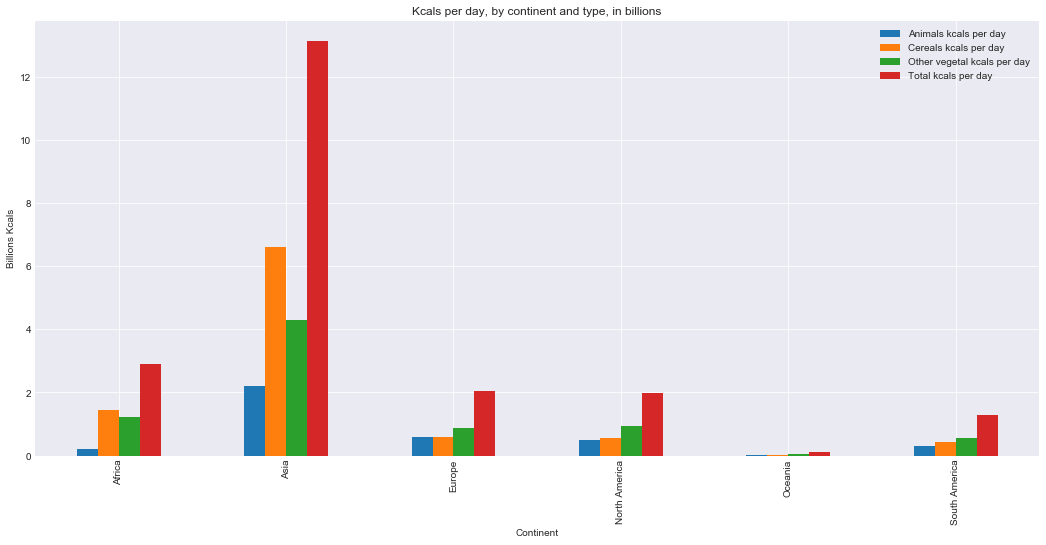

In [163]:
(kcals_bycontinent.loc[:, ["%s kcals per day"%name for name,_ in named_df]+["Total kcals per day"]]/1e9).plot(kind="bar")
plt.title("Kcals per day, by continent and type, in billions")
plt.xlabel("Continent")
plt.ylabel("Billions Kcals")
plt.grid()
plt.show()

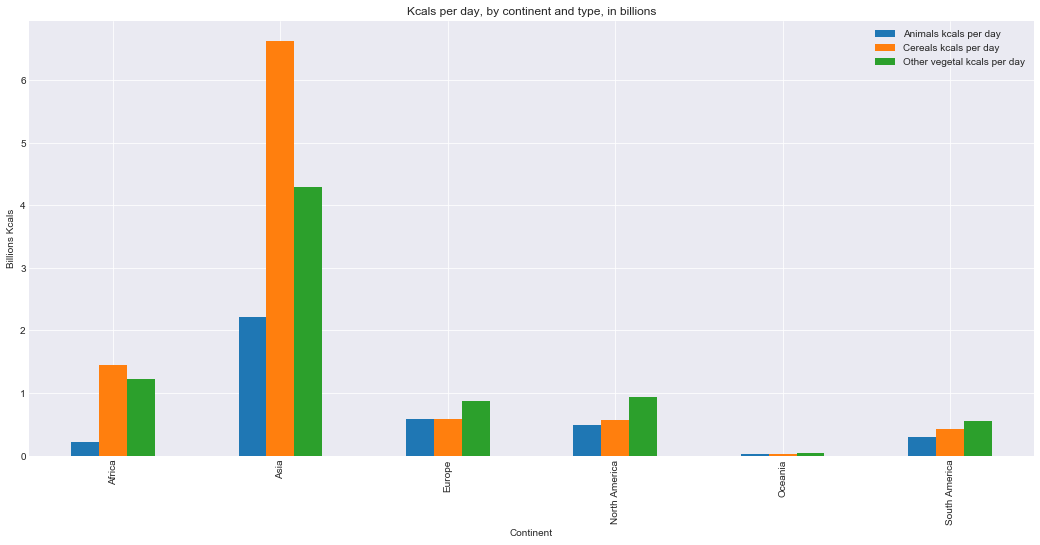

In [164]:
(kcals_bycontinent.loc[:, ["%s kcals per day"%name for name,_ in named_df]]/1e9).plot(kind="bar")
plt.title("Kcals per day, by continent and type, in billions")
plt.xlabel("Continent")
plt.ylabel("Billions Kcals")
plt.grid()
plt.show()

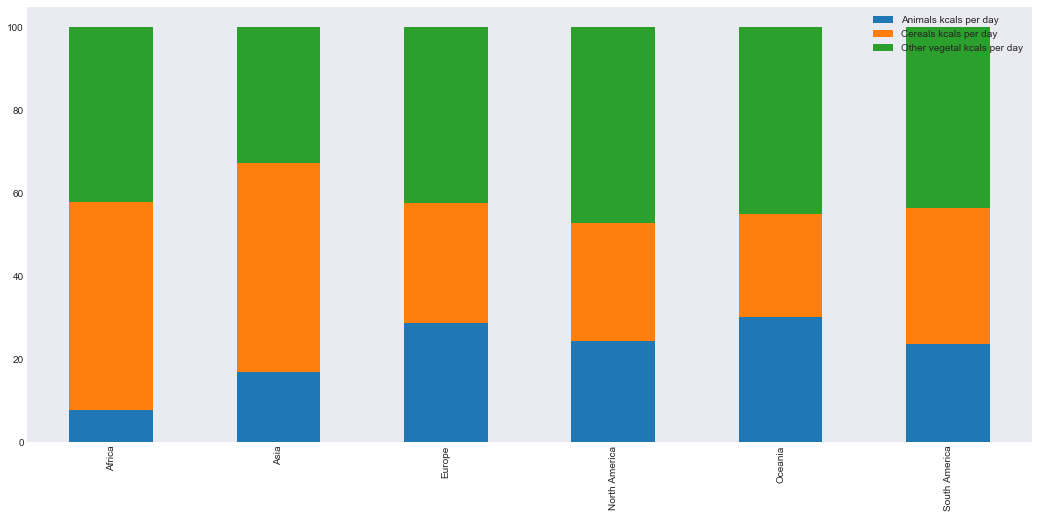

In [165]:
kcals_bycontinent.loc[:, ["%s kcals per day"%name for name,_ in named_df]].apply(lambda x: x*100/sum(x), axis=1).plot(kind="bar", stacked=True)
plt.show()

In [166]:
kcals_bycontinent

Other vegetal kcals per capita per day  \
Africa                                        48620.0   
Asia                                          38803.0   
Europe                                        52489.0   
North America                                 29055.0   
Oceania                                       12452.0   
South America                                 14264.0   

               Cereals kcals per capita per day  \
Africa                                  55449.0   
Asia                                    54147.0   
Europe                                  38017.0   
North America                           22028.0   
Oceania                                  7819.0   
South America                           12868.0   

               Animals kcals per capita per day  \
Africa                                  10178.0   
Asia                                    19007.0   
Europe                                  37852.0   
North America                           13440.0   
Oceania                                  5857.0   
South America                            6877.0   

               Total population in thousands  Animals kcals per day  \
Africa                               1112623           2.192160e+08   
Asia                                 4615191           2.215834e+09   
Europe                                600522           5.832338e+08   
North America                         573560           4.835475e+08   
Oceania                                31946           3.115826e+07   
South America                         419620           3.016994e+08   

               Cereals kcals per day  Other vegetal kcals per day  \
Africa                  1.447637e+09                 1.220163e+09   
Asia                    6.620001e+09                 4.295164e+09   
Europe                  5.901305e+08                 8.649775e+08   
North America           5.688375e+08                 9.418490e+08   
Oceania                 2.567336e+07                 4.664721e+07   
South America           4.216993e+08                 5.573619e+08   

               Total kcals per day  
Africa                2.887017e+09  
Asia                  1.313100e+10  
Europe                2.038342e+09  
North America         1.994234e+09  
Oceania               1.034788e+08  
South America         1.280761e+09

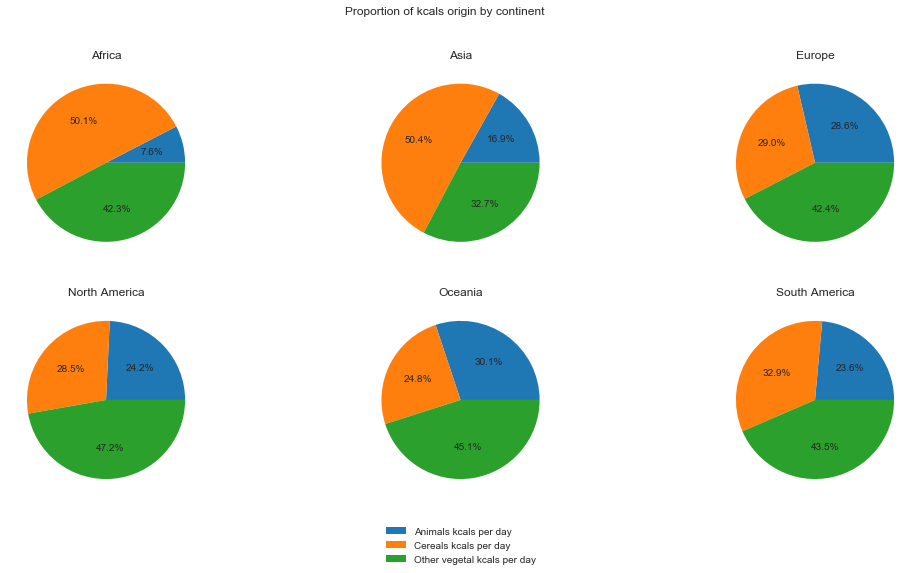

In [167]:
fig, ax = plt.subplots(2,3)

for i in range(6):
    current_ax = ax[i//3,i%3]
    current_ax.pie(data=kcals_bycontinent.iloc[:,4:7], 
                   x=kcals_bycontinent.iloc[i,4:7].values,
                  labels=None,
                  autopct='%1.1f%%')
    current_ax.set_title(kcals_bycontinent.index[i],)
plt.suptitle("Proportion of kcals origin by continent")
fig.legend(kcals_bycontinent.columns[4:7], loc='lower center')
plt.show()

In [168]:
kcals_bycontinent

Other vegetal kcals per capita per day  \
Africa                                        48620.0   
Asia                                          38803.0   
Europe                                        52489.0   
North America                                 29055.0   
Oceania                                       12452.0   
South America                                 14264.0   

               Cereals kcals per capita per day  \
Africa                                  55449.0   
Asia                                    54147.0   
Europe                                  38017.0   
North America                           22028.0   
Oceania                                  7819.0   
South America                           12868.0   

               Animals kcals per capita per day  \
Africa                                  10178.0   
Asia                                    19007.0   
Europe                                  37852.0   
North America                           13440.0   
Oceania                                  5857.0   
South America                            6877.0   

               Total population in thousands  Animals kcals per day  \
Africa                               1112623           2.192160e+08   
Asia                                 4615191           2.215834e+09   
Europe                                600522           5.832338e+08   
North America                         573560           4.835475e+08   
Oceania                                31946           3.115826e+07   
South America                         419620           3.016994e+08   

               Cereals kcals per day  Other vegetal kcals per day  \
Africa                  1.447637e+09                 1.220163e+09   
Asia                    6.620001e+09                 4.295164e+09   
Europe                  5.901305e+08                 8.649775e+08   
North America           5.688375e+08                 9.418490e+08   
Oceania                 2.567336e+07                 4.664721e+07   
South America           4.216993e+08                 5.573619e+08   

               Total kcals per day  
Africa                2.887017e+09  
Asia                  1.313100e+10  
Europe                2.038342e+09  
North America         1.994234e+09  
Oceania               1.034788e+08  
South America         1.280761e+09

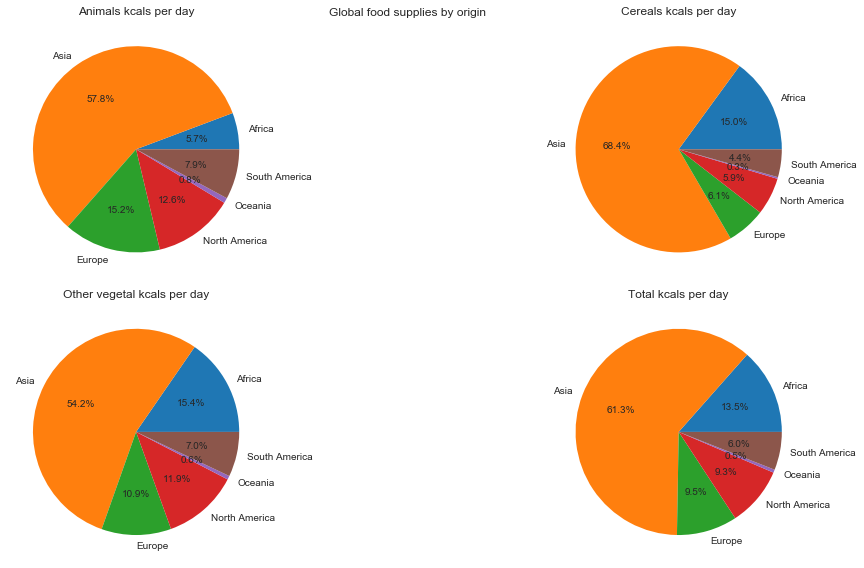

In [169]:
fig, ax = plt.subplots(2,2)

for i in range(4):
    current_ax = ax[i//2,i%2]
    current_ax.pie(data=kcals_bycontinent.iloc[:,4:8], 
                   x=kcals_bycontinent.columns[4+i],
                  labels=kcals_bycontinent.index,
                  autopct='%1.1f%%')
    current_ax.set_title(kcals_bycontinent.columns[4+i],)
plt.tight_layout()
plt.suptitle("Global food supplies by origin")
plt.show()

[Go to the top](#start)

## Energy / weight ratio  and protein/weight ratio of each product <a name="stat_question_2"></a>

For both ratios, we need to convert quantities per day to quantities per year. For that, we will multiply by 365.2422. From here, the ratios  are quite easy to deduce. For each item :
    - ratio energy/weight (kcal/kg) = 'Food supply (kcal/capita/day)' * 365.2422 / 'Food supply quantity (kg/capita/yr)'
    - ratio protein/weight (%)= 'Protein supply quantity (g/capita/day)' * 36.52422 / 'Food supply quantity (kg/capita/yr)' ( "* 36.52422" means here "* 100 / 1000 * 365.2422")
    
It should't depend on the country and year we choose. We should get similar ratios for each item on the whole dataset. Let's verify that using *pivot tables*.

**Nota bene** When dividing two tables of the same dimension and having the same indices, pandas does en element by element division.
Example:

In [170]:
display(pd.DataFrame([[1,2],[2,4]]))
display(pd.DataFrame([[1,4],[4,16]]))
display(pd.DataFrame([[1,2],[2,4]])/pd.DataFrame([[1,4],[4,16]]))

0  1
0  1  2
1  2  4

0   1
0  1   4
1  4  16

0     1
0  1.0  0.50
1  0.5  0.25

In [171]:
df_byelement = df_products.loc[:,["Area","Item","Element","Year", "Value"]].pivot_table(index="Item", columns=["Element","Year","Area"], values="Value")
df_byelement

Element                 Domestic supply quantity                          \
Year                                        2014                           
Area                                 Afghanistan Albania Algeria  Angola   
Item                                                                       
Alcohol, Non-Food                            0.0     0.0     0.0    33.0   
Apples and products                         78.0    87.0   616.0    48.0   
Aquatic Animals, Others                      NaN     0.0     0.0     0.0   
Aquatic Plants                               NaN     0.0     0.0     0.0   
Bananas                                     64.0    17.0   264.0  3483.0   
...                                          ...     ...     ...     ...   
Tomatoes and products                       -2.0   206.0  1220.0   151.0   
Vegetables, Other                         1396.0   599.0  5121.0   760.0   
Wheat and products                        6697.0   479.0  9778.0   851.0   
Wine                                         0.0    25.0    54.0   102.0   
Yams                                         0.0     NaN     NaN     0.0   

Element                                                                  \
Year                                                                      
Area                    Antigua and Barbuda Argentina Armenia Australia   
Item                                                                      
Alcohol, Non-Food                       0.0      34.0    10.0      42.0   
Apples and products                     1.0     685.0   109.0     311.0   
Aquatic Animals, Others                 NaN       0.0     0.0       2.0   
Aquatic Plants                          0.0       1.0     0.0      10.0   
Bananas                                 1.0     587.0     4.0     255.0   
...                                     ...       ...     ...       ...   
Tomatoes and products                   1.0     683.0   299.0     431.0   
Vegetables, Other                       6.0    1913.0   942.0    1534.0   
Wheat and products                      7.0    5083.0   639.0    7239.0   
Wine                                    1.0    1125.0     4.0     519.0   
Yams                                    0.0       NaN     NaN       1.0   

Element                                     ... Tourist consumption           \
Year                                        ...                2017            
Area                    Austria Azerbaijan  ...          Tajikistan Thailand   
Item                                        ...                                
Alcohol, Non-Food         -26.0        1.0  ...                 NaN      NaN   
Apples and products       333.0      161.0  ...                 NaN      0.0   
Aquatic Animals, Others     0.0        0.0  ...                 NaN      NaN   
Aquatic Plants              1.0        0.0  ...                 NaN      NaN   
Bananas                   102.0        8.0  ...                 NaN      NaN   
...                         ...        ...  ...                 ...      ...   
Tomatoes and products     135.0      426.0  ...                 0.0      0.0   
Vegetables, Other         691.0      979.0  ...                 NaN      0.0   
Wheat and products       1432.0     2829.0  ...                 0.0      0.0   
Wine                      279.0        5.0  ...                 0.0      0.0   
Yams                        0.0        NaN  ...                 NaN      0.0   

Element                                             \
Year                                                 
Area                    Trinidad and Tobago Uganda   
Item                                                 
Alcohol, Non-Food                       NaN    NaN   
Apples and products                     0.0    0.0   
Aquatic Animals, Others                 NaN    NaN   
Aquatic Plants                          NaN    NaN   
Bananas                                 0.0    0.0   
...                                     ...   

Now that we have isolated each value we need, let's first calculate the enery/weight.

In [172]:
energyweight_df = df_byelement["Food supply (kcal/capita/day)"]*365.2422/df_byelement["Food supply quantity (kg/capita/yr)"]
energyweight_df.replace(np.inf, np.nan, inplace=True)
energyweight_df

Year                            2014                                         \
Area                     Afghanistan      Albania      Algeria       Angola   
Item                                                                          
Alcohol, Non-Food                NaN          NaN          NaN          NaN   
Apples and products       547.863300   495.685843   495.685843   730.484400   
Aquatic Animals, Others          NaN          NaN          NaN          NaN   
Aquatic Plants                   NaN          NaN          NaN          NaN   
Bananas                  1095.726600   657.435960   608.737000   721.119215   
...                              ...          ...          ...          ...   
Tomatoes and products            NaN   176.730097   221.754193   219.145320   
Vegetables, Other         256.656681   226.858509   250.717103   289.150075   
Wheat and products       3142.505942  2801.967534  2819.826877  2686.297471   
Wine                             NaN   730.484400          NaN   852.231800   
Yams                             NaN          NaN          NaN          NaN   

Year                                                                   \
Area                    Antigua and Barbuda    Argentina      Armenia   
Item                                                                    
Alcohol, Non-Food                       NaN          NaN          NaN   
Apples and products              608.737000   477.624415   491.672192   
Aquatic Animals, Others                 NaN          NaN          NaN   
Aquatic Plants                          NaN          NaN          NaN   
Bananas                          608.737000   646.197738   730.484400   
...                                     ...          ...          ...   
Tomatoes and products            324.659733   234.798557   170.711028   
Vegetables, Other                311.977712   288.349105   217.406071   
Wheat and products              3087.437972  3113.254943  2919.128045   
Wine                             949.629720   700.047550   730.484400   
Yams                            1095.726600          NaN          NaN   

Year                                                            ...  \
Area                       Australia      Austria   Azerbaijan  ...   
Item                                                            ...   
Alcohol, Non-Food                NaN          NaN          NaN  ...   
Apples and products       547.863300   440.439124   498.057545  ...   
Aquatic Animals, Others          NaN          NaN          NaN  ...   
Aquatic Plants                   NaN          NaN          NaN  ...   
Bananas                   730.484400   630.872891          NaN  ...   
...                              ...          ...          ...  ...   
Tomatoes and products     251.104013   313.064743   174.320141  ...   
Vegetables, Other         324.005177   271.322777   204.221445  ...   
Wheat and products       2936.355055  2968.117648  3196.352375  ...   
Wine                      708.999565   695.138381          NaN  ...   
Yams                             NaN          NaN          NaN  ...   

Year                                           2017                           \
Area                    United Republic of Tanzania United States of America   
Item                                                                           
Alcohol, Non-Food                               NaN                      NaN   
Apples and products                             NaN               880.878247   
Aquatic Animals, Others                         NaN                      NaN   
Aquatic Plants                                  NaN                      NaN   
Bananas                                  605.970014               664.076727   
...                                             ...                      ...   
Tomatoes and products                    202.912333               171.207281   
Vegetables, Other                        251.104013               238.20143

We can see very inconsistent values here, across coutnries and years. We might take the mean for each product.

In [173]:
energyweight_df.mean(axis=1)

Item
Alcohol, Non-Food                  NaN
Apples and products         639.592794
Aquatic Animals, Others     319.586925
Aquatic Plants              372.547044
Bananas                     674.642827
                              ...     
Tomatoes and products       273.449592
Vegetables, Other           279.272223
Wheat and products         3025.336377
Wine                        810.419870
Yams                       1082.688469
Length: 98, dtype: float64

Now let's do the same with protein/weight ratio :

In [174]:
proteinweight_df = df_byelement["Protein supply quantity (g/capita/day)"]*36.52422/df_byelement["Food supply quantity (kg/capita/yr)"]
proteinweight_df.replace(np.inf, np.nan, inplace=True)
proteinweight_df

Year                           2014                                \
Area                    Afghanistan   Albania   Algeria    Angola   
Item                                                                
Alcohol, Non-Food               NaN       NaN       NaN       NaN   
Apples and products        0.000000  0.000000  0.000000  0.000000   
Aquatic Animals, Others         NaN       NaN       NaN       NaN   
Aquatic Plants                  NaN       NaN       NaN       NaN   
Bananas                    0.000000  0.000000  0.000000  0.936518   
...                             ...       ...       ...       ...   
Tomatoes and products           NaN  0.589100  0.000000  0.000000   
Vegetables, Other          0.987141  0.907434  0.928582  1.521842   
Wheat and products         8.300959  8.797805  8.443771  7.069204   
Wine                            NaN  0.000000       NaN  0.000000   
Yams                            NaN       NaN       NaN       NaN   

Year                                                                       \
Area                    Antigua and Barbuda Argentina   Armenia Australia   
Item                                                                        
Alcohol, Non-Food                       NaN       NaN       NaN       NaN   
Apples and products                0.000000  0.000000  0.000000  0.000000   
Aquatic Animals, Others                 NaN       NaN       NaN       NaN   
Aquatic Plants                          NaN       NaN       NaN       NaN   
Bananas                            0.000000  0.000000  0.000000  0.000000   
...                                     ...       ...       ...       ...   
Tomatoes and products              0.000000  0.000000  0.794005  0.000000   
Vegetables, Other                  0.760921  0.961164  0.993856  1.178201   
Wheat and products                 7.989673  8.000543  8.428666  9.131055   
Wine                               0.000000  0.000000  0.000000  0.000000   
Yams                               0.000000       NaN       NaN       NaN   

Year                                          ...                        2017  \
Area                      Austria Azerbaijan  ... United Republic of Tanzania   
Item                                          ...                               
Alcohol, Non-Food             NaN        NaN  ...                         NaN   
Apples and products      0.000000   0.000000  ...                         NaN   
Aquatic Animals, Others       NaN        NaN  ...                         NaN   
Aquatic Plants                NaN        NaN  ...                         NaN   
Bananas                  0.000000        NaN  ...                    0.830096   
...                           ...        ...  ...                         ...   
Tomatoes and products    0.000000   0.000000  ...                    0.000000   
Vegetables, Other        1.043549   0.392734  ...                    1.141382   
Wheat and products       9.655828   9.469242  ...                    6.087370   
Wine                     0.000000        NaN  ...                         NaN   
Yams                          NaN        NaN  ...                         NaN   

Year                                                                   \
Area                    United States of America   Uruguay Uzbekistan   
Item                                                                    
Alcohol, Non-Food                            NaN       NaN        NaN   
Apples and products                     0.000000  0.000000   0.000000   
Aquatic Animals, Others                      NaN       NaN        NaN   
Aquatic Plants                               NaN       NaN        NaN   
Bananas                                 0.000000  0.000000        NaN   
...                                          ...       ...        ...   
Tomatoes and products                   0.000000  0.000000   0.500332   
Vegetables, Other                       1.058673  0.936518   1.055613   
Wheat and produc

In [175]:
proteinweight_df.mean(axis=1)

Item
Alcohol, Non-Food               NaN
Apples and products        0.000000
Aquatic Animals, Others    0.000000
Aquatic Plants             1.562299
Bananas                    0.047435
                             ...   
Tomatoes and products      0.108823
Vegetables, Other          0.782447
Wheat and products         8.005526
Wine                       0.000000
Yams                       0.398669
Length: 98, dtype: float64

Let's store those two ratios in a specific DataFrame, for further uses.

In [176]:
ratios_df = pd.concat([energyweight_df.mean(axis=1),proteinweight_df.mean(axis=1)], axis=1).rename(columns={0:"Energy weight ratio (kcal/kg)", 1:"Protein weight ratio (%)"})
ratios_df

Energy weight ratio (kcal/kg)  \
Item                                                     
Alcohol, Non-Food                                  NaN   
Apples and products                         639.592794   
Aquatic Animals, Others                     319.586925   
Aquatic Plants                              372.547044   
Bananas                                     674.642827   
...                                                ...   
Tomatoes and products                       273.449592   
Vegetables, Other                           279.272223   
Wheat and products                         3025.336377   
Wine                                        810.419870   
Yams                                       1082.688469   

                         Protein weight ratio (%)  
Item                                               
Alcohol, Non-Food                             NaN  
Apples and products                      0.000000  
Aquatic Animals, Others                  0.000000  
Aquatic Plants                           1.562299  
Bananas                                  0.047435  
...                                           ...  
Tomatoes and products                    0.108823  
Vegetables, Other                        0.782447  
Wheat and products                       8.005526  
Wine                                     0.000000  
Yams                                     0.398669  

[98 rows x 2 columns]

Let's check our results. We will use this website : http://apjcn.nhri.org.tw/server/info/books-phds/books/foodfacts/html/data/data2a.html

It tells us that an apple of 100g has 35kcal, which means 350 kcal/kg, and a banana has 800 kcal per kg.

In [177]:
ratios_df.loc[["Apples and products","Bananas"],"Energy weight ratio (kcal/kg)"]

Item
Apples and products    639.592794
Bananas                674.642827
Name: Energy weight ratio (kcal/kg), dtype: float64

As for protein ratios in cereals, this website : https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/oat-protein tells us that
    - oats have 16.9 % protein
    - wheats have 15.4% protein
    - rice has 7.13% protein
    - barley has 12.5% protein
    - rye has 10.3% protein.

In [178]:
ratios_df.loc[["Oats", "Wheat and products", "Rice and products", "Barley and products", "Rye and products"],"Protein weight ratio (%)"]

Item
Oats                   2.272497
Wheat and products     8.005526
Rice and products      3.600561
Barley and products    2.772219
Rye and products       3.337158
Name: Protein weight ratio (%), dtype: float64

[Go to the top](#start)

## Top 5 most calorific aliments  <a name="stat_question_3"></a>

Let's answer very quickly using our ratio dataframe :

In [179]:
ratios_df["Energy weight ratio (kcal/kg)"].sort_values(ascending=False).head(5)

Item
Fats, Animals, Raw      16644.635181
Maize Germ Oil          12162.020495
Rape and Mustard Oil    12024.280027
Sunflowerseed Oil       11700.481377
Palm Oil                11238.325333
Name: Energy weight ratio (kcal/kg), dtype: float64

[Go to the top](#start)

## Top 20 aliments with the highest protein ratio <a name="stat_question_4"></a>

Here again, everything is ready to answer quickly in one line :

In [180]:
ratios_df["Protein weight ratio (%)"].sort_values(ascending=False).head(20)

Item
Soyabeans                     28.120530
Pulses, Other and products    18.820598
Rape and Mustardseed          18.815507
Beans                         16.899605
Peas                          14.721358
Bovine Meat                   12.346888
Meat, Other                   11.933653
Poultry Meat                  10.577730
Offals, Edible                10.191032
Groundnuts (Shelled Eq)        8.777789
Pelagic Fish                   8.633069
Pigmeat                        8.603397
Wheat and products             8.005526
Pepper                         6.956994
Eggs                           6.954631
Mutton & Goat Meat             6.495853
Maize and products             5.300059
Cephalopods                    5.227977
Milk - Excluding Butter        4.717452
Freshwater Fish                4.638675
Name: Protein weight ratio (%), dtype: float64

[Go to the top](#start)

## Availability of vegetal products in kcal <a name="stat_question_5"></a>

In [181]:
df_products.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

Here, we need to take into account all vegetal products, not only the food. We can design a DataFrame similar to the one we got in [Kilocalories](#stat_question_1b), but with the Element "Domestic supply quantity".

In [182]:
df_products[(df_products.Element == "Domestic supply quantity")&(df_products.Year==2017)].Unit.unique()

array(['1000 tonnes'], dtype=object)

The unique unit used here is millions of  kilograms.

In [183]:
energy_vegetal_df = None
energy_vegetal_df = df_cereals[(df_cereals.Element == "Domestic supply quantity") & (df_cereals.Year == 2017)].groupby("Item").sum().reset_index().loc[:, ["Item","Value"]]
print("\nFor cereals :")
display(energy_vegetal_df)
print("\nFor other vegetal products :")
temp_vegetal_df = df_vegetal[(df_vegetal.Element == "Domestic supply quantity") & (df_vegetal.Year == 2017)].groupby("Item").sum().reset_index().loc[:, ["Item","Value"]]
display(temp_vegetal_df)
energy_vegetal_df = pd.concat([energy_vegetal_df, temp_vegetal_df])
del(temp_vegetal_df)
energy_vegetal_df.rename(columns={"Value":"Domestic supply (1000 tons)"}, inplace=True)
print("\nFor all vegetal products :")
display(energy_vegetal_df)


For cereals :


Item      Value
0   Barley and products   137517.0
1        Cereals, Other    31645.0
2    Maize and products  1145035.0
3   Millet and products    27479.0
4                  Oats    25945.0
5     Rice and products   749331.0
6      Rye and products    13061.0
7  Sorghum and products    59542.0
8    Wheat and products   737732.0


For other vegetal products :


Item     Value
0       Alcohol, Non-Food   14184.0
1     Apples and products   80759.0
2                 Bananas  109820.0
3                   Beans   29721.0
4                    Beer  185999.0
..                    ...       ...
61   Tea (including mate)    6751.0
62  Tomatoes and products  171210.0
63      Vegetables, Other  944673.0
64                   Wine   26858.0
65                   Yams   65952.0

[66 rows x 2 columns]


For all vegetal products :


Item  Domestic supply (1000 tons)
0     Barley and products                     137517.0
1          Cereals, Other                      31645.0
2      Maize and products                    1145035.0
3     Millet and products                      27479.0
4                    Oats                      25945.0
..                    ...                          ...
61   Tea (including mate)                       6751.0
62  Tomatoes and products                     171210.0
63      Vegetables, Other                     944673.0
64                   Wine                      26858.0
65                   Yams                      65952.0

[75 rows x 2 columns]

To get our results in kcal, we have to use the kcal/product we just deduce.

This means we have to multiply the domestic supply (in thousand of tons) by the energy/weight ratio, for each product.

$Total\ energy\ disponibility\ (kcal) = Total\ disponibility\ (1000\ tons) * 1e6 * Energy\ weight\ ratio\ (kcal/kg)$

In [184]:
energy_vegetal_df = energy_vegetal_df.merge(ratios_df["Energy weight ratio (kcal/kg)"], on="Item")
energy_vegetal_df

Item  Domestic supply (1000 tons)  \
0     Barley and products                     137517.0   
1          Cereals, Other                      31645.0   
2      Maize and products                    1145035.0   
3     Millet and products                      27479.0   
4                    Oats                      25945.0   
..                    ...                          ...   
70   Tea (including mate)                       6751.0   
71  Tomatoes and products                     171210.0   
72      Vegetables, Other                     944673.0   
73                   Wine                      26858.0   
74                   Yams                      65952.0   

    Energy weight ratio (kcal/kg)  
0                     3330.785753  
1                     4179.086960  
2                     3290.533258  
3                     3576.258024  
4                     3283.659029  
..                            ...  
70                     517.686594  
71                     273.449592  
72                     279.272223  
73                     810.419870  
74                    1082.688469  

[75 rows x 3 columns]

In [185]:
energy_vegetal_df["Domestic energy (kcal)"]=energy_vegetal_df["Domestic supply (1000 tons)"]*1e6*energy_vegetal_df["Energy weight ratio (kcal/kg)"]
energy_vegetal_df

Item  Domestic supply (1000 tons)  \
0     Barley and products                     137517.0   
1          Cereals, Other                      31645.0   
2      Maize and products                    1145035.0   
3     Millet and products                      27479.0   
4                    Oats                      25945.0   
..                    ...                          ...   
70   Tea (including mate)                       6751.0   
71  Tomatoes and products                     171210.0   
72      Vegetables, Other                     944673.0   
73                   Wine                      26858.0   
74                   Yams                      65952.0   

    Energy weight ratio (kcal/kg)  Domestic energy (kcal)  
0                     3330.785753            4.580397e+14  
1                     4179.086960            1.322472e+14  
2                     3290.533258            3.767776e+15  
3                     3576.258024            9.827199e+13  
4                     3283.659029            8.519453e+13  
..                            ...                     ...  
70                     517.686594            3.494902e+12  
71                     273.449592            4.681730e+13  
72                     279.272223            2.638209e+14  
73                     810.419870            2.176626e+13  
74                    1082.688469            7.140547e+13  

[75 rows x 4 columns]

In [186]:
def prefix(x):
    prefixes = ["Kilo", "Mega", "Giga", "Tera", "Peta", "Exa", "Zeta"]
    power = int(min(math.log10(x)//3, 6))
    return (x/10**(3*power), prefixes[power])

In [187]:
world_vegetal_cals=energy_vegetal_df["Domestic energy (kcal)"].sum()*1000
print("The total domestic availability in energy with all vegetal products is %f %scalories (%s Kilocalories)."%(*prefix(world_vegetal_cals), f'{world_vegetal_cals//1000:,}'))

The total domestic availability in energy with all vegetal products is 17.736593 Zetacalories (1.7736593275546826e+16 Kilocalories).


Here is an overview of numeric prefixes of the **International System of Units (SI)** as a reminder :

In [188]:
pd.DataFrame(["1%s (1e%i)"%(",000"*x, 3*x) for x in range(1,8)],
             ["Kilo", "Mega", "Giga", "Tera", "Peta", "Exa", "Zeta"]).rename(columns={0:"Multiplicator"})

Multiplicator
Kilo                           1,000 (1e3)
Mega                       1,000,000 (1e6)
Giga                   1,000,000,000 (1e9)
Tera              1,000,000,000,000 (1e12)
Peta          1,000,000,000,000,000 (1e15)
Exa       1,000,000,000,000,000,000 (1e18)
Zeta  1,000,000,000,000,000,000,000 (1e21)

The domestic supply given in this FAO dataset is expressed per year.

[Go to the top](#start)

## How many people could be fed if all vegetal products were used to feed ?<a name="stat_question_6"></a>

This website https://www.nhs.uk/common-health-questions/food-and-diet/what-should-my-daily-intake-of-calories-be/ tells us that men need 2000 Kilocalories per day, and men need 2500 Kilocalories per day.

This website https://ourworldindata.org/gender-ratio gives us a women/total gender ratio of 49.6%.

In [189]:
kcals_perday_needed = (0.496*2000+(1-0.492)*2500)
print("Therefore, the average energy needed per person is %.0f Kilocalories."%kcals_perday_needed)

Therefore, the average energy needed per person is 2262 Kilocalories.


As for proteins, this website https://www.healthline.com/nutrition/how-much-protein-per-day tells us an average man needs 56 grams of proteins per day, and an average woman needs 46 grams of proteins per day.

In [190]:
proteins_perday_needed = (0.496*56+(1-0.492)*46)
print("Therefore, the average proteins intake needed per person is %.3f grams."%proteins_perday_needed)

Therefore, the average proteins intake needed per person is 51.144 grams.


Let's consider the ratio men/women never changes, from now. Let's also not forget to convert 1 Kilocalory = 1,000 calories.

In [191]:
vegetal_energy_feedable_population = world_vegetal_cals/1000/365.2422/kcals_perday_needed
print("%s people could be fed with the whole world vegetal products supply in energy."%f'{int(vegetal_energy_feedable_population):,}')

21,468,250,617 people could be fed with the whole world vegetal products supply in energy.


In [192]:
world_population = 7791594000

From this website : https://www.worldometers.info/world-population/ , there are currently 7'791'594'000 people on Earth.

In [193]:
print("%f %% of the world population could be fed with the vegetal products supply in energy alone."%(vegetal_energy_feedable_population*100/world_population))

275.530920 % of the world population could be fed with the vegetal products supply in energy alone.


Let's do a similar calculation for the protein supplies.

$Total\ protein\ disponibility\ (kg) = Total\ disponibility\ (1000\ tons) * 10000 * Protein\ weight\ ratio\ (\%)$

10000 comes from :
    - the conversion  1000tons => kg with a 1,000,000 factor
    - the conversion % => ratio by dividing by 100

In [194]:
energy_vegetal_df = energy_vegetal_df.merge(ratios_df["Protein weight ratio (%)"], on="Item")
energy_vegetal_df["Domestic proteins (kg)"]=energy_vegetal_df["Domestic supply (1000 tons)"]*1e4*energy_vegetal_df["Protein weight ratio (%)"]
energy_vegetal_df

Item  Domestic supply (1000 tons)  \
0     Barley and products                     137517.0   
1          Cereals, Other                      31645.0   
2      Maize and products                    1145035.0   
3     Millet and products                      27479.0   
4                    Oats                      25945.0   
..                    ...                          ...   
70   Tea (including mate)                       6751.0   
71  Tomatoes and products                     171210.0   
72      Vegetables, Other                     944673.0   
73                   Wine                      26858.0   
74                   Yams                      65952.0   

    Energy weight ratio (kcal/kg)  Domestic energy (kcal)  \
0                     3330.785753            4.580397e+14   
1                     4179.086960            1.322472e+14   
2                     3290.533258            3.767776e+15   
3                     3576.258024            9.827199e+13   
4                     3283.659029            8.519453e+13   
..                            ...                     ...   
70                     517.686594            3.494902e+12   
71                     273.449592            4.681730e+13   
72                     279.272223            2.638209e+14   
73                     810.419870            2.176626e+13   
74                    1082.688469            7.140547e+13   

    Protein weight ratio (%)  Domestic proteins (kg)  
0                   2.772219            3.812272e+09  
1                   1.537679            4.865984e+08  
2                   5.300059            6.068752e+10  
3                   2.700312            7.420187e+08  
4                   2.272497            5.895994e+08  
..                       ...                     ...  
70                  0.848069            5.725317e+07  
71                  0.108823            1.863158e+08  
72                  0.782447            7.391565e+09  
73                  0.000000            0.000000e+00  
74                  0.398669            2.629303e+08  

[75 rows x 6 columns]

In [195]:
world_vegetal_proteins=energy_vegetal_df["Domestic proteins (kg)"].sum()
print("The total domestic availability in proteins with all vegetal products is %f %sgrams (%s Kilograms)."%(*prefix(world_vegetal_proteins), f'{world_vegetal_proteins//1000:,}'))
proteins_feedable_population = world_vegetal_proteins/365.2422*1000/proteins_perday_needed
print("%s people could be fed with the whole world vegetal products supply in proteins, which represents %.2f%% of the current world population."%(f'{int(proteins_feedable_population):,}', proteins_feedable_population*100/world_population))

The total domestic availability in proteins with all vegetal products is 298.683965 Teragrams (298,683,964.0 Kilograms).
15,989,550,900 people could be fed with the whole world vegetal products supply in proteins, which represents 205.22% of the current world population.


[Go to the top](#start)

## How many people could be fed with all vegetal food for humans and animals, and all vegetal losses ?<a name="stat_question_7"></a>

First, let's gather the figures for all the related products.

In [196]:
df_products.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

We want (with extracts from fao.org) : 
    - food : Data refer to the total amount of the commodity available as human food during the reference period. 
    - feed : Data refer to the quantity of the commodity in question available for feeding to the livestock and poultry during the reference period.
    - losses : Amount of the commodity in question lost through wastage (waste) during the year.

In [197]:
element_mask=["Food", "Feed", "Losses"]
df_products[df_products.Element.isin(element_mask)].Unit.unique()

array(['1000 tonnes'], dtype=object)

Here again, it is convenient to have one single unit to deal with.

We can simply sum the amount for each products, and do the same as usual thanks to our ratios dataframe.

First, let's select the need data and tidy it.

In [198]:
vegetalideal = pd.concat([df_cereals[(df_cereals.Year==2017)&(df_cereals.Element.isin(element_mask))], df_vegetal[(df_vegetal.Year==2017)&(df_vegetal.Element.isin(element_mask))]]).loc[:,["Area","Item","Element", "Value"]].pivot_table(index="Item", columns=["Element","Area"], values="Value").fillna(0).sum(axis=1)
vegetalideal

Item
Alcohol, Non-Food             0.0
Apples and products       70643.0
Bananas                  105725.0
Barley and products      100212.0
Beans                     28136.0
                           ...   
Tomatoes and products    171143.0
Vegetables, Other        946273.0
Wheat and products       660658.0
Wine                      23144.0
Yams                      45926.0
Length: 75, dtype: float64

Now, we use our ratios dataframe.

In [199]:
vegetalideal_df = pd.DataFrame(vegetalideal, columns=["Total supply (1000 tons)"]).join(ratios_df)
vegetalideal_df

Total supply (1000 tons)  \
Item                                              
Alcohol, Non-Food                           0.0   
Apples and products                     70643.0   
Bananas                                105725.0   
Barley and products                    100212.0   
Beans                                   28136.0   
...                                         ...   
Tomatoes and products                  171143.0   
Vegetables, Other                      946273.0   
Wheat and products                     660658.0   
Wine                                    23144.0   
Yams                                    45926.0   

                       Energy weight ratio (kcal/kg)  Protein weight ratio (%)  
Item                                                                            
Alcohol, Non-Food                                NaN                       NaN  
Apples and products                       639.592794                  0.000000  
Bananas                                   674.642827                  0.047435  
Barley and products                      3330.785753                  2.772219  
Beans                                    4228.405961                 16.899605  
...                                              ...                       ...  
Tomatoes and products                     273.449592                  0.108823  
Vegetables, Other                         279.272223                  0.782447  
Wheat and products                       3025.336377                  8.005526  
Wine                                      810.419870                  0.000000  
Yams                                     1082.688469                  0.398669  

[75 rows x 3 columns]

In [200]:
vegetalideal_df["Total supply energy (kcal)"]=vegetalideal_df["Total supply (1000 tons)"]*1e6*vegetalideal_df["Energy weight ratio (kcal/kg)"]
vegetalideal_df["Total supply proteins (kg)"]=vegetalideal_df["Total supply (1000 tons)"]*1e4*vegetalideal_df["Protein weight ratio (%)"]
vegetalideal_df

Total supply (1000 tons)  \
Item                                              
Alcohol, Non-Food                           0.0   
Apples and products                     70643.0   
Bananas                                105725.0   
Barley and products                    100212.0   
Beans                                   28136.0   
...                                         ...   
Tomatoes and products                  171143.0   
Vegetables, Other                      946273.0   
Wheat and products                     660658.0   
Wine                                    23144.0   
Yams                                    45926.0   

                       Energy weight ratio (kcal/kg)  \
Item                                                   
Alcohol, Non-Food                                NaN   
Apples and products                       639.592794   
Bananas                                   674.642827   
Barley and products                      3330.785753   
Beans                                    4228.405961   
...                                              ...   
Tomatoes and products                     273.449592   
Vegetables, Other                         279.272223   
Wheat and products                       3025.336377   
Wine                                      810.419870   
Yams                                     1082.688469   

                       Protein weight ratio (%)  Total supply energy (kcal)  \
Item                                                                          
Alcohol, Non-Food                           NaN                         NaN   
Apples and products                    0.000000                4.518275e+13   
Bananas                                0.047435                7.132661e+13   
Barley and products                    2.772219                3.337847e+14   
Beans                                 16.899605                1.189704e+14   
...                                         ...                         ...   
Tomatoes and products                  0.108823                4.679898e+13   
Vegetables, Other                      0.782447                2.642678e+14   
Wheat and products                     8.005526                1.998713e+15   
Wine                                   0.000000                1.875636e+13   
Yams                                   0.398669                4.972355e+13   

                       Total supply proteins (kg)  
Item                                               
Alcohol, Non-Food                             NaN  
Apples and products                  0.000000e+00  
Bananas                              5.015079e+07  
Barley and products                  2.778096e+09  
Beans                                4.754873e+09  
...                                           ...  
Tomatoes and products                1.862429e+08  
Vegetables, Other                    7.404084e+09  
Wheat and products                   5.288915e+10  
Wine                                 0.000000e+00  
Yams                                 1.830928e+08  

[75 rows x 5 columns]

**Nota Bene** : here again, the 10,000 factor comes from :
    - the conversion  1000tons => kg with a 1,000,000 factor
    - the conversion % => ratio by dividing by 100

In [201]:
ideal_vegetal_energy=vegetalideal_df["Total supply energy (kcal)"].sum()
ideal_energy_population=ideal_vegetal_energy/365.2422/kcals_perday_needed
ideal_vegetal_proteins=vegetalideal_df["Total supply proteins (kg)"].sum()
ideal_protein_population=ideal_vegetal_proteins/365.2422*1000/proteins_perday_needed #kg to grams conversion => factor or 1,000
print("The total availability in energy with all vegetal food (including wastes and feeds) is %f %scalories (%s Kilocalories)."%(*prefix(ideal_vegetal_energy*1000), f'{ideal_vegetal_energy:,}'))
print("%s people could be fed with those vegetal products in terms of energy, which represents %.2f%% of the current world population."%(f'{int(ideal_energy_population):,}', ideal_energy_population*100/world_population))
print("The total availability in proteins with all vegetal food (including wastes and feeds) is %f %sgrams (%s Kilograms)."%(*prefix(ideal_vegetal_proteins*1000), f'{world_vegetal_proteins:,}'))
print("%s people could be fed with those vegetal products in terms of energy, which represents %.2f%% of the current world population."%(f'{int(ideal_protein_population):,}', ideal_protein_population*100/world_population))

The total availability in energy with all vegetal food (including wastes and feeds) is 11.896913 Zetacalories (1.189691331060438e+16 Kilocalories).
14,399,942,117 people could be fed with those vegetal products in terms of energy, which represents 184.81% of the current world population.
The total availability in proteins with all vegetal food (including wastes and feeds) is 172.470233 Petagrams (298,683,964,609.89386 Kilograms).
9,232,907,987 people could be fed with those vegetal products in terms of energy, which represents 118.50% of the current world population.


[Go to the top](#start)

## How many people could be fed with all the food supplies ? <a name="stat_question_8"></a>

In [202]:
df_products.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

We can now directly use and add the figures given by the element "Food supply (kcal/capita/day)" and "Protein supply quantity (g/capita/day)", but since it's per capita, we need to multiply each country value by the country population.

In [203]:
population_bycountry = pd.DataFrame(df_population[(df_population.Element=="Total Population - Both sexes")&(df_population.Year==2017)].set_index("Area").Value).rename(columns={"Value":"Population"})
population_bycountry

Population
Area                                          
Afghanistan                              36296
Albania                                   2884
Algeria                                  41389
Angola                                   29816
Antigua and Barbuda                         95
...                                        ...
Venezuela (Bolivarian Republic of)       29402
Viet Nam                                 94600
Yemen                                    27834
Zambia                                   16853
Zimbabwe                                 14236

[168 rows x 1 columns]

In [204]:
food_energy_percapita = pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Food supply (kcal/capita/day)")].groupby("Area").Value.sum()).rename(columns={"Value":"Food energy (kcal/capita/day)"})
food_energy_percapita

Food energy (kcal/capita/day)
Area                                                             
Afghanistan                                                  1997
Albania                                                      3400
Algeria                                                      3345
Angola                                                       2266
Antigua and Barbuda                                          2429
...                                                           ...
Venezuela (Bolivarian Republic of)                           2247
Viet Nam                                                     2938
Yemen                                                        2062
Zambia                                                       2008
Zimbabwe                                                     2167

[170 rows x 1 columns]

In [205]:
food_protein_percapita = pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Protein supply quantity (g/capita/day)")].groupby("Area").Value.sum()).rename(columns={"Value":"Food proteins (g/capita/day)"})
food_protein_percapita

Food proteins (g/capita/day)
Area                                                            
Afghanistan                                                   46
Albania                                                      108
Algeria                                                       76
Angola                                                        41
Antigua and Barbuda                                           66
...                                                          ...
Venezuela (Bolivarian Republic of)                            45
Viet Nam                                                      75
Yemen                                                         45
Zambia                                                        49
Zimbabwe                                                      38

[170 rows x 1 columns]

In [206]:
food_df = pd.concat([population_bycountry, food_energy_percapita, food_protein_percapita], axis=1)
food_df

Population  Food energy (kcal/capita/day)  \
Afghanistan                          36296.0                           1997   
Albania                               2884.0                           3400   
Algeria                              41389.0                           3345   
Angola                               29816.0                           2266   
Antigua and Barbuda                     95.0                           2429   
...                                      ...                            ...   
Yemen                                27834.0                           2062   
Zambia                               16853.0                           2008   
Zimbabwe                             14236.0                           2167   
Lao People's Democratic Republic         NaN                           3044   
Uzbekistan                               NaN                           3020   

                                  Food proteins (g/capita/day)  
Afghanistan                                                 46  
Albania                                                    108  
Algeria                                                     76  
Angola                                                      41  
Antigua and Barbuda                                         66  
...                                                        ...  
Yemen                                                       45  
Zambia                                                      49  
Zimbabwe                                                    38  
Lao People's Democratic Republic                            71  
Uzbekistan                                                  82  

[170 rows x 3 columns]

We have nan values here.

In [207]:
food_df[food_df.isnull().any(axis=1)]

Population  Food energy (kcal/capita/day)  \
Lao People's Democratic Republic         NaN                           3044   
Uzbekistan                               NaN                           3020   

                                  Food proteins (g/capita/day)  
Lao People's Democratic Republic                            71  
Uzbekistan                                                  82

From thos pages : https://www.worldometers.info/world-population/uzbekistan-population/ 
and https://www.worldometers.info/world-population/laos-population/
We found that Uzbekistan has 31,959,785 unhabitants, and Laos has 6,953,035 unhabitants, in 2017.

In [208]:
food_df.loc["Uzbekistan","Population"]=31960
food_df.loc["Lao People's Democratic Republic","Population"]=6953
food_df

Population  Food energy (kcal/capita/day)  \
Afghanistan                          36296.0                           1997   
Albania                               2884.0                           3400   
Algeria                              41389.0                           3345   
Angola                               29816.0                           2266   
Antigua and Barbuda                     95.0                           2429   
...                                      ...                            ...   
Yemen                                27834.0                           2062   
Zambia                               16853.0                           2008   
Zimbabwe                             14236.0                           2167   
Lao People's Democratic Republic      6953.0                           3044   
Uzbekistan                           31960.0                           3020   

                                  Food proteins (g/capita/day)  
Afghanistan                                                 46  
Albania                                                    108  
Algeria                                                     76  
Angola                                                      41  
Antigua and Barbuda                                         66  
...                                                        ...  
Yemen                                                       45  
Zambia                                                      49  
Zimbabwe                                                    38  
Lao People's Democratic Republic                            71  
Uzbekistan                                                  82  

[170 rows x 3 columns]

We should also add those informations into the database.

In [209]:
cursor.execute("""INSERT IGNORE INTO population(value, year_year_code, area_area_code, supply_element_element_code, supply_flag_flag_code) 
VALUES (31960, (SELECT year_code FROM year WHERE value = 2017), 
(SELECT area_code FROM area WHERE area_name = 'Uzbekistan'), 511, 'S');""")

0

In [210]:
cursor.execute("""INSERT IGNORE INTO population(value, year_year_code, area_area_code, supply_element_element_code, supply_flag_flag_code) 
VALUES (6953, (SELECT year_code FROM year WHERE value = 2017), 
(SELECT area_code FROM area WHERE area_name = "Lao People's Democratic Republic"), 511, 'S');""")

0

In [211]:
con.commit()

We won't access the DataBase from here, we should close the connexion.

In [212]:
con.close()

In [213]:
food_df["Total Food Energy (kcal/day)"]=food_df["Food energy (kcal/capita/day)"]*1000*food_df["Population"]
food_df["Total Food proteins (g/day)"]=food_df["Food proteins (g/capita/day)"]*1000*food_df["Population"]
food_df

Population  Food energy (kcal/capita/day)  \
Afghanistan                          36296.0                           1997   
Albania                               2884.0                           3400   
Algeria                              41389.0                           3345   
Angola                               29816.0                           2266   
Antigua and Barbuda                     95.0                           2429   
...                                      ...                            ...   
Yemen                                27834.0                           2062   
Zambia                               16853.0                           2008   
Zimbabwe                             14236.0                           2167   
Lao People's Democratic Republic      6953.0                           3044   
Uzbekistan                           31960.0                           3020   

                                  Food proteins (g/capita/day)  \
Afghanistan                                                 46   
Albania                                                    108   
Algeria                                                     76   
Angola                                                      41   
Antigua and Barbuda                                         66   
...                                                        ...   
Yemen                                                       45   
Zambia                                                      49   
Zimbabwe                                                    38   
Lao People's Democratic Republic                            71   
Uzbekistan                                                  82   

                                  Total Food Energy (kcal/day)  \
Afghanistan                                       7.248311e+10   
Albania                                           9.805600e+09   
Algeria                                           1.384462e+11   
Angola                                            6.756306e+10   
Antigua and Barbuda                               2.307550e+08   
...                                                        ...   
Yemen                                             5.739371e+10   
Zambia                                            3.384082e+10   
Zimbabwe                                          3.084941e+10   
Lao People's Democratic Republic                  2.116493e+10   
Uzbekistan                                        9.651920e+10   

                                  Total Food proteins (g/day)  
Afghanistan                                      1.669616e+09  
Albania                                          3.114720e+08  
Algeria                                          3.145564e+09  
Angola                                           1.222456e+09  
Antigua and Barbuda                              6.270000e+06  
...                                                       ...  
Yemen                                            1.252530e+09  
Zambia                                           8.257970e+08  
Zimbabwe                                         5.409680e+08  
Lao People's Democratic Republic                 4.936630e+08  
Uzbekistan                                       2.620720e+09  

[170 rows x 5 columns]

In [214]:
total_food_energy=food_df["Total Food Energy (kcal/day)"].sum()
food_energy_population=total_food_energy/kcals_perday_needed
total_food_proteins=food_df["Total Food proteins (g/day)"].sum()
food_proteins_population=total_food_proteins/proteins_perday_needed
print("The total availability in energy with all global food is %f %scalories (%s Kilocalories) per day."%(*prefix(total_food_energy*1000), f'{total_food_energy:,}'))
print("%s people could be fed with global food in terms of energy, which represents %.2f%% of the current world population."%(f'{int(food_energy_population):,}', food_energy_population*100/world_population))
print("The total availability in proteins with all global food is %f %sgrams (%s Kilograms) per day."%(*prefix(total_food_proteins), f'{total_food_proteins/1000:,}'))
print("%s people could be fed with global food in terms of energy, which represents %.2f%% of the current world population."%(f'{int(food_proteins_population):,}', food_proteins_population*100/world_population))

The total availability in energy with all global food is 21.552515 Exacalories (21,552,515,236,000.0 Kilocalories) per day.
9,528,079,237 people could be fed with global food in terms of energy, which represents 122.29% of the current world population.
The total availability in proteins with all global food is 509.231977 Teragrams (509,231,977.0 Kilograms) per day.
9,956,827,330 people could be fed with global food in terms of energy, which represents 127.79% of the current world population.


[Go to the top](#start)

## What is the worlds's proportion of undernourished population ?<a name="stat_question_9"></a>

In [215]:
df_indicators.Item.unique()

array(['Average dietary energy supply adequacy (percent) (3-year average)',
       'Average value of food production (constant 2004-2006 I$/cap) (3-year average)',
       'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)',
       'Average protein supply (g/cap/day) (3-year average)',
       'Average supply of protein of animal origin (g/cap/day) (3-year average)',
       'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)',
       'Prevalence of undernourishment (percent) (3-year average)',
       'Number of people undernourished (million) (3-year average)',
       'Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Number of severely food insecure people (million) (3-year average)',
       'Number of moderately or severely food insecure people 

The figures we need are in the indicator "Number of people undernourished (million) (3-year average)".

In [216]:
df_indicators.Year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2000])

2018 figures are available. We'll focus on this year.

In [217]:
df_undernourished = df_indicators[(df_indicators.Year==2018)&(df_indicators.Item=="Number of people undernourished (million) (3-year average)")]
df_undernourished.Value.unique()

array(['10.6', '0.2', '1.6', nan, '7.4', '2.1', '0.1', '24.2', '<0.1',
       '1.1', '1.9', '0.6', '0.3', '3.8', '2.6', '2.4', '2.8', '5.6',
       '0.5', '122.4', '0.8', '4.6', '12.2', '1', '1.3', '4.4', '21.6',
       '5.4', '1.2', '194.4', '22', '4', '11.1', '14.6', '0.4', '0.7',
       '1.8', '11.4', '3.3', '4.7', '8.3', '5.7', '2.5', '3.6', '25.6',
       '40', '3.1', '13.9', '4.5', '2.3', '3.5', '8.2', '17.6', '1.5',
       '2', '6.8', '8.8', '11', '8', '8.5'], dtype=object)

Here, we have the issue of values that can not be processed as numbers.

In [218]:
for value in df_undernourished.Value.unique():
    try:
        float(value)
    except:
        print("\"%s\" cannot be cast into a number."%value)

"<0.1" cannot be cast into a number.


We will have to figures then : one which will consider '<0.1' as zero, and one will consider it as 0.1.

In [219]:
print("The unit of thoses values is \"%s\"."%"\",\"".join(df_undernourished.Unit.unique()))

The unit of thoses values is "millions".


According to this website https://www.worldometers.info/world-population/world-population-by-year/ there was 7,631,091,040 people in the world in mid-2018.

In [220]:
world_population_2018 = 7631091040

In [221]:
total_undernourished=[]
total_undernourished.append((df_undernourished.replace("<0.1","0")).Value.astype(float).sum()*1e6)
total_undernourished.append((df_undernourished.replace("<0.1","0.1")).Value.astype(float).sum()*1e6)
print("There are between %i and %i undernourished people in the world in 2018."%(total_undernourished[0], total_undernourished[1]))
print("They represent between %.2f%% and %.2f%% of the 2018 world population."%(total_undernourished[0]*100/world_population_2018, total_undernourished[1]*100/world_population_2018))

There are between 751900000 and 754100000 undernourished people in the world in 2018.
They represent between 9.85% and 9.88% of the 2018 world population.


[Go to the top](#start)

## How much of the food from cereals (to human and animals) is intended to animal feeding, in weight? <a name="stat_question_10"></a>

In [222]:
df_cereals.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

We have to compare feed only with the total of feed and food from the cereals DataFrame.

In [223]:
element_mask=["Feed", "Food"]

In [224]:
df_cereals[df_cereals.Element.isin(element_mask)].Unit.unique()

array(['1000 tonnes'], dtype=object)

The unit is Megagram.

In [225]:
total_cereal_feed = df_cereals[(df_cereals.Year==2017)&(df_cereals.Element=="Feed")].Value.sum()
total_cereal_food =df_cereals[(df_cereals.Year==2017)&(df_cereals.Element=="Food")].Value.sum()
print("%s kg of cereal food are intended for animals, while %s kg are intended for humans. It represents %.2f%% of the total of both."%(f'{int(total_cereal_feed*1e6):,}', f'{int(total_cereal_food*1e6):,}', total_cereal_feed*100/(total_cereal_food+total_cereal_feed)))

1,010,156,000,000 kg of cereal food are intended for animals, while 1,291,628,000,000 kg are intended for humans. It represents 43.89% of the total of both.


[Go to the top](#start)

## Under nutrition analysis <a name="stat_question_11"></a>

We will now consider "<0.1 millions" as negligeable.

In [226]:
df_undernourished.replace("<0.1","0", inplace=True)
df_undernourished["Value"]=pd.to_numeric(df_undernourished["Value"])

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [227]:
df_undernourished.Value.describe()

count    120.000000
mean       6.265833
std       21.371647
min        0.000000
25%        0.200000
50%        1.200000
75%        4.425000
max      194.400000
Name: Value, dtype: float64

In [228]:
df_undernourished[df_undernourished.Value>0]

Area Code                                Area  Item Code  \
126            2                         Afghanistan     210011   
444            3                             Albania     210011   
827            4                             Algeria     210011   
1527           7                              Angola     210011   
2173           9                           Argentina     210011   
...          ...                                 ...        ...   
64203        236  Venezuela (Bolivarian Republic of)     210011   
64576        237                            Viet Nam     210011   
64936        249                               Yemen     210011   
65248        251                              Zambia     210011   
65578        181                            Zimbabwe     210011   

                                                    Item  Year      Unit  \
126    Number of people undernourished (million) (3-y...  2018  millions   
444    Number of people undernourished (million) (3-y...  2018  millions   
827    Number of people undernourished (million) (3-y...  2018  millions   
1527   Number of people undernourished (million) (3-y...  2018  millions   
2173   Number of people undernourished (million) (3-y...  2018  millions   
...                                                  ...   ...       ...   
64203  Number of people undernourished (million) (3-y...  2018  millions   
64576  Number of people undernourished (million) (3-y...  2018  millions   
64936  Number of people undernourished (million) (3-y...  2018  millions   
65248  Number of people undernourished (million) (3-y...  2018  millions   
65578  Number of people undernourished (million) (3-y...  2018  millions   

       Value Flag Flag Description  
126     10.6    F     FAO estimate  
444      0.2    F     FAO estimate  
827      1.6    F     FAO estimate  
1527     7.4    F     FAO estimate  
2173     2.1    F     FAO estimate  
...      ...  ...              ...  
64203    6.8    F     FAO estimate  
64576    8.8    F     FAO estimate  
64936   11.0    F     FAO estimate  
65248    8.0    F     FAO estimate  
65578    8.5    F     FAO estimate  

[98 rows x 9 columns]

In [229]:
df_undernourished[df_undernourished.Value>0].Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Bangladesh', 'Benin',
       'Bolivia (Plurinational State of)', 'Botswana', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Central African Republic',
       'Chad', 'Chile', 'China', 'China, Taiwan Province of', 'Colombia',
       'Congo', 'Costa Rica', "Côte d'Ivoire",
       "Democratic People's Republic of Korea", 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Georgia', 'Ghana',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras',
       'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq',
       'Jamaica', 'Jordan', 'Kenya', 'Kuwait', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Madagascar', 'Malawi', 'Malaysia', 'Mali',
       'Mauritania', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Nicar

In [230]:
df_products[df_products.Element=="Export Quantity"].Unit.unique()

array(['1000 tonnes'], dtype=object)

From the 200 countries referenced, 97 have a non-negliegeable undernourished part of the population.

[Go to the top](#start)

### Top 15 exported products <a name="stat_question_11a"></a>

We are now asked to select 15 products which are the most exported by those countries.

But we are facing a new issue here.

In [231]:
df_undernourished_exportations=df_products[(df_products.Area.isin(df_undernourished[df_undernourished.Value>0].Area.unique()))&
             (df_products.Element=="Export Quantity")&(df_products.Year==2017)&(df_products.Value>0)]
df_undernourished_exportations

Area Code      Area  Element Code          Element  Item Code  \
1171            3   Albania          5911  Export Quantity       2744   
1360            3   Albania          5911  Export Quantity       2763   
1489            3   Albania          5911  Export Quantity       2766   
1904            4   Algeria          5911  Export Quantity       2736   
2328            4   Algeria          5911  Export Quantity       2763   
...           ...       ...           ...              ...        ...   
599521        181  Zimbabwe          5911  Export Quantity       2625   
599559        181  Zimbabwe          5911  Export Quantity       2635   
599571        181  Zimbabwe          5911  Export Quantity       2640   
599584        181  Zimbabwe          5911  Export Quantity       2641   
599672        181  Zimbabwe          5911  Export Quantity       2899   

                        Item  Year         Unit  Value Flag   Flag Description  
1171                    Eggs  2017  1000 tonnes      1    S  Standardized data  
1360            Pelagic Fish  2017  1000 tonnes      8    S  Standardized data  
1489             Cephalopods  2017  1000 tonnes      1    S  Standardized data  
1904          Offals, Edible  2017  1000 tonnes      1    S  Standardized data  
2328            Pelagic Fish  2017  1000 tonnes      1    S  Standardized data  
...                      ...   ...          ...    ...  ...                ...  
599521         Fruits, Other  2017  1000 tonnes      4    S  Standardized data  
599559  Tea (including mate)  2017  1000 tonnes     12    S  Standardized data  
599571                Pepper  2017  1000 tonnes      1    S  Standardized data  
599584               Pimento  2017  1000 tonnes      1    S  Standardized data  
599672         Miscellaneous  2017  1000 tonnes      1    S  Standardized data  

[2971 rows x 11 columns]

The way one would select those products is highly subjective. Here are several ways to do it, each with cons :

    1- "Absolute" : Sum the absolute export quantity of each product. This will induce a decrease of importance for smaller country, especially when we know that China is within the country list.
    2- "Ranking" : Rank the 15 most exported product for each country, then rank for the overall. This will induce a decrease of importance of high exportation figures, like the ones from China.
    3- "Prioritizing" : Give a factor to each country for their products, depending on the respective undernutrition rates.
    4- "Hard voting" : Do a hard voting on the three previous methods.
    
We will take the fourth method here, which implies we also have to do the three others.

#### 1- "Absolute" method <a name="stat_question_11a"></a>

In [232]:
df_export_scores = pd.DataFrame(df_undernourished_exportations.groupby("Item").sum().Value.sort_values(ascending=False)).rename(columns={"Value":"Absolute"})
df_export_scores

Absolute
Item                          
Maize and products       57243
Rice and products        53188
Wheat and products       48223
Palm Oil                 44183
Cassava and products     40284
...                        ...
Sesameseed Oil              41
Cottonseed Oil              39
Ricebran Oil                36
Cream                       31
Fish, Liver Oil             23

[95 rows x 1 columns]

With this method, the top 15 are :

In [233]:
df_export_scores.head(15)

Absolute
Item                             
Maize and products          57243
Rice and products           53188
Wheat and products          48223
Palm Oil                    44183
Cassava and products        40284
Sugar (Raw Equivalent)      24686
Vegetables, Other           24052
Bananas                     19179
Soyabeans                   17571
Fruits, Other               16627
Pelagic Fish                14353
Barley and products          9861
Milk - Excluding Butter      9048
Tomatoes and products        8848
Pineapples and products      8805

#### 2- "Ranking" method <a name="stat_question_11b"></a>

In [234]:
products_rank=defaultdict(int)
for area in df_undernourished_exportations.Area.unique():
    for i, product in enumerate(df_undernourished_exportations[df_undernourished_exportations.Area==area].sort_values("Value", ascending=False).Item):
        products_rank[product]+=15-i
        if i==15:
            break
ranked_products_df = pd.DataFrame(products_rank, index=["Ranking"]).T.sort_values("Ranking", ascending=False)
ranked_products_df.head(15)

Ranking
Fruits, Other                621
Vegetables, Other            611
Wheat and products           570
Sugar (Raw Equivalent)       559
Pelagic Fish                 375
Milk - Excluding Butter      347
Sweeteners, Other            343
Maize and products           313
Nuts and products            293
Coffee and products          268
Miscellaneous                268
Palm Oil                     267
Bananas                      264
Oranges, Mandarines          242
Tomatoes and products        228

In [235]:
df_export_scores=pd.concat([df_export_scores,ranked_products_df], axis=1)

We already see that both method don't give the same order.

#### 3- "Prioritizing" method <a name="stat_question_11c"></a>

In [236]:
prioritized_products_df = df_undernourished_exportations.merge(df_undernourished[df_undernourished.Value>0].loc[:,["Area","Value"]].rename(columns={"Value":"Factor"}))
prioritized_products_df

Area Code          Area  Element Code          Element  Item Code  \
0             3       Albania          5911  Export Quantity       2744   
1             3       Albania          5911  Export Quantity       2763   
2             3       Albania          5911  Export Quantity       2766   
3             3       Albania          5911  Export Quantity       2511   
4             3       Albania          5911  Export Quantity       2543   
...         ...           ...           ...              ...        ...   
2966        213  Turkmenistan          5911  Export Quantity       2586   
2967        213  Turkmenistan          5911  Export Quantity       2601   
2968        213  Turkmenistan          5911  Export Quantity       2605   
2969        213  Turkmenistan          5911  Export Quantity       2617   
2970        213  Turkmenistan          5911  Export Quantity       2620   

                                 Item  Year         Unit  Value Flag  \
0                                Eggs  2017  1000 tonnes      1    S   
1                        Pelagic Fish  2017  1000 tonnes      8    S   
2                         Cephalopods  2017  1000 tonnes      1    S   
3                  Wheat and products  2017  1000 tonnes      4    S   
4                   Sweeteners, Other  2017  1000 tonnes      2    S   
...                               ...   ...          ...    ...  ...   
2966              Oilcrops Oil, Other  2017  1000 tonnes      1    S   
2967            Tomatoes and products  2017  1000 tonnes      5    S   
2968                Vegetables, Other  2017  1000 tonnes      2    S   
2969              Apples and products  2017  1000 tonnes      1    S   
2970  Grapes and products (excl wine)  2017  1000 tonnes      1    S   

       Flag Description  Factor  
0     Standardized data     0.2  
1     Standardized data     0.2  
2     Standardized data     0.2  
3     Standardized data     0.2  
4     Standardized data     0.2  
...                 ...     ...  
2966  Standardized data     0.3  
2967  Standardized data     0.3  
2968  Standardized data     0.3  
2969  Standardized data     0.3  
2970  Standardized data     0.3  

[2971 rows x 12 columns]

In [237]:
prioritized_products_df["Prioritized"]=(prioritized_products_df["Value"]*prioritized_products_df["Factor"])
prioritized_products_df=prioritized_products_df.groupby("Item").Prioritized.sum()
prioritized_products_df.head(15)

Item
Alcohol, Non-Food           45433.5
Apples and products        292731.7
Aquatic Animals, Others     14386.3
Aquatic Plants               7668.2
Bananas                     87511.9
Barley and products         87094.4
Beans                       73044.2
Beer                        81199.0
Beverages, Alcoholic        11081.7
Beverages, Fermented         2946.4
Bovine Meat                275084.9
Butter, Ghee                  236.1
Cassava and products       267069.7
Cephalopods                130956.1
Cereals, Other              25851.5
Name: Prioritized, dtype: float64

In [238]:
df_export_scores = pd.concat([df_export_scores,prioritized_products_df], axis=1)

In [239]:
df_export_scores

Absolute  Ranking  Prioritized
Maize and products       57243    313.0     346344.8
Rice and products        53188    205.0    4090164.6
Wheat and products       48223    570.0     338580.6
Palm Oil                 44183    267.0     621443.9
Cassava and products     40284    113.0     267069.7
...                        ...      ...          ...
Sesameseed Oil              41      NaN       3211.9
Cottonseed Oil              39     22.0        174.1
Ricebran Oil                36      NaN        208.0
Cream                       31      0.0        103.6
Fish, Liver Oil             23     11.0        133.4

[95 rows x 3 columns]

####  4- "Hard voting" method <a name="stat_question_11d"></a>

Before proceeding to the vote, we must change the scores to actual ranks (starting at 1).

In [240]:
df_export_ranks=pd.DataFrame()
for col in df_export_scores.columns:
    scores=list(df_export_scores[col])
    df_export_ranks[col] = [len(scores)-sorted(scores).index(x) for x in scores]
df_export_ranks.index = df_export_scores.index
df_export_ranks

Absolute  Ranking  Prioritized
Maize and products           1       12            9
Rice and products            2       21            1
Wheat and products           3        7           10
Palm Oil                     4       16            3
Cassava and products         5       38           16
...                        ...      ...          ...
Sesameseed Oil              91        2           77
Cottonseed Oil              92       70           92
Ricebran Oil                93        1           91
Cream                       94       95           95
Fish, Liver Oil             95       84           94

[95 rows x 3 columns]

The hard voting simply consists on adding the ranks.

In [241]:
df_export_ranks["Hard voting"]=df_export_ranks.sum(axis=1)
df_export_ranks

Absolute  Ranking  Prioritized  Hard voting
Maize and products           1       12            9           22
Rice and products            2       21            1           24
Wheat and products           3        7           10           20
Palm Oil                     4       16            3           23
Cassava and products         5       38           16           59
...                        ...      ...          ...          ...
Sesameseed Oil              91        2           77          170
Cottonseed Oil              92       70           92          254
Ricebran Oil                93        1           91          185
Cream                       94       95           95          284
Fish, Liver Oil             95       84           94          273

[95 rows x 4 columns]

Now we can have the top 15 :

In [242]:
df_export_ranks.sort_values("Hard voting").head(15)

Absolute  Ranking  Prioritized  Hard voting
Vegetables, Other               7        6            2           15
Sugar (Raw Equivalent)          6        8            4           18
Wheat and products              3        7           10           20
Maize and products              1       12            9           22
Fruits, Other                  10        5            7           22
Palm Oil                        4       16            3           23
Rice and products               2       21            1           24
Pelagic Fish                   11        9            8           28
Tomatoes and products          14       19            5           38
Sweeteners, Other              16       11           14           41
Miscellaneous                  22       15           11           48
Milk - Excluding Butter        13       10           34           57
Apples and products            23       24           12           59
Cassava and products            5       38           16           59
Coffee and products            20       15           25           60

In [243]:
top15_products=list(df_export_ranks.sort_values("Hard voting").index[:15])
top15_products

['Vegetables, Other',
 'Sugar (Raw Equivalent)',
 'Wheat and products',
 'Maize and products',
 'Fruits, Other',
 'Palm Oil',
 'Rice and products',
 'Pelagic Fish',
 'Tomatoes and products',
 'Sweeteners, Other',
 'Miscellaneous',
 'Milk - Excluding Butter',
 'Apples and products',
 'Cassava and products',
 'Coffee and products']

[Go to the top](#start)

### Top importations <a name="stat_question_11e"></a>

From those 15 products, we must identify the 200 biggest importations worldwide.

In [244]:
df_products.Element.unique()

array(['Production', 'Import Quantity', 'Stock Variation',
       'Export Quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

In [245]:
top200_imports=df_products[(df_products.Year==2017)&(df_products.Element=="Import Quantity")&(df_products.Item.isin(top15_products))].sort_values("Value", ascending=False).head(200)
top200_imports

Area Code       Area  Element Code          Element  Item Code  \
487422        351      China          5611  Import Quantity       2532   
48100         138     Mexico          5611  Import Quantity       2514   
38918         110      Japan          5611  Import Quantity       2514   
35449         101  Indonesia          5611  Import Quantity       2511   
61945          79    Germany          5611  Import Quantity       2848   
...           ...        ...           ...              ...        ...   
140746        199   Slovakia          5611  Import Quantity       2848   
27349          68     France          5611  Import Quantity       2514   
483955         33     Canada          5611  Import Quantity       2543   
484439         33     Canada          5611  Import Quantity       2625   
513528         79    Germany          5611  Import Quantity       2899   

                           Item  Year         Unit  Value Flag  \
487422     Cassava and products  2017  1000 tonnes  36556    A   
48100        Maize and products  2017  1000 tonnes  15508    S   
38918        Maize and products  2017  1000 tonnes  14530    S   
35449        Wheat and products  2017  1000 tonnes  10626    S   
61945   Milk - Excluding Butter  2017  1000 tonnes  10376    S   
...                         ...   ...          ...    ...  ...   
140746  Milk - Excluding Butter  2017  1000 tonnes   1044    S   
27349        Maize and products  2017  1000 tonnes   1037    S   
483955        Sweeteners, Other  2017  1000 tonnes   1013    S   
484439            Fruits, Other  2017  1000 tonnes   1011    S   
513528            Miscellaneous  2017  1000 tonnes   1008    S   

                                         Flag Description  
487422  Aggregate, may include official, semi-official...  
48100                                   Standardized data  
38918                                   Standardized data  
35449                                   Standardized data  
61945                                   Standardized data  
...                                                   ...  
140746                                  Standardized data  
27349                                   Standardized data  
483955                                  Standardized data  
484439                                  Standardized data  
513528                                  Standardized data  

[200 rows x 11 columns]

In [246]:
top200_result = top200_imports.groupby("Item").Value.sum()
top200_result

Item
Apples and products          3320
Cassava and products        38452
Coffee and products          3092
Fruits, Other               16973
Maize and products         149157
Milk - Excluding Butter     69059
Miscellaneous                3696
Palm Oil                    27587
Pelagic Fish                12888
Rice and products           30373
Sugar (Raw Equivalent)      43180
Sweeteners, Other           10825
Tomatoes and products        4285
Vegetables, Other           30567
Wheat and products         193385
Name: Value, dtype: int32

[Go to the top](#start)

### Other uses and feeding ratios <a name="stat_question_11f"></a>

From those 15 products, we are now asked to find the top 3 products for each of those ratios :
    - 1 Other uses / domestic supply
    - 2 Animal feeding / human and animal feeding

#### Other uses ratio <a name="stat_question_11g"></a>

In [247]:
df_products[df_products.Element=="Other uses (non-food)"].Unit.unique()

array(['1000 tonnes'], dtype=object)

In [248]:
df_products[df_products.Element=="Domestic supply quantity"].Unit.unique()

array(['1000 tonnes'], dtype=object)

Both indicators have the same unit ; we are sure the ratio will be correct.

In [249]:
df_otheruseratio=pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")&(df_products.Item.isin(top200_result.index))].groupby("Item").sum().Value).rename(columns={"Value":"Other uses quantity (1000 tons)"})
df_otheruseratio

Other uses quantity (1000 tons)
Item                                                    
Apples and products                                   43
Cassava and products                               38879
Coffee and products                                   34
Fruits, Other                                        177
Maize and products                                231482
Milk - Excluding Butter                            15220
Miscellaneous                                          7
Palm Oil                                           33843
Pelagic Fish                                         228
Rice and products                                  37805
Sugar (Raw Equivalent)                             13725
Sweeteners, Other                                   6457
Tomatoes and products                                 43
Vegetables, Other                                    698
Wheat and products                                 26522

In [250]:
df_otheruseratio=pd.concat([df_otheruseratio, df_products[(df_products.Year==2017)&(df_products.Element=="Domestic supply quantity")&(df_products.Item.isin(top200_result.index))].groupby("Item").Value.sum()], axis=1).rename(columns={"Value":"Domestic supply quantity (1000 tons)"})
df_otheruseratio

Other uses quantity (1000 tons)  \
Item                                                       
Apples and products                                   43   
Cassava and products                               38879   
Coffee and products                                   34   
Fruits, Other                                        177   
Maize and products                                231482   
Milk - Excluding Butter                            15220   
Miscellaneous                                          7   
Palm Oil                                           33843   
Pelagic Fish                                         228   
Rice and products                                  37805   
Sugar (Raw Equivalent)                             13725   
Sweeteners, Other                                   6457   
Tomatoes and products                                 43   
Vegetables, Other                                    698   
Wheat and products                                 26522   

                         Domestic supply quantity (1000 tons)  
Item                                                           
Apples and products                                     80759  
Cassava and products                                   261357  
Coffee and products                                      8976  
Fruits, Other                                          216865  
Maize and products                                    1145035  
Milk - Excluding Butter                                769081  
Miscellaneous                                            2810  
Palm Oil                                                62307  
Pelagic Fish                                            42949  
Rice and products                                      749331  
Sugar (Raw Equivalent)                                 166754  
Sweeteners, Other                                       47594  
Tomatoes and products                                  171210  
Vegetables, Other                                      944673  
Wheat and products                                     737732

In [251]:
df_otheruseratio["Other use / Domestic supply ratio (%)"]=df_otheruseratio["Other uses quantity (1000 tons)"]*100/df_otheruseratio["Domestic supply quantity (1000 tons)"]
df_otheruseratio.sort_values("Other use / Domestic supply ratio (%)", ascending=False).head(3)

Other uses quantity (1000 tons)  \
Item                                                    
Palm Oil                                        33843   
Maize and products                             231482   
Cassava and products                            38879   

                      Domestic supply quantity (1000 tons)  \
Item                                                         
Palm Oil                                             62307   
Maize and products                                 1145035   
Cassava and products                                261357   

                      Other use / Domestic supply ratio (%)  
Item                                                         
Palm Oil                                          54.316529  
Maize and products                                20.216151  
Cassava and products                              14.875821

#### Feeding ratio <a name="stat_question_11h"></a>

In [252]:
df_products[df_products.Element=="Feed"].Unit.unique()

array(['1000 tonnes'], dtype=object)

In [253]:
df_products[df_products.Element=="Food"].Unit.unique()

array(['1000 tonnes'], dtype=object)

Both indicators have the same unit ; we are sure the ratio will be correct.

In [254]:
df_feedingratio=pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Feed")&(df_products.Item.isin(top200_result.index))].groupby("Item").sum().Value).rename(columns={"Value":"Quantity intended for animal feeding (1000 tons)"})
df_feedingratio

Quantity intended for animal feeding (1000 tons)
Item                                                                     
Apples and products                                                   606
Cassava and products                                                91726
Coffee and products                                                     0
Fruits, Other                                                        1084
Maize and products                                                 646896
Milk - Excluding Butter                                             95827
Miscellaneous                                                           0
Palm Oil                                                                0
Pelagic Fish                                                        19700
Rice and products                                                   47025
Sugar (Raw Equivalent)                                                469
Sweeteners, Other                                                      16
Tomatoes and products                                                2429
Vegetables, Other                                                   52544
Wheat and products                                                 155535

In [255]:
df_feedingratio=pd.concat([df_feedingratio, df_products[(df_products.Year==2017)&(df_products.Element=="Food")&(df_products.Item.isin(top200_result.index))].groupby("Item").Value.sum()], axis=1).rename(columns={"Value":"Quantity intended for human feeding (1000 tons)"})
df_feedingratio

Quantity intended for animal feeding (1000 tons)  \
Item                                                                        
Apples and products                                                   606   
Cassava and products                                                91726   
Coffee and products                                                     0   
Fruits, Other                                                        1084   
Maize and products                                                 646896   
Milk - Excluding Butter                                             95827   
Miscellaneous                                                           0   
Palm Oil                                                                0   
Pelagic Fish                                                        19700   
Rice and products                                                   47025   
Sugar (Raw Equivalent)                                                469   
Sweeteners, Other                                                      16   
Tomatoes and products                                                2429   
Vegetables, Other                                                   52544   
Wheat and products                                                 155535   

                         Quantity intended for human feeding (1000 tons)  
Item                                                                      
Apples and products                                                62415  
Cassava and products                                              101382  
Coffee and products                                                 9237  
Fruits, Other                                                     193208  
Maize and products                                                144156  
Milk - Excluding Butter                                           642116  
Miscellaneous                                                       6338  
Palm Oil                                                           14757  
Pelagic Fish                                                       22897  
Rice and products                                                 599477  
Sugar (Raw Equivalent)                                            145211  
Sweeteners, Other                                                  40006  
Tomatoes and products                                             151163  
Vegetables, Other                                                 802224  
Wheat and products                                                479046

In [256]:
df_feedingratio["Animal feeding / Animal and Human Feeding ratio (%)"]=df_feedingratio["Quantity intended for animal feeding (1000 tons)"]*100/(df_feedingratio["Quantity intended for animal feeding (1000 tons)"]+df_feedingratio["Quantity intended for human feeding (1000 tons)"])
df_feedingratio.sort_values("Animal feeding / Animal and Human Feeding ratio (%)", ascending=False).head(3)

Quantity intended for animal feeding (1000 tons)  \
Item                                                                     
Maize and products                                              646896   
Cassava and products                                             91726   
Pelagic Fish                                                     19700   

                      Quantity intended for human feeding (1000 tons)  \
Item                                                                    
Maize and products                                             144156   
Cassava and products                                           101382   
Pelagic Fish                                                    22897   

                      Animal feeding / Animal and Human Feeding ratio (%)  
Item                                                                       
Maize and products                                            81.776672    
Cassava and products                                          47.499845    
Pelagic Fish                                                  46.247388

[Go to the top](#start)

## How much cereal could be saved if the US decreased their animal product production by 10% ? <a name="stat_question_12"></a>

To find this, we need to know how much cereals the US animal product production uses.

In [257]:
df_cereals[df_cereals.Element=="Feed"].Unit.unique()

array(['1000 tonnes'], dtype=object)

In [258]:
print("The US would save %.2f tons of cereals if they decreased animal feeding by 10%%"%(df_cereals[(df_cereals.Element=="Feed")&(df_cereals.Year==2017)&(df_cereals.Area=="United States of America")].Value.sum()*0.1))

The US would save 14042.40 tons of cereals if they decreased animal feeding by 10%


[Go to the top](#start)

## About Thailand <a name="stat_question_13"></a>

### Which proportion of cassava is exported ? <a name="stat_question_12a"></a>

In [259]:
thai_cassava=df_products[(df_products.Item.str.contains("Cassava"))&(df_products.Year==2017)&(df_products.Area=="Thailand")]
thai_cassava[thai_cassava.Element=="Export Quantity"]

Area Code      Area  Element Code          Element  Item Code  \
583749        216  Thailand          5911  Export Quantity       2532   

                        Item  Year         Unit  Value Flag   Flag Description  
583749  Cassava and products  2017  1000 tonnes  29409    S  Standardized data

In [260]:
print('In Thailand, %.2f%% of Cassava production is exported.'%(100*thai_cassava[thai_cassava.Element=="Export Quantity"].Value.values/thai_cassava[thai_cassava.Element=="Production"].Value.values))

In Thailand, 94.95% of Cassava production is exported.


[Go to the top](#start)

### Which proportion of the population is undernourished ? <a name="stat_question_12b"></a>

In [261]:
print('In Thailand, %.2f%% of the population suffers from under nutrition.'%(100*thai_cassava[thai_cassava.Element=="Export Quantity"].Value.values/thai_cassava[thai_cassava.Element=="Production"].Value.values))

In Thailand, 94.95% of the population suffers from under nutrition.


In [262]:
thai_pop=df_population[(df_population.Area=="Thailand")&(df_population.Year==2017)&(df_population.Element=="Total Population - Both sexes")].Value*1000
thai_undernourished = df_indicators[(df_indicators.Year==2017)&(df_indicators.Area=="Thailand")&(df_indicators.Item=="Number of people undernourished (million) (3-year average)")].Value.astype(float).values
print('In Thailand, %i from the %i unhabitans suffer from under-nutrition, which represents %.2f%% of the country.'%(thai_undernourished*1e6, thai_pop, thai_undernourished * 1e8 /thai_pop))

In Thailand, 5400000 from the 69209000 unhabitans suffer from under-nutrition, which represents 7.80% of the country.


[Go to the top](#start)

## How many people die from hunger ? <a name="stat_question_13"></a>

In [263]:
df_indicators.Item.unique()

array(['Average dietary energy supply adequacy (percent) (3-year average)',
       'Average value of food production (constant 2004-2006 I$/cap) (3-year average)',
       'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)',
       'Average protein supply (g/cap/day) (3-year average)',
       'Average supply of protein of animal origin (g/cap/day) (3-year average)',
       'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)',
       'Prevalence of undernourishment (percent) (3-year average)',
       'Number of people undernourished (million) (3-year average)',
       'Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Number of severely food insecure people (million) (3-year average)',
       'Number of moderately or severely food insecure people 

We don't have any figures to know that here.

Nevertheless, we can find it on the Internet and compare the figures with the total number people who have severe food insecurity.

In [264]:
food_insecure_min = df_indicators[(df_indicators.Item=="Number of severely food insecure people (million) (3-year average)") & (df_indicators.Year==2018)].Value.replace("<0.1",0).astype(float).sum()
food_insecure_max = df_indicators[(df_indicators.Item=="Number of severely food insecure people (million) (3-year average)") & (df_indicators.Year==2018)].Value.replace("<0.1",0.1).astype(float).sum()
print("Between %.1f and %.1f millions people have severe food insecurity, each year."%(food_insecure_min, food_insecure_max))

Between 213.4 and 214.7 millions people have severe food insecurity, each year.


This website : https://www.creditdonkey.com/world-hunger-statistics.html says that 9.1 millions people die of starvation each year.

In [265]:
print("This means that at least %.2f%% of severely insecure people, or 1 over %.1f, dies because of starvation."%(910/food_insecure_max, food_insecure_max/9.1))

This means that at least 4.24% of severely insecure people, or 1 over 23.6, dies because of starvation.


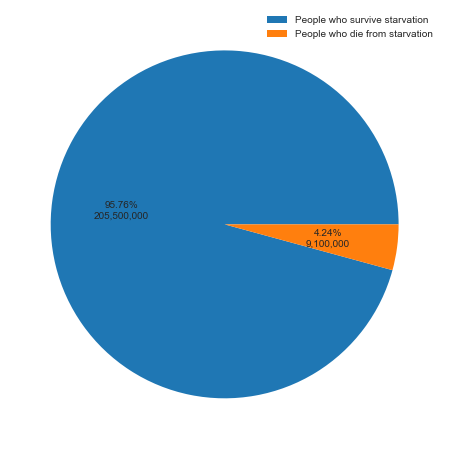

In [266]:
plt.pie([214.6-9.1,9.1], autopct=lambda p :'{:.2f}%\n{:,.0f}'.format(p,p * 214.6*10000))
plt.legend(["People who survive starvation", "People who die from starvation"])
plt.show()

[Go to the top](#start)

## What is the population forecast for 2050 ?  <a name="stat_question_14"></a>

In [267]:
df_population[df_population.Element=="Total Population - Both sexes"].groupby("Year").Value.sum()/1000

Year
2014    7112.880
2015    7193.637
2016    7273.859
2017    7353.462
Name: Value, dtype: float64

In [268]:
pop_evolution = df_population[df_population.Element=="Total Population - Both sexes"].groupby("Year").Value.sum()/1000
lr = Linreg().fit(np.array(pop_evolution.index).reshape(-1,1), list(pop_evolution.values))
preds = lr.predict(np.arange(2014,2051).reshape(-1,1))

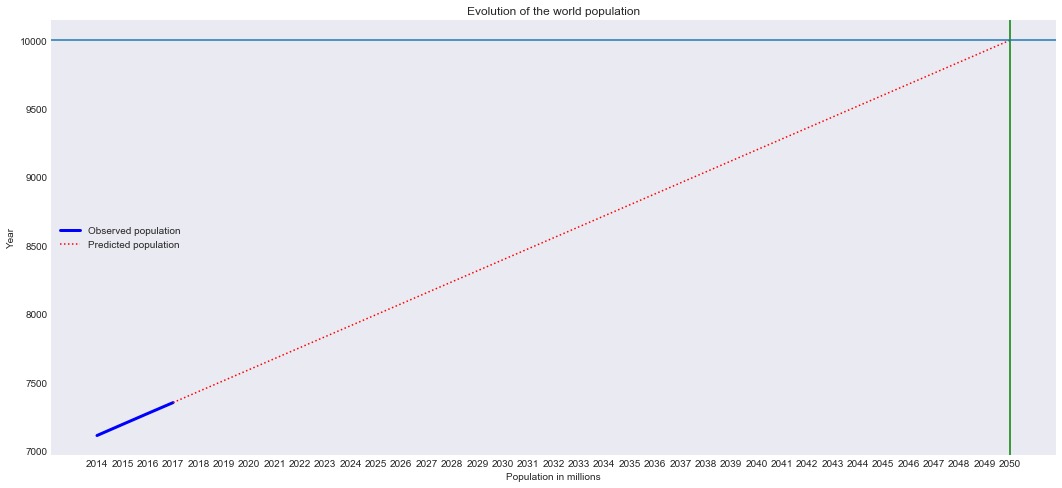

In [269]:
plt.plot(pop_evolution, color="b", linewidth=3,label="Observed population")
plt.plot(np.arange(2017,2051), preds[3:], color="r", linestyle=":", label="Predicted population")
plt.xticks(range(2014,2051))
plt.axvline(x=2050, color="g")
plt.axhline(y=preds[-1])
plt.xlabel("Population in millions")
plt.ylabel("Year")
plt.title("Evolution of the world population")
plt.legend()
plt.show()

In [270]:
print("A basic linear regression, with very few data, predicts there should be %s people in the world in the year 2050"%(f'{round(preds[-1]*1000):,}'))

A basic linear regression, with very few data, predicts there should be 10,000,249.0 people in the world in the year 2050


The UN estimates, in this website : https://www.un.org/development/desa/en/news/population/world-population-prospects-2019.html , that there will be about 9.7 billions people in 2050. Our prediction wasn't far.

# Cartographing our data <a name="carto"></a>

## Food insecurity <a name="insecurity"></a>

Geographic datas come from here : https://github.com/johan/world.geo.json

Thanks to the team that contributed to this awesome work !

We want to better have a grasp on the state of food insecurity in the world.

In [271]:
world_json = "world.geo.json-master/countries.geo.json"
country_list = []
with open(world_json) as json_file:
    data=json.load(json_file)
    for l in data["features"]:
        country_list.append(l["properties"]["name"])
country_list

['Afghanistan',
 'Angola',
 'Albania',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'Antarctica',
 'French Southern and Antarctic Lands',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'The Bahamas',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Brunei',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Switzerland',
 'Chile',
 'China',
 'Ivory Coast',
 'Cameroon',
 'Democratic Republic of the Congo',
 'Republic of the Congo',
 'Colombia',
 'Costa Rica',
 'Cuba',
 'Northern Cyprus',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'Ecuador',
 'Egypt',
 'Eritrea',
 'Spain',
 'Estonia',
 'Ethiopia',
 'Finland',
 'Fiji',
 'Falkland Islands',
 'France',
 'Gabon',
 'United Kingdom',
 'Georgia',
 'Ghana',
 'Guinea',
 'Gambia',
 'Guinea Bissau',
 'Equatorial Guinea',
 'Greece',
 'Greenland',
 'Guatemala'

In [272]:
df_indicators[df_indicators.Item.str.contains("insecur")].Item.unique()

array(['Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Number of severely food insecure people (million) (3-year average)',
       'Number of moderately or severely food insecure people (million) (3-year average)'],
      dtype=object)

Those are the indicators we have.
We can understand that people in "moderate and severely insecure" indicator includes "severely insecure" people.
We can therefore differentiate the two by doing a substraction.
Let's create our own Dataset for this specific purpose.

In [273]:
severe = df_indicators[(df_indicators.Item=="Number of severely food insecure people (million) (3-year average)") & (df_indicators.Year==2017)].loc[:,["Area","Value"]].replace("<0.1",0.05).fillna(0)
severe["Value"]=severe.Value.astype(float)
severe.rename(columns={"Value":"Severe"}, inplace=True)
total=df_indicators[(df_indicators.Item=="Number of moderately or severely food insecure people (million) (3-year average)") & (df_indicators.Year==2017)].loc[:,["Area","Value"]].replace("<0.1",0.05).fillna(0)
total["Value"]=total.Value.astype(float)
total.rename(columns={"Value":"Total"}, inplace=True)
undernourished=severe.merge(total, on="Area")
undernourished["Moderate"]=undernourished.Total-undernourished.Severe
undernourished = undernourished[["Area","Moderate","Severe","Total"]]
# undernourished.set_index("Area").Severe.describe()
undernourished=undernourished.merge(df_population[(df_population.Element.str.contains("Total"))&(df_population.Year==2017)].rename(columns={"Value":"Total population"}).loc[:,["Area","Total population"]], how="left", on="Area")
undernourished["Total population"]=undernourished["Total population"]
undernourished

Area  Moderate  Severe  Total  \
0                           Afghanistan      11.7     5.5   17.2   
1                               Albania       0.8     0.3    1.1   
2                               Algeria       0.0     0.0    0.0   
3                        American Samoa       0.0     0.0    0.0   
4                               Andorra       0.0     0.0    0.0   
..                                  ...       ...     ...    ...   
196  Venezuela (Bolivarian Republic of)       0.0     0.0    0.0   
197                            Viet Nam      13.0     2.2   15.2   
198                               Yemen       0.0     0.0    0.0   
199                              Zambia       0.0     0.0    0.0   
200                            Zimbabwe       0.0     0.0    0.0   

     Total population  
0             36296.0  
1              2884.0  
2             41389.0  
3                 NaN  
4                 NaN  
..                ...  
196           29402.0  
197           94600.0  
198           27834.0  
199           16853.0  
200           14236.0  

[201 rows x 5 columns]

In [274]:
undernourished.isna().sum().sum()

33

In [275]:
def show_map(df, col, title=None, cmap = 'YlOrBr'):
    if title==None:
        title=col
    fmap=folium.Map(max_bounds=True, min_zoom=1.7)
    folium.Choropleth(geo_data=world_json, 
                      data=df, columns=["Area",col],
                     fill_color=cmap, smooth_factor=0.2, name="All countries", highlight=True, fill_opacity=0.5, line_opacity=1, line_weight=0.2,
                     key_on="properties.name", legend_name=title).add_to(fmap)
    display(fmap)

Thanks to this function, we can easily show any value we want from our DataFrame in a single line.

In [276]:
show_map(undernourished, "Total")
show_map(undernourished, "Total population", "Total population")

There is some editing to make in our dataframe, regarding unmatching country names.

In [277]:
replace_country_dict = {"Russian Federation":"Russia", 
                        "Congo":"Republic of the Congo",
                       "Côte d'Ivoire":"Ivory Coast",
                       "Guinea-Bissau":"Guinea Bissau",
                       "Eswatini":"Swaziland",
                       "Viet Nam":"Vietnam",
                       "Iran (Islamic Republic of)": "Iran",
                       "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                        "Bolivia (Plurinational State of)":"Bolivia",
                        "Lao People's Democratic Republic":"Laos",
                        "Syrian Arab Republic":"Syria",
                        "Serbia":"Republic of Serbia",
                        "Czechia":"Czech Republic",
                        "Republic of Moldova":"Moldova",
                        "Bahamas":"The Bahamas",
                        "Brunei Darussalam":"Brunei",
                        "China, Taiwan Province of":"Taiwan",
                        "Democratic People's Republic of Korea":"North Korea",
                        "French Polynesia":"French Southern and Antarctic Lands",
                        "North Macedonia":"Macedonia",
                        "Republic of Korea":"South Korea",
                        "Timor-Leste":"East Timor",
                        "Venezuela (Bolivarian Republic of)":"Venezuela"}
undernourished.replace( replace_country_dict, inplace=True
                      )

In [278]:
print("Countries that are unfindable in the Geo Json :")
set(undernourished.Area.unique())-set(country_list)

Countries that are unfindable in the Geo Json :


{'American Samoa',
 'Andorra',
 'Antigua and Barbuda',
 'Bahrain',
 'Barbados',
 'Cabo Verde',
 'Comoros',
 'Cook Islands',
 'Dominica',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Marshall Islands',
 'Mauritius',
 'Micronesia (Federated States of)',
 'Nauru',
 'Niue',
 'Palau',
 'Palestine',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Seychelles',
 'Singapore',
 'Tokelau',
 'Tonga',
 'Tuvalu'}

In [279]:
show_map(undernourished, "Total","Undernourished people in million per country" )

It's better.

Now, to improve the contrast, we need to think about the optimal threshold scale.

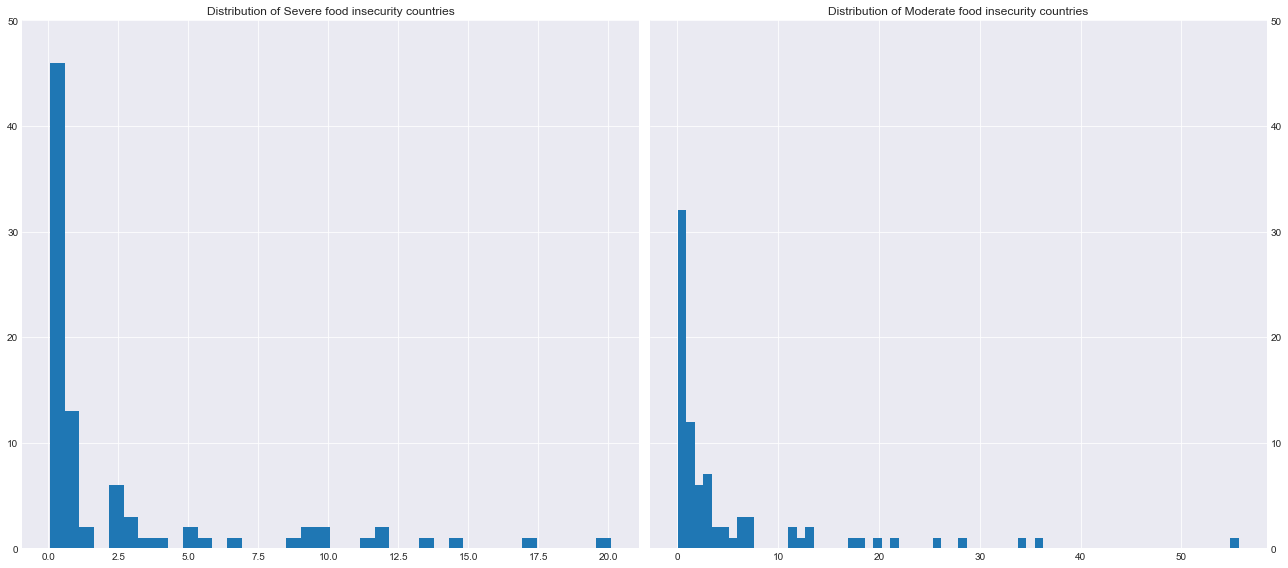

In [280]:
fig, (ax1, ax2)=plt.subplots(1,2)
undernourished[undernourished.Severe>0].Severe.hist(bins=len(undernourished.Severe.unique()-1), ax=ax1)
ax1.set_title("Distribution of Severe food insecurity countries")
ax1.set_yticks(np.arange(0,60,10))
undernourished[undernourished.Moderate>0].Moderate.hist(bins=len(undernourished.Moderate.unique()-1), ax=ax2)
ax2.set_title("Distribution of Moderate food insecurity countries")
ax2.set_yticks(np.arange(0,60,10))
ax2.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)
plt.tight_layout()
plt.show()

In [281]:
print("%f%% of the countries have negligeable severe food insecurity rates."%((undernourished==0).Severe.sum()*100/len(undernourished)))
print("%f%% of the countries have negligeable moderate food insecurity rates."%((undernourished==0).Moderate.sum()*100/len(undernourished)))

56.218905% of the countries have negligeable severe food insecurity rates.
58.706468% of the countries have negligeable moderate food insecurity rates.


In [282]:
undernourished_only=undernourished[undernourished.Total>0]

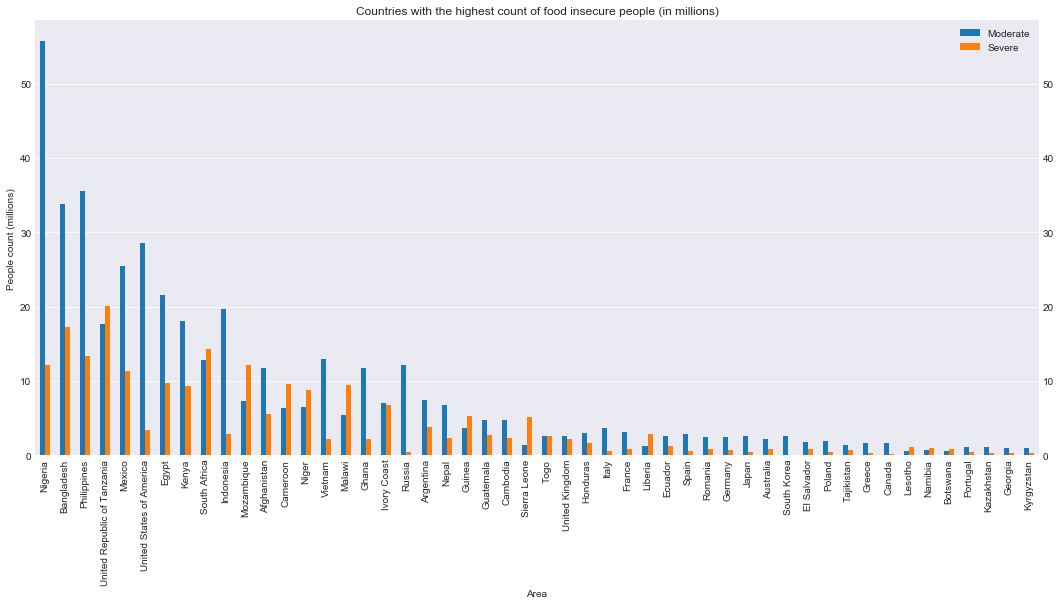

In [283]:
ax=plt.gca()
undernourished_only[["Area", "Moderate", "Severe", "Total"]].sort_values("Total", ascending=False).set_index("Area").head(50)[["Moderate","Severe"]].plot.bar(ax=ax)
ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
ax.set_ylabel("People count (millions)")
plt.grid(axis="y")
plt.title("Countries with the highest count of food insecure people (in millions)")
plt.show()

We can update our continent dictionary (designed in the section [Protein supply and Kcal availability per product and country](#stat_question_1)) to help us differentiate countries by continent.

In [284]:
color_dict = {"Africa":"red","Europe":"green", "Asia":"yellow", "Oceania":"orange", "North America":"blue", "South America":"cyan"}
continent_colors={(replace_country_dict[k] if k in replace_country_dict.keys() else k):color_dict[v] for k,v in continent_dict.items()}
continent_colors

{'Algeria': 'red',
 'Angola': 'red',
 'Benin': 'red',
 'Botswana': 'red',
 'Burkina Faso': 'red',
 'Burundi': 'red',
 'Cameroon': 'red',
 'Cabo Verde': 'red',
 'Central African Republic': 'red',
 'Chad': 'red',
 'Comoros': 'red',
 'Republic of the Congo': 'red',
 'Democratic Republic of the Congo': 'red',
 'Ivory Coast': 'red',
 'Djibouti': 'red',
 'Egypt': 'red',
 'Equatorial Guinea': 'red',
 'Eritrea': 'red',
 'Swaziland': 'red',
 'Ethiopia': 'red',
 'Gabon': 'red',
 'Gambia': 'red',
 'Ghana': 'red',
 'Guinea': 'red',
 'Guinea Bissau': 'red',
 'Kenya': 'red',
 'Lesotho': 'red',
 'Liberia': 'red',
 'Libya': 'red',
 'Madagascar': 'red',
 'Malawi': 'red',
 'Mali': 'red',
 'Mauritania': 'red',
 'Mauritius': 'red',
 'Morocco': 'red',
 'Mozambique': 'red',
 'Namibia': 'red',
 'Niger': 'red',
 'Nigeria': 'red',
 'Rwanda': 'red',
 'Sao Tome and Principe': 'red',
 'Senegal': 'red',
 'Seychelles': 'red',
 'Sierra Leone': 'red',
 'Somalia': 'red',
 'South Africa': 'red',
 'South Sudan': 'red',


In [285]:
def per_continent_bar(df, col, title=None, ylabel=None):
    if title is None and " " in col:
        title=col
    ylabel=title if ylabel is None else ylabel

    def build_legend(data):
        legend_elements = []
        for key in data:
            legend_elements.append(Line2D([1], [1], marker=(4,0,45), color='w', label=key,
                                            markerfacecolor=data[key], markersize=20))
        return legend_elements

    gig, ax = plt.subplots(1)
    top_df = df[["Area",col]].sort_values(col, ascending=False).set_index("Area").head(50)
    colors=[continent_colors[x] for x in top_df.index]
    top_df.plot.bar(ax=ax, color=colors)
    ax.bar(list(top_df.index), top_df[col].values, color=colors)
    ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
    legend_elements= build_legend(color_dict)
    ax.legend(handles=legend_elements, loc="upper center")
    plt.grid(axis="y")
    ax.set_ylabel(ylabel)
    plt.title(title)
    plt.show()

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


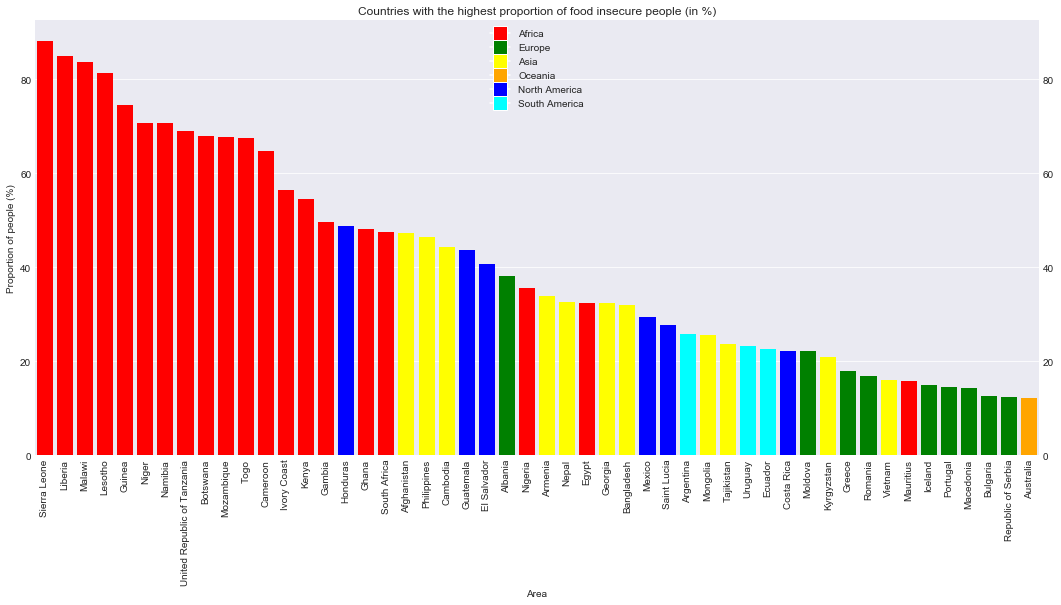

In [286]:
undernourished_only["Total (%)"]=undernourished_only["Total"]/undernourished_only["Total population"]*1e5
per_continent_bar(undernourished_only, "Total (%)", "Countries with the highest proportion of food insecure people (in %)", "Proportion of people (%)")

[Go to the top](#start)

## Alcohol beverages <a name="booze"></a>

### Raw production <a name="booze_prod"></a>

There are two items representing drinkable alcohol beverages. Distilled alcohol and fermented beverages.

In [287]:
df_products[df_products.Item.str.contains("Beverages")].Item.unique()

array(['Beverages, Fermented', 'Beverages, Alcoholic'], dtype=object)

In [288]:
df_products[(df_products.Item.str.contains("Beverages"))&(df_products.Element=="Production")].Unit.unique()

array(['1000 tonnes'], dtype=object)

In [289]:
alcohol=df_products[(df_products.Item.str.contains("Beverages"))&(df_products.Year==2017)].groupby("Area").sum()[["Value"]].rename(columns={"Value":"Production (1000 tons)"}).reset_index()
alcohol=alcohol.merge(df_population[(df_population.Element.str.contains("Total"))&(df_population.Year==2017)].rename(columns={"Value":"Total population"}).loc[:,["Area","Total population"]], how="left", on="Area")
alcohol

Area  Production (1000 tons)  \
0                           Afghanistan                       0   
1                               Albania                       1   
2                               Algeria                      19   
3                                Angola                    2694   
4                   Antigua and Barbuda                      79   
..                                  ...                     ...   
165  Venezuela (Bolivarian Republic of)                     162   
166                            Viet Nam                     951   
167                               Yemen                       0   
168                              Zambia                     918   
169                            Zimbabwe                     545   

     Total population  
0             36296.0  
1              2884.0  
2             41389.0  
3             29816.0  
4                95.0  
..                ...  
165           29402.0  
166           94600.0  
167           27834.0  
168           16853.0  
169           14236.0  

[170 rows x 3 columns]

Here again, we must change the name of the country according to our previously used dictionary.

In [290]:
alcohol["Area"]=alcohol.Area.replace(replace_country_dict)

To avoid this issue on future additions, let's keep the products_df for 2017 and alcoholic beverages.

In [291]:
df_prod_alcohol = df_products[(df_products.Year==2017)&(df_products.Item.str.contains("Beverages"))].groupby(["Area", "Element"]).sum().reset_index()
df_prod_alcohol["Area"]=df_prod_alcohol.Area.replace(replace_country_dict)
def get_alcohol_element(element, new_title=None):
    ret = df_prod_alcohol[df_prod_alcohol["Element"]==element][["Area", "Value"]]
    if new_title is None:
        return ret
    else:
        return ret.rename(columns={"Value":new_title})
def merge_on_area(df, element, new_title=None):
    return df.merge(get_alcohol_element(element, new_title), how="left", on="Area")

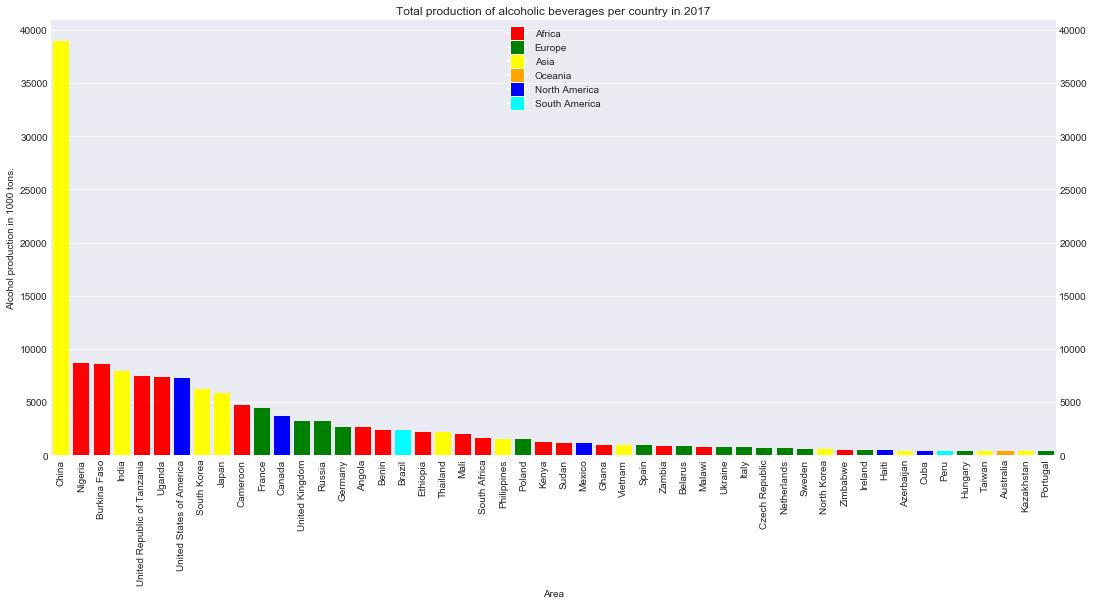

In [292]:
per_continent_bar(alcohol, "Production (1000 tons)", "Total production of alcoholic beverages per country in 2017", "Alcohol production in 1000 tons.")

In [293]:
show_map(alcohol, "Production (1000 tons)","Production of alcoholic beverage (1000 tons)", cmap="YlOrRd" )

China is making it impossible to see any scale details. Let's edit our function to show better spaced ranges of colours by not giving extreme colors to extreme values.

In [294]:
def show_map(df, col, title=None, manage_extremes=False):
    df=df[df[col]>0]
    area_dict = df[["Area",col]].set_index("Area").to_dict()[col]
    def style_function(feature):
        val = area_dict.get(feature['properties']['name'])
        return {
            'fillColor': '#00000000' if val is None else colormap(val),
            'fillOpacity': 0.5,
            #borders
            'weight': 0.2,
            'highlight':True
        }

    if title==None:
        title=col
    fmap=folium.Map(max_bounds=True, min_zoom=1.7)
    
    maxi=df[col].max()
    if manage_extremes :
        vals = sorted(df[col].unique())
        i=len(vals)-1
        while i>0 and vals[i]>=1.25*vals[i-1]:
            i-=1
        maxi=vals[i]
    colormap = branca.colormap.linear.YlOrRd_09.scale(0, maxi)
    colormap.caption = title
    colormap.add_to(fmap)
    
    folium.GeoJson(data = world_json,style_function = style_function).add_to(fmap)
    display(fmap)

In [295]:
print("Not managing extreme values :")
show_map(alcohol, "Production (1000 tons)","Production of alcohol (1000 tons)", manage_extremes=False)
print("Managing extreme values :")
show_map(alcohol, "Production (1000 tons)","Production of alcohol (1000 tons)", manage_extremes=True)

Not managing extreme values :


Managing extreme values :


We could also take the ratio production/population, as we often do.

In [296]:
alcohol["Production per capita (kg/person)"]=alcohol["Production (1000 tons)"]*1000/alcohol["Total population"]
alcohol

Area  Production (1000 tons)  Total population  \
0            Afghanistan                       0           36296.0   
1                Albania                       1            2884.0   
2                Algeria                      19           41389.0   
3                 Angola                    2694           29816.0   
4    Antigua and Barbuda                      79              95.0   
..                   ...                     ...               ...   
165            Venezuela                     162           29402.0   
166              Vietnam                     951           94600.0   
167                Yemen                       0           27834.0   
168               Zambia                     918           16853.0   
169             Zimbabwe                     545           14236.0   

     Production per capita (kg/person)  
0                             0.000000  
1                             0.346741  
2                             0.459059  
3                            90.354172  
4                           831.578947  
..                                 ...  
165                           5.509829  
166                          10.052854  
167                           0.000000  
168                          54.471014  
169                          38.283226  

[170 rows x 4 columns]

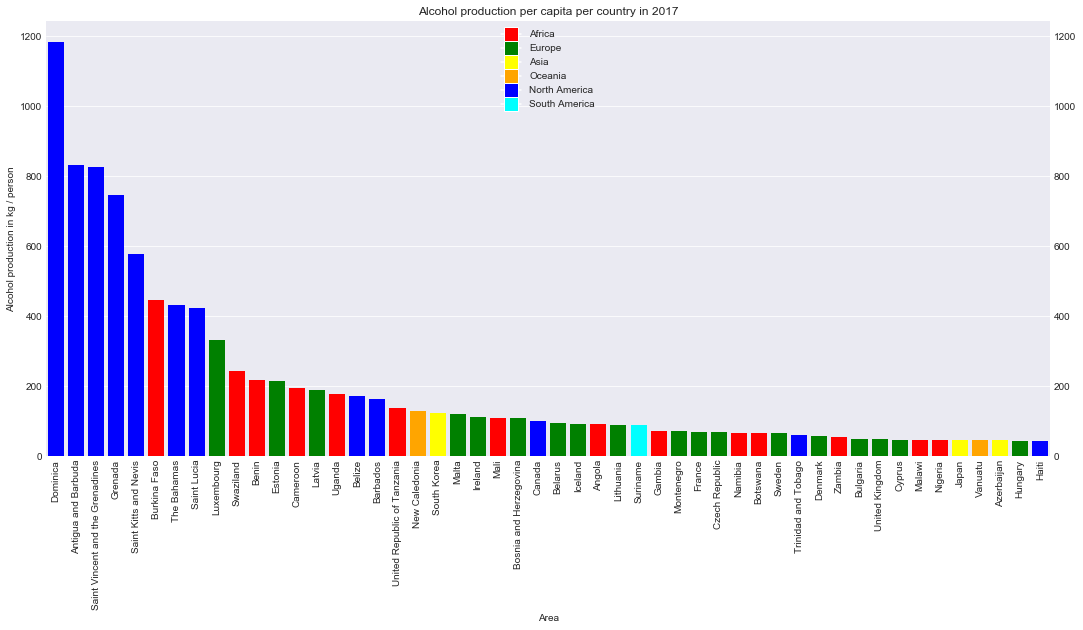

In [297]:
per_continent_bar(alcohol, "Production per capita (kg/person)", "Alcohol production per capita per country in 2017", "Alcohol production in kg / person")

In [298]:
show_map(alcohol, "Production per capita (kg/person)","Production of alcohol per capita (kg / person)" )

We can see that Burkina Faso is especially high. But the highest are the pacific Islands near Bahamas (some are missing in the Geojson). We need to manage extreme values again.

In [299]:
show_map(alcohol, "Production per capita (kg/person)","Production of alcohol per capita (kg / person)", manage_extremes=True)

This is but raw production per capita. Any country could be exporting most of it. 
We should therefore find more relevant ways to get interpretable insights.

[Go to the top](#start)

### Consumption estimation <a name="booze_cons"></a>

First, we can substract the Exportation from the raw Production.

In [300]:
# Setting a natural order to the column :
alcohol = alcohol[["Area", "Total population", "Production (1000 tons)", "Production per capita (kg/person)"]]
alcohol = merge_on_area(alcohol, "Export Quantity","Exportation (1000 tons)")
alcohol["Non-exported production per capita (kg/person)"]=(alcohol["Production (1000 tons)"]-alcohol["Exportation (1000 tons)"])*1000/alcohol["Total population"]

In [301]:
alcohol.sort_values("Non-exported production per capita (kg/person)", ascending=False).head(10)

Area  Total population  \
43                           Dominica              71.0   
4                 Antigua and Barbuda              95.0   
131  Saint Vincent and the Grenadines             109.0   
61                            Grenada             110.0   
129             Saint Kitts and Nevis              52.0   
10                        The Bahamas             381.0   
130                       Saint Lucia             180.0   
91                         Luxembourg             591.0   
49                          Swaziland            1124.0   
16                              Benin           11175.0   

     Production (1000 tons)  Production per capita (kg/person)  \
43                       84                        1183.098592   
4                        79                         831.578947   
131                      90                         825.688073   
61                       82                         745.454545   
129                      30                         576.923077   
10                      164                         430.446194   
130                      76                         422.222222   
91                      196                         331.641286   
49                      274                         243.772242   
16                     2416                         216.196868   

     Exportation (1000 tons)  Non-exported production per capita (kg/person)  
43                       0.0                                     1183.098592  
4                        0.0                                      831.578947  
131                      0.0                                      825.688073  
61                       0.0                                      745.454545  
129                      0.0                                      576.923077  
10                       0.0                                      430.446194  
130                      2.0                                      411.111111  
91                       4.0                                      324.873096  
49                       7.0                                      237.544484  
16                       0.0                                      216.196868

In [302]:
show_map(alcohol[alcohol.iloc[:,5]>0], "Non-exported production per capita (kg/person)","Alcoholic beverages production intended to internal use per cap (kg / person)")

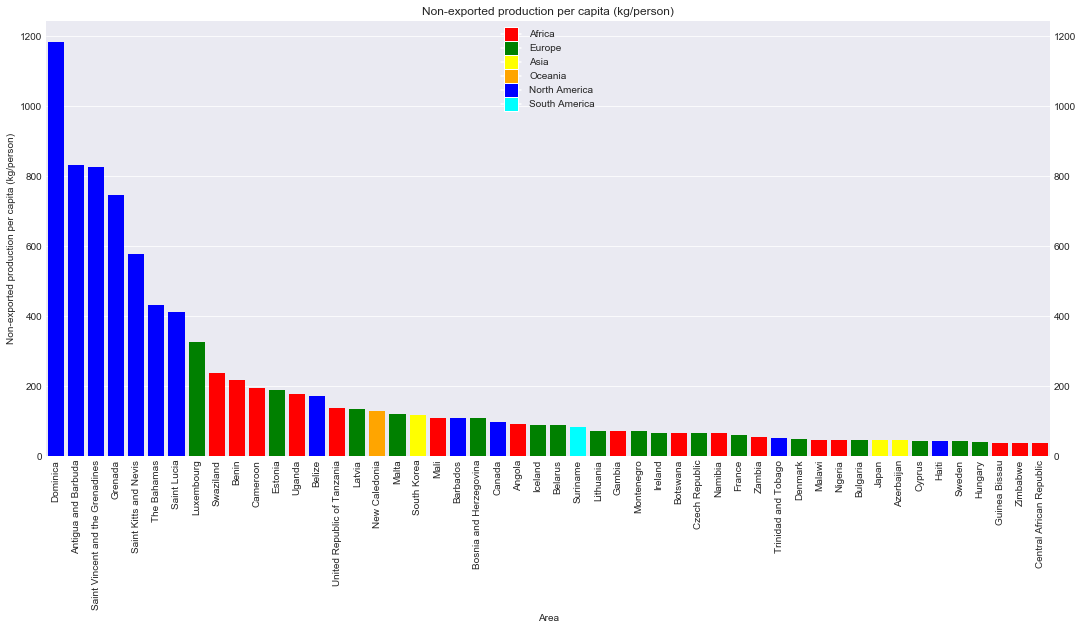

In [303]:
per_continent_bar(alcohol, "Non-exported production per capita (kg/person)")

The same state-islands appear in this ranking. Let's keep it in mind for the section [Top exporters of alcoholic beverages](#export_alcool).

[Go to the top](#start)

### Better estimation of the consumption  <a name="booze_better"></a>

Here, we have negative values :

In [304]:
alcohol[alcohol["Non-exported production per capita (kg/person)"]<0].sort_values("Non-exported production per capita (kg/person)")

Area  Total population  Production (1000 tons)  \
65   Guyana             775.0                       1   
1   Albania            2884.0                       1   

    Production per capita (kg/person)  Exportation (1000 tons)  \
65                           1.290323                     17.0   
1                            0.346741                      2.0   

    Non-exported production per capita (kg/person)  
65                                      -20.645161  
1                                        -0.346741

Let's investigation by adding importations.

In [305]:
alcohol=merge_on_area(alcohol, "Import Quantity", "Importation (1000 tons)")
alcohol

Area  Total population  Production (1000 tons)  \
0            Afghanistan           36296.0                       0   
1                Albania            2884.0                       1   
2                Algeria           41389.0                      19   
3                 Angola           29816.0                    2694   
4    Antigua and Barbuda              95.0                      79   
..                   ...               ...                     ...   
165            Venezuela           29402.0                     162   
166              Vietnam           94600.0                     951   
167                Yemen           27834.0                       0   
168               Zambia           16853.0                     918   
169             Zimbabwe           14236.0                     545   

     Production per capita (kg/person)  Exportation (1000 tons)  \
0                             0.000000                      0.0   
1                             0.346741                      2.0   
2                             0.459059                      0.0   
3                            90.354172                      0.0   
4                           831.578947                      0.0   
..                                 ...                      ...   
165                           5.509829                      8.0   
166                          10.052854                     17.0   
167                           0.000000                      0.0   
168                          54.471014                      3.0   
169                          38.283226                      0.0   

     Non-exported production per capita (kg/person)  Importation (1000 tons)  
0                                          0.000000                      0.0  
1                                         -0.346741                      1.0  
2                                          0.459059                      6.0  
3                                         90.354172                      9.0  
4                                        831.578947                      1.0  
..                                              ...                      ...  
165                                        5.237739                      2.0  
166                                        9.873150                     75.0  
167                                        0.000000                      0.0  
168                                       54.293004                      6.0  
169                                       38.283226                      4.0  

[170 rows x 7 columns]

By doing $Production-Exportation+Importation$ we should have a good estimation of the intern consumption.

In [306]:
alcohol["Estimated consumption (1000 tons)"]=(alcohol["Production (1000 tons)"]-alcohol["Exportation (1000 tons)"]+alcohol["Importation (1000 tons)"])
alcohol["Estimated consumption per capita (kg/person)"]=(alcohol["Production (1000 tons)"]-alcohol["Exportation (1000 tons)"]+alcohol["Importation (1000 tons)"])*1000/alcohol["Total population"]
alcohol.sort_values("Estimated consumption per capita (kg/person)", ascending=False).head(10)

Area  Total population  \
43                           Dominica              71.0   
4                 Antigua and Barbuda              95.0   
131  Saint Vincent and the Grenadines             109.0   
61                            Grenada             110.0   
129             Saint Kitts and Nevis              52.0   
10                        The Bahamas             381.0   
130                       Saint Lucia             180.0   
91                         Luxembourg             591.0   
49                          Swaziland            1124.0   
16                              Benin           11175.0   

     Production (1000 tons)  Production per capita (kg/person)  \
43                       84                        1183.098592   
4                        79                         831.578947   
131                      90                         825.688073   
61                       82                         745.454545   
129                      30                         576.923077   
10                      164                         430.446194   
130                      76                         422.222222   
91                      196                         331.641286   
49                      274                         243.772242   
16                     2416                         216.196868   

     Exportation (1000 tons)  Non-exported production per capita (kg/person)  \
43                       0.0                                     1183.098592   
4                        0.0                                      831.578947   
131                      0.0                                      825.688073   
61                       0.0                                      745.454545   
129                      0.0                                      576.923077   
10                       0.0                                      430.446194   
130                      2.0                                      411.111111   
91                       4.0                                      324.873096   
49                       7.0                                      237.544484   
16                       0.0                                      216.196868   

     Importation (1000 tons)  Estimated consumption (1000 tons)  \
43                       0.0                               84.0   
4                        1.0                               80.0   
131                      0.0                               90.0   
61                       1.0                               83.0   
129                      0.0                               30.0   
10                       3.0                              167.0   
130                      3.0                               77.0   
91                      29.0                              221.0   
49                       5.0                              272.0   
16                       2.0                             2418.0   

     Estimated consumption per capita (kg/person)  
43                                    1183.098592  
4                                      842.105263  
131                                    825.688073  
61                                     754.545455  
129                                    576.923077  
10                                     438.320210  
130                                    427.777778  
91                                     373.942470  
49                                     241.992883  
16                                     216.375839

In [307]:
alcohol.sort_values("Estimated consumption per capita (kg/person)").head(2)

Area  Total population  Production (1000 tons)  \
65       Guyana             775.0                       1   
0   Afghanistan           36296.0                       0   

    Production per capita (kg/person)  Exportation (1000 tons)  \
65                           1.290323                     17.0   
0                            0.000000                      0.0   

    Non-exported production per capita (kg/person)  Importation (1000 tons)  \
65                                      -20.645161                      1.0   
0                                         0.000000                      0.0   

    Estimated consumption (1000 tons)  \
65                              -15.0   
0                                 0.0   

    Estimated consumption per capita (kg/person)  
65                                    -19.354839  
0                                       0.000000

We still have a negative value in Guyna which shows much more exportation than production added to importation.

In [308]:
show_map(alcohol, "Estimated consumption per capita (kg/person)","Estimated alcohol consumption per cap (kg / person)")

In [309]:
alcohol.sort_values("Estimated consumption per capita (kg/person)", ascending=False).head(10).reset_index()

index                              Area  Total population  \
0     43                          Dominica              71.0   
1      4               Antigua and Barbuda              95.0   
2    131  Saint Vincent and the Grenadines             109.0   
3     61                           Grenada             110.0   
4    129             Saint Kitts and Nevis              52.0   
5     10                       The Bahamas             381.0   
6    130                       Saint Lucia             180.0   
7     91                        Luxembourg             591.0   
8     49                         Swaziland            1124.0   
9     16                             Benin           11175.0   

   Production (1000 tons)  Production per capita (kg/person)  \
0                      84                        1183.098592   
1                      79                         831.578947   
2                      90                         825.688073   
3                      82                         745.454545   
4                      30                         576.923077   
5                     164                         430.446194   
6                      76                         422.222222   
7                     196                         331.641286   
8                     274                         243.772242   
9                    2416                         216.196868   

   Exportation (1000 tons)  Non-exported production per capita (kg/person)  \
0                      0.0                                     1183.098592   
1                      0.0                                      831.578947   
2                      0.0                                      825.688073   
3                      0.0                                      745.454545   
4                      0.0                                      576.923077   
5                      0.0                                      430.446194   
6                      2.0                                      411.111111   
7                      4.0                                      324.873096   
8                      7.0                                      237.544484   
9                      0.0                                      216.196868   

   Importation (1000 tons)  Estimated consumption (1000 tons)  \
0                      0.0                               84.0   
1                      1.0                               80.0   
2                      0.0                               90.0   
3                      1.0                               83.0   
4                      0.0                               30.0   
5                      3.0                              167.0   
6                      3.0                               77.0   
7                     29.0                              221.0   
8                      5.0                              272.0   
9                      2.0                             2418.0   

   Estimated consumption per capita (kg/person)  
0                                   1183.098592  
1                                    842.105263  
2                                    825.688073  
3                                    754.545455  
4                                    576.923077  
5                                    438.320210  
6                                    427.777778  
7                                    373.942470  
8                                    241.992883  
9                                    216.375839

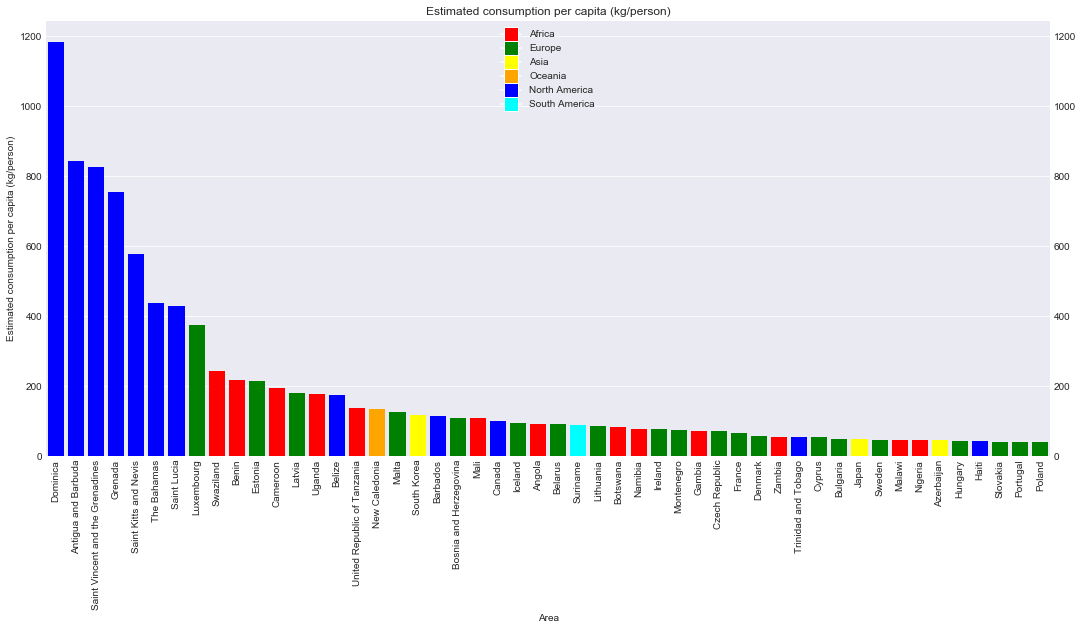

In [310]:
per_continent_bar(alcohol, "Estimated consumption per capita (kg/person)")

[Go to the top](#start)

### Top exporters of alcoholic beverages <a name="export_alcool"/>

In [311]:
alcohol.sort_values("Exportation (1000 tons)", ascending=False).head()

Area  Total population  Production (1000 tons)  \
159            United Kingdom           66727.0                    3225   
161  United States of America          325084.0                    7245   
53                     France           64842.0                    4403   
58                    Germany           82658.0                    2705   
124               South Korea           51096.0                    6244   

     Production per capita (kg/person)  Exportation (1000 tons)  \
159                          48.331260                   1162.0   
161                          22.286547                    457.0   
53                           67.903519                    451.0   
58                           32.725205                    325.0   
124                         122.201346                    270.0   

     Non-exported production per capita (kg/person)  Importation (1000 tons)  \
159                                       30.917020                    401.0   
161                                       20.880757                    809.0   
53                                        60.948151                    288.0   
58                                        28.793341                    363.0   
124                                      116.917176                     53.0   

     Estimated consumption (1000 tons)  \
159                             2464.0   
161                             7597.0   
53                              4240.0   
58                              2743.0   
124                             6027.0   

     Estimated consumption per capita (kg/person)  
159                                     36.926581  
161                                     23.369345  
53                                      65.389717  
58                                      33.184931  
124                                    117.954439

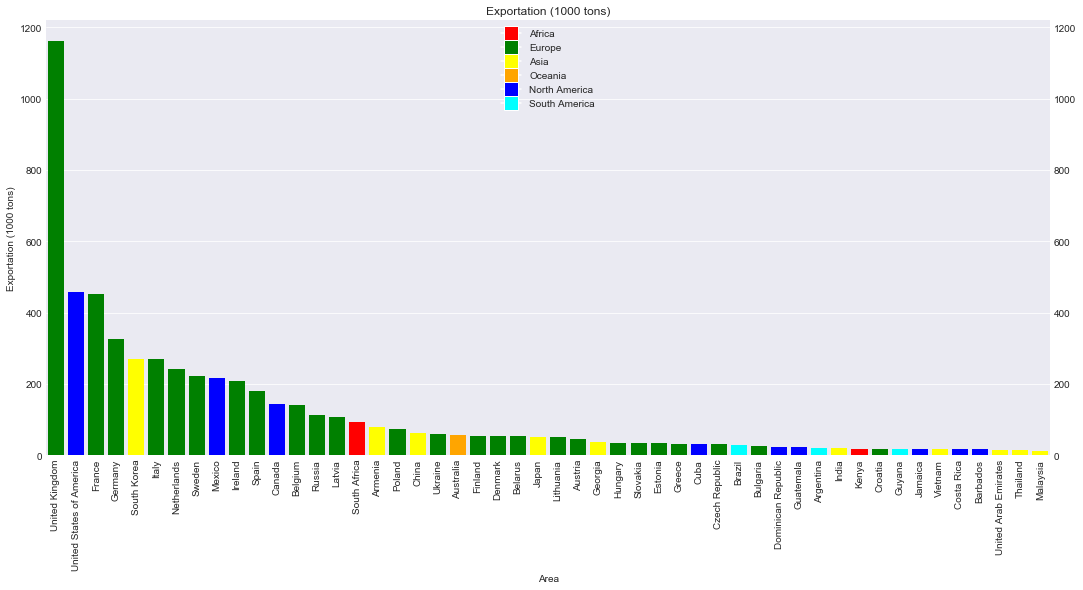

In [312]:
per_continent_bar(alcohol, "Exportation (1000 tons)")

Africa is way less represented here. But this is only raw exportation.

Here are four ways of ranking countries fairly on this matter :
    - 1 Exportation per capita : this ratio is dependant on the population of the country. Meaning it is independant with the intern industry choices. 
    - 2 "Exportation / Production" ratio : This one is more dependant on the industry, as achieving this figure is most likely intended (at least, at the level of each company in the alcoholic beverage industry). 
    - 3 "Exportation / Total production" ratio. This one is more dependant on the intern industrial culture or the intern politics of each country as a whole.
    - 4 "Exportation / Total exportation" ratio, which gives an idea of the priority and overall popularity of the products on the international market.


In [313]:
list(df_products.Element.unique())

['Production',
 'Import Quantity',
 'Stock Variation',
 'Export Quantity',
 'Domestic supply quantity',
 'Feed',
 'Seed',
 'Losses',
 'Processing',
 'Other uses (non-food)',
 'Tourist consumption',
 'Residuals',
 'Food',
 'Food supply quantity (kg/capita/yr)',
 'Food supply (kcal/capita/day)',
 'Protein supply quantity (g/capita/day)',
 'Fat supply quantity (g/capita/day)']

In [314]:
# Adding all productions by country
df_allprods=df_products[(df_products.Year==2017) & (df_products.Element=="Production")].groupby("Area").sum().reset_index()[["Area", "Value"]].rename(columns={"Value":"Total production (1000 tons)"})
df_allprods.replace(replace_country_dict, inplace=True)
alcohol=alcohol.merge(df_allprods, how="left", on="Area")
del(df_allprods)
# Adding all exportations by country
df_allexports=df_products[(df_products.Year==2017) & (df_products.Element=="Export Quantity")].groupby("Area").sum().reset_index()[["Area", "Value"]].rename(columns={"Value":"Total exportation (1000 tons)"})
df_allexports.replace(replace_country_dict, inplace=True)
alcohol=alcohol.merge(df_allexports, how="left", on="Area")
del(df_allexports)
# Adding ratio columns
alcohol["Exportation per capita (kg/person)"] = alcohol["Exportation (1000 tons)"] *1000 / alcohol["Total population"]
alcohol["Exportation / Production (%)"] = alcohol["Exportation (1000 tons)"] * 100 / alcohol["Production (1000 tons)"]
alcohol["Exportation / Total exportation (%)"] = alcohol["Exportation (1000 tons)"] * 100 / alcohol["Total exportation (1000 tons)"]
alcohol["Exportation / Total production (%)"] = alcohol["Exportation (1000 tons)"] * 100 / alcohol["Total production (1000 tons)"]
alcohol=alcohol.fillna(0)
alcohol

Area  Total population  Production (1000 tons)  \
0            Afghanistan           36296.0                       0   
1                Albania            2884.0                       1   
2                Algeria           41389.0                      19   
3                 Angola           29816.0                    2694   
4    Antigua and Barbuda              95.0                      79   
..                   ...               ...                     ...   
165            Venezuela           29402.0                     162   
166              Vietnam           94600.0                     951   
167                Yemen           27834.0                       0   
168               Zambia           16853.0                     918   
169             Zimbabwe           14236.0                     545   

     Production per capita (kg/person)  Exportation (1000 tons)  \
0                             0.000000                      0.0   
1                             0.346741                      2.0   
2                             0.459059                      0.0   
3                            90.354172                      0.0   
4                           831.578947                      0.0   
..                                 ...                      ...   
165                           5.509829                      8.0   
166                          10.052854                     17.0   
167                           0.000000                      0.0   
168                          54.471014                      3.0   
169                          38.283226                      0.0   

     Non-exported production per capita (kg/person)  Importation (1000 tons)  \
0                                          0.000000                      0.0   
1                                         -0.346741                      1.0   
2                                          0.459059                      6.0   
3                                         90.354172                      9.0   
4                                        831.578947                      1.0   
..                                              ...                      ...   
165                                        5.237739                      2.0   
166                                        9.873150                     75.0   
167                                        0.000000                      0.0   
168                                       54.293004                      6.0   
169                                       38.283226                      4.0   

     Estimated consumption (1000 tons)  \
0                                  0.0   
1                                  0.0   
2                                 25.0   
3                               2703.0   
4                                 80.0   
..                                 ...   
165                              156.0   
166                             1009.0   
167                                0.0   
168                              921.0   
169                              549.0   

     Estimated consumption per capita (kg/person)  \
0                                        0.000000   
1                                        0.000000   
2                                        0.604025   
3                                       90.656024   
4                                      842.105263   
..                                            ...   
165                                      5.305762   
166                                     10.665962   
167                                      0.000000   
168                                     54.649024   
169                                     38.564203   

     Total production (1000 tons)  Total exportation (1000 tons)  \
0                           11609                            601   
1                            4231                            156   
2                           26763                            743   

In [315]:
rank_keys = alcohol[["Exportation per capita (kg/person)","Exportation / Production (%)","Exportation / Total exportation (%)","Exportation / Total production (%)"]].sum(axis=1)
alcohol.reindex(rank_keys.sort_values(ascending=False).index).head(20)

Area  Total population  Production (1000 tons)  \
65                Guyana             775.0                       1   
1                Albania            2884.0                       1   
6                Armenia            2944.0                     110   
12              Barbados             286.0                      47   
86                Latvia            1951.0                     367   
74               Ireland            4753.0                     524   
146               Sweden            9904.0                     638   
159       United Kingdom           66727.0                    3225   
14               Belgium           11419.0                     325   
108          Netherlands           17021.0                     666   
57               Georgia            4008.0                     138   
48               Estonia            1319.0                     283   
76                 Italy           60673.0                     798   
90             Lithuania            2845.0                     255   
52               Finland            5511.0                     222   
8                Austria            8819.0                     144   
152  Trinidad and Tobago            1384.0                      84   
94              Malaysia           31104.0                      43   
60                Greece           10569.0                     120   
77               Jamaica            2920.0                     122   

     Production per capita (kg/person)  Exportation (1000 tons)  \
65                            1.290323                     17.0   
1                             0.346741                      2.0   
6                            37.364130                     78.0   
12                          164.335664                     16.0   
86                          188.108662                    106.0   
74                          110.246160                    207.0   
146                          64.418417                    223.0   
159                          48.331260                   1162.0   
14                           28.461336                    142.0   
108                          39.128136                    241.0   
57                           34.431138                     37.0   
48                          214.556482                     33.0   
76                           13.152473                    269.0   
90                           89.630931                     51.0   
52                           40.283070                     55.0   
8                            16.328382                     44.0   
152                          60.693642                     13.0   
94                            1.382459                     13.0   
60                           11.353960                     32.0   
77                           41.780822                     17.0   

     Non-exported production per capita (kg/person)  Importation (1000 tons)  \
65                                       -20.645161                      1.0   
1                                         -0.346741                      1.0   
6                                         10.869565                     20.0   
12                                       108.391608                      2.0   
86                                       133.777550                     92.0   
74                                        66.694719                     48.0   
146                                       41.902262                     44.0   
159                                       30.917020                    401.0   
14                                        16.025922                     77.0   
108                                       24.969156                    155.0   
57                                        25.199601                      7.0   
48                                       189.537528                     31.0   
76                                         8.718870                     95.0   
90                   

In [316]:
for ratio in ["Exportation per capita (kg/person)", "Exportation / Production (%)", "Exportation / Total exportation (%)", "Exportation / Total production (%)"]:
    print("\n\tRanking by %s :"%ratio)
    display(alcohol[["Area", ratio]].sort_values(ratio, ascending=False).head(20))
    show_map(alcohol[["Area", ratio]], ratio, manage_extremes=True)


	Ranking by Exportation per capita (kg/person) :


Area  Exportation per capita (kg/person)
12              Barbados                           55.944056
86                Latvia                           54.331112
74               Ireland                           43.551441
6                Armenia                           26.494565
48               Estonia                           25.018954
146               Sweden                           22.516155
65                Guyana                           21.935484
90             Lithuania                           17.926186
159       United Kingdom                           17.414240
108          Netherlands                           14.158980
14               Belgium                           12.435415
130          Saint Lucia                           11.111111
52               Finland                            9.980040
41               Denmark                            9.595255
152  Trinidad and Tobago                            9.393064
57               Georgia                            9.231537
53                France                            6.955368
91            Luxembourg                            6.768190
49             Swaziland                            6.227758
138             Slovakia                            6.058381


	Ranking by Exportation / Production (%) :


Area  Exportation / Production (%)
65           Guyana                   1700.000000
1           Albania                    200.000000
6           Armenia                     70.909091
14          Belgium                     43.692308
74          Ireland                     39.503817
108     Netherlands                     36.186186
159  United Kingdom                     36.031008
146          Sweden                     34.952978
12         Barbados                     34.042553
76            Italy                     33.709273
8           Austria                     30.555556
94         Malaysia                     30.232558
86           Latvia                     28.882834
57          Georgia                     26.811594
60           Greece                     26.666667
52          Finland                     24.774775
90        Lithuania                     20.000000
79           Jordan                     19.354839
100          Mexico                     19.068541
142           Spain                     18.861960


	Ranking by Exportation / Total exportation (%) :


Area  Exportation / Total exportation (%)
6                Armenia                            31.967213
12              Barbados                            29.090909
165            Venezuela                            11.267606
77               Jamaica                             9.239130
57               Georgia                             9.135802
124          South Korea                             8.169440
159       United Kingdom                             7.928493
152  Trinidad and Tobago                             7.386364
130          Saint Lucia                             5.555556
65                Guyana                             4.228856
146               Sweden                             4.128865
78                 Japan                             3.019538
52               Finland                             2.843847
36                  Cuba                             2.526487
86                Latvia                             2.369245
44    Dominican Republic                             2.237354
74               Ireland                             2.204942
48               Estonia                             1.760000
81                 Kenya                             1.314828
1                Albania                             1.282051


	Ranking by Exportation / Total production (%) :


Area  Exportation / Total production (%)
12               Barbados                            7.305936
152   Trinidad and Tobago                            3.915663
130           Saint Lucia                            2.941176
6                 Armenia                            2.103560
86                 Latvia                            2.003402
57                Georgia                            1.883910
159        United Kingdom                            1.567390
74                Ireland                            1.501088
146                Sweden                            1.487162
48                Estonia                            1.133631
158  United Arab Emirates                            0.836587
124           South Korea                            0.777359
52                Finland                            0.631966
91             Luxembourg                            0.606061
77                Jamaica                            0.579216
65                 Guyana                            0.517977
14                Belgium                            0.511583
108           Netherlands                            0.494450
90              Lithuania                            0.481268
138              Slovakia                            0.410652

[Go to the top](#start)

# Subsidiary investigation <a name="subsidiary"></a>

## Multi-conditional masking vs query <a name="versus"></a>

In [317]:
top200_list = list(top200_result.index)
loops = 100

As you have seen, this work relied heavily on muly-masking. This is a personnal choice, as I am cumfortable with it, but it is not the optimal one.

The alternative would be to use the method ["query"](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) from pandas.

Let's try back to answer the question from [Other uses ratio](#stat_question_11g).

### Three conditions <a name="3conds"></a>

We used this intermediary DataFrame :

In [318]:
t = time.perf_counter()
for _ in range(loops):
    pd.DataFrame(df_products[(df_products.Year==2017)
                             &(df_products.Element=="Other uses (non-food)")&(df_products.Item.isin(top200_list))])
t_mask=[(time.perf_counter()-t)*1000/loops]
print("Time : %fms"%t_mask[-1])

Time : 50.753755ms


We can also use the DataFrame.loc method.

In [319]:
t = time.perf_counter()
for _ in range(loops):
    df_products.loc[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")
                    &(df_products.Item.isin(top200_list))]
t_loc=[(time.perf_counter()-t)*1000/loops]
print("Time : %fms"%t_loc[-1])

Time : 49.671144ms


The same result using query would necessitate the following command :

In [320]:
t = time.perf_counter()
for _ in range(100):
    df_products.query("Year==2017 & Element=='Other uses (non-food)' & Item in @top200_list")
t_query=[(time.perf_counter()-t)*1000/loops]
print("Time : %fms"%t_query[-1])

Time : 38.875652ms


[Go to the top](#start)

### Two conditions <a name="2conds"></a>

Let's do it again with two conditions

In [321]:
t = time.perf_counter()
for _ in range(loops):
    _=pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")])
t_mask.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_mask[-1])

Time : 36.133059ms


In [322]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.loc[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")]
t_loc.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_loc[-1])

Time : 36.383108ms


In [323]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.query("Year==2017 & Element=='Other uses (non-food)'")
t_query.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_query[-1])

Time : 21.834572ms


[Go to the top](#start)

### One condition <a name="1conds"></a>

And with one :

In [324]:
t = time.perf_counter()
for _ in range(loops):
    _=pd.DataFrame(df_products[df_products.Year==2017])
t_mask.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_mask[-1])

Time : 17.922982ms


In [325]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.loc[df_products.Year==2017]
t_loc.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_loc[-1])

Time : 17.936520ms


In [326]:
t=time.perf_counter()
for _ in range(100):
    _=df_products.query("Year==2017")
t_query.append((time.perf_counter()-t)*1000/loops)
print("Time : %fms"%t_query[-1])

Time : 22.790168ms


[Go to the top](#start)

### Four conditions <a name="4conds"></a>

Let's now do it with 4 conditions :

In [327]:
t = time.perf_counter()
for _ in range(loops):
    _=pd.DataFrame(df_products[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")&(df_products.Item.isin(top200_list) & (df_products.Flag=="S") & (df_products.Value>15))])
t_mask = [(time.perf_counter()-t)*1000/loops]+t_mask
print("Time : %fms"%t_mask[0])

Time : 78.461785ms


In [328]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.loc[(df_products.Year==2017)&(df_products.Element=="Other uses (non-food)")&(df_products.Item.isin(top200_list) & (df_products.Flag=="S") & (df_products.Value>15))]
t_loc = [(time.perf_counter()-t)*1000/loops]+t_loc
print("Time : %fms"%t_loc[0])

Time : 79.777864ms


In [329]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.query("Year==2017 & Element=='Other uses (non-food)' & Item in @top200_list & Flag=='S' & Value>15")
t_query=[(time.perf_counter()-t)*1000/loops]+t_query
print("Time : %fms"%t_query[0])

Time : 48.430408ms


[Go to the top](#start)

### Five conditions <a name="5conds"></a>

And 5 conditions :

In [330]:
t = time.perf_counter()
for _ in range(loops):
    _=pd.DataFrame(df_products[(df_products.Year==2017)
                               &(df_products.Element=="Other uses (non-food)")
                               &(df_products.Item.isin(top200_list) 
                                 & (df_products.Flag=="S") 
                                 & (df_products.Area=="France") & (df_products.Value>15))])
t_mask = [(time.perf_counter()-t)*1000/loops]+t_mask
print("Time : %fms"%t_mask[0])

Time : 109.379084ms


In [331]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.loc[(df_products.Year==2017)
                      &(df_products.Element=="Other uses (non-food)")
                      &(df_products.Item.isin(top200_list) 
                        & (df_products.Flag=="S") 
                        & (df_products.Area=="France") & (df_products.Value>15))]
t_loc = [(time.perf_counter()-t)*1000/loops]+t_loc
print("Time : %fms"%t_loc[0])

Time : 108.335894ms


In [332]:
t = time.perf_counter()
for _ in range(loops):
    _=df_products.query("Year==2017 & Element=='Other uses (non-food)' & Item in @top200_list & Flag=='S' & Area=='France' & Value>15")
t_query=[(time.perf_counter()-t)*1000/loops]+t_query
print("Time : %fms"%t_query[0])

Time : 59.800160ms


[Go to the top](#start)

### Speed comparison <a name="comparison"></a>

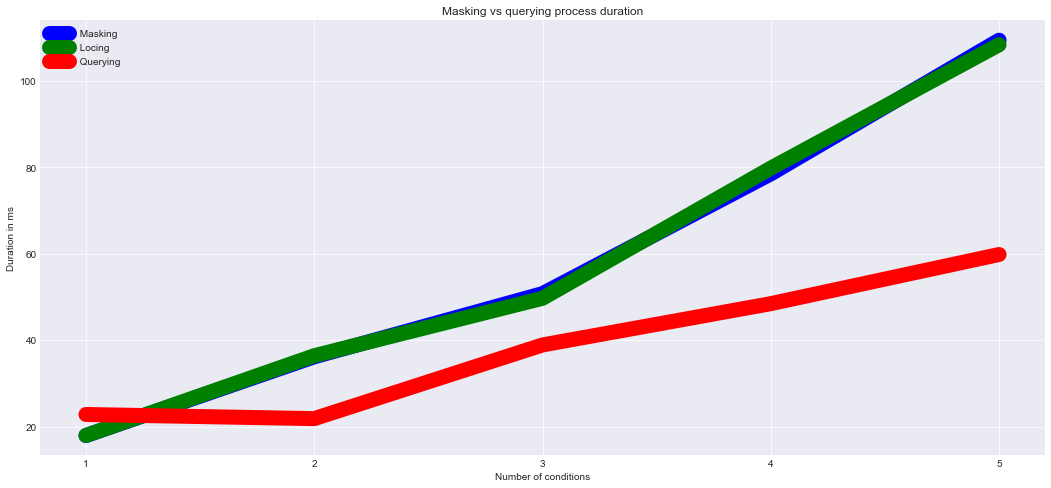

In [333]:
conditions = [5, 4, 3, 2, 1]
ax = plt.figure().gca()
ax.plot(conditions, t_mask, color="b", label=" Masking", linewidth=15)
ax.plot(conditions, t_loc, color="g", label=" Locing", linewidth=15)
ax.plot(conditions, t_query, color="r", label=" Querying", linewidth=15)
ax.set_ylabel("Duration in ms")
ax.set_xlabel("Number of conditions")
ax.set_title("Masking vs querying process duration")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

As you can see, query is consistently faster than multi-condition masking. This is probably due to low-level optimization.

It requires almost the same approach but less "programmatical", with string formatting.

And, as we can see, loc is very probably using the same inner functions, as the results are very similar than classic masking.

[Go to the top](#start)